In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, 2, 2) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price #買入成本 = 今天收盤
                    Sold = last_trade_price #賣出成本 = 明天開盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本




                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price #買入成本 = 明天開盤
                    Sold = current_price #賣出成本 = 今天收盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price
                    Sold = last_trade_price

                    price_diff = Sold - Buy#最後賺到的錢
                    long_profit_percentage = (Sold - Buy)/Buy
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price
                    Sold = current_price

                    price_diff = Sold - Buy#最後賺到的錢
                    short_profit_percentage = (Sold - Buy)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('AXP', str):
    # load it from yahoo_fin library
    df = si.get_data('AXP')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,1972-06-28,3.404,3.404,3.404,3.404,1.170,0,AXP,3.235,3.508,...,44.318,42.671,36.544,-0.072,-0.071,3.661,3.444,3.227,1,0
1,1972-06-29,3.484,3.484,3.484,3.484,1.197,0,AXP,3.235,3.508,...,50.000,58.839,43.976,-0.060,-0.069,3.619,3.433,3.248,1,0
2,1972-06-30,3.589,3.589,3.589,3.589,1.233,0,AXP,3.235,3.589,...,58.491,72.559,53.504,-0.042,-0.064,3.595,3.429,3.263,1,0
3,1972-07-03,3.725,3.725,3.725,3.725,1.280,0,AXP,3.235,3.725,...,66.949,81.706,62.905,-0.016,-0.054,3.632,3.435,3.238,1,0
4,1972-07-05,3.862,3.862,3.862,3.862,1.327,0,AXP,3.235,3.862,...,71.642,87.804,71.204,0.015,-0.040,3.728,3.458,3.187,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12774,2023-02-24,173.690,174.940,172.190,174.250,174.250,1667400,AXP,172.190,182.150,...,33.233,27.196,39.448,4.192,5.588,182.524,176.706,170.889,0,1
12775,2023-02-27,175.530,175.690,173.080,173.300,173.300,1909000,AXP,172.190,182.150,...,29.526,21.845,33.581,3.693,5.209,182.438,176.756,171.074,0,1
12776,2023-02-28,174.010,175.340,173.580,173.990,173.990,2301400,AXP,172.190,180.740,...,31.110,21.581,29.581,3.316,4.830,182.340,176.822,171.305,0,1
12777,2023-03-01,173.510,177.200,173.010,175.910,175.910,2566500,AXP,172.190,179.880,...,39.589,30.512,29.891,3.135,4.491,182.338,176.872,171.405,1,0


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

11982

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

12737

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
11982,2020-01-02,124.660,126.270,124.230,125.850,120.653,2708000,AXP,123.700,126.280,...,56.030,61.247,63.112,1.443,1.399,128.045,123.208,118.370,1,0
11983,2020-01-03,124.320,125.100,123.940,124.600,119.455,2090600,AXP,123.700,126.280,...,54.802,52.459,59.561,1.352,1.390,127.759,123.540,119.322,0,1
11984,2020-01-06,123.370,124.160,123.120,124.060,118.937,2855200,AXP,123.120,126.270,...,44.972,44.920,54.681,1.222,1.356,127.291,123.829,120.368,1,0
11985,2020-01-07,123.470,124.400,123.360,123.410,118.314,2042300,AXP,123.120,126.270,...,45.176,33.015,47.459,1.055,1.296,127.111,123.969,120.828,0,1
11986,2020-01-08,124.050,126.360,123.800,125.540,120.356,3458200,AXP,123.120,126.360,...,53.423,46.907,47.275,1.081,1.253,126.987,124.224,121.460,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12733,2022-12-23,145.230,147.140,144.520,147.020,146.512,1671800,AXP,142.720,161.550,...,32.846,18.910,21.387,-1.383,-0.176,161.368,152.315,143.262,0,1
12734,2022-12-27,147.290,147.860,145.670,146.390,145.884,1858500,AXP,142.720,158.620,...,32.876,20.301,21.025,-1.503,-0.441,161.491,152.091,142.691,0,1
12735,2022-12-28,146.210,146.820,143.940,144.010,143.513,1490200,AXP,142.720,152.280,...,30.004,18.032,20.027,-1.769,-0.707,161.533,151.570,141.608,0,1
12736,2022-12-29,145.080,147.620,144.400,147.320,146.811,1758500,AXP,142.720,148.590,...,29.720,38.143,26.066,-1.693,-0.904,160.782,151.057,141.332,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['K_Value', 'D_Value', 'MACD', 'DIF']].to_numpy()[start:end]#抓取特徵資料
    signal_features = signal_features.reshape(len(signal_features), 2, 2)#變成[['FL','FH'],['UpLine', 'DownLine']]
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64], pi=[64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.394    |
| fps                | 3        |
| nupdates           | 1        |
| policy_entropy     | 0.676    |
| total_timesteps    | 5        |
| value_loss         | 0.0154   |
---------------------------------
---------------------------------
| explained_variance | -8.65    |
| fps                | 125      |
| nupdates           | 100      |
| policy_entropy     | 0.666    |
| total_timesteps    | 500      |
| value_loss         | 0.00443  |
---------------------------------
---------------------------------
| explained_variance | -0.253 

---------------------------------
| explained_variance | -0.00555 |
| fps                | 169      |
| nupdates           | 1500     |
| policy_entropy     | 0.0686   |
| total_timesteps    | 7500     |
| value_loss         | 18.2     |
---------------------------------
---------------------------------
| explained_variance | -1.52    |
| fps                | 168      |
| nupdates           | 1600     |
| policy_entropy     | 0.0441   |
| total_timesteps    | 8000     |
| value_loss         | 0.00471  |
---------------------------------
---------------------------------
| explained_variance | -0.161   |
| fps                | 167      |
| nupdates           | 1700     |
| policy_entropy     | 0.0418   |
| total_timesteps    | 8500     |
| value_loss         | 0.0192   |
---------------------------------
---------------------------------
| explained_variance | -2.08    |
| fps                | 167      |
| nupdates           | 1800     |
| policy_entropy     | 0.0519   |
| total_timest

---------------------------------
| explained_variance | 0.101    |
| fps                | 159      |
| nupdates           | 4600     |
| policy_entropy     | 0.167    |
| total_timesteps    | 23000    |
| value_loss         | 0.000284 |
---------------------------------
---------------------------------
| explained_variance | 0.0349   |
| fps                | 159      |
| nupdates           | 4700     |
| policy_entropy     | 0.16     |
| total_timesteps    | 23500    |
| value_loss         | 0.0091   |
---------------------------------
---------------------------------
| explained_variance | -0.137   |
| fps                | 159      |
| nupdates           | 4800     |
| policy_entropy     | 0.0763   |
| total_timesteps    | 24000    |
| value_loss         | 0.0261   |
---------------------------------
---------------------------------
| explained_variance | -0.00705 |
| fps                | 159      |
| nupdates           | 4900     |
| policy_entropy     | 0.0463   |
| total_timest

---------------------------------
| explained_variance | -0.578   |
| fps                | 157      |
| nupdates           | 7700     |
| policy_entropy     | 0.173    |
| total_timesteps    | 38500    |
| value_loss         | 0.0159   |
---------------------------------
---------------------------------
| explained_variance | -0.118   |
| fps                | 157      |
| nupdates           | 7800     |
| policy_entropy     | 0.153    |
| total_timesteps    | 39000    |
| value_loss         | 0.161    |
---------------------------------
---------------------------------
| explained_variance | 0.175    |
| fps                | 157      |
| nupdates           | 7900     |
| policy_entropy     | 0.124    |
| total_timesteps    | 39500    |
| value_loss         | 0.00401  |
---------------------------------
---------------------------------
| explained_variance | -0.073   |
| fps                | 157      |
| nupdates           | 8000     |
| policy_entropy     | 0.146    |
| total_timest

---------------------------------
| explained_variance | -0.1     |
| fps                | 156      |
| nupdates           | 10800    |
| policy_entropy     | 0.0568   |
| total_timesteps    | 54000    |
| value_loss         | 0.0232   |
---------------------------------
---------------------------------
| explained_variance | 0.00639  |
| fps                | 156      |
| nupdates           | 10900    |
| policy_entropy     | 0.104    |
| total_timesteps    | 54500    |
| value_loss         | 0.0281   |
---------------------------------
---------------------------------
| explained_variance | 0.192    |
| fps                | 156      |
| nupdates           | 11000    |
| policy_entropy     | 0.0645   |
| total_timesteps    | 55000    |
| value_loss         | 0.0282   |
---------------------------------
---------------------------------
| explained_variance | -0.0721  |
| fps                | 156      |
| nupdates           | 11100    |
| policy_entropy     | 0.0677   |
| total_timest

---------------------------------
| explained_variance | 0.279    |
| fps                | 156      |
| nupdates           | 13900    |
| policy_entropy     | 0.0442   |
| total_timesteps    | 69500    |
| value_loss         | 0.0487   |
---------------------------------
---------------------------------
| explained_variance | -0.296   |
| fps                | 156      |
| nupdates           | 14000    |
| policy_entropy     | 0.0456   |
| total_timesteps    | 70000    |
| value_loss         | 0.017    |
---------------------------------
---------------------------------
| explained_variance | 0.108    |
| fps                | 156      |
| nupdates           | 14100    |
| policy_entropy     | 0.0527   |
| total_timesteps    | 70500    |
| value_loss         | 0.798    |
---------------------------------
---------------------------------
| explained_variance | 0.011    |
| fps                | 156      |
| nupdates           | 14200    |
| policy_entropy     | 0.0288   |
| total_timest

---------------------------------
| explained_variance | 0.152    |
| fps                | 155      |
| nupdates           | 17000    |
| policy_entropy     | 0.0373   |
| total_timesteps    | 85000    |
| value_loss         | 0.0221   |
---------------------------------
---------------------------------
| explained_variance | -0.127   |
| fps                | 155      |
| nupdates           | 17100    |
| policy_entropy     | 0.0941   |
| total_timesteps    | 85500    |
| value_loss         | 0.0145   |
---------------------------------
---------------------------------
| explained_variance | -0.2     |
| fps                | 155      |
| nupdates           | 17200    |
| policy_entropy     | 0.0737   |
| total_timesteps    | 86000    |
| value_loss         | 0.0112   |
---------------------------------
---------------------------------
| explained_variance | 0.00179  |
| fps                | 155      |
| nupdates           | 17300    |
| policy_entropy     | 0.0314   |
| total_timest

---------------------------------
| explained_variance | 0.00658  |
| fps                | 155      |
| nupdates           | 20100    |
| policy_entropy     | 0.329    |
| total_timesteps    | 100500   |
| value_loss         | 0.0696   |
---------------------------------
---------------------------------
| explained_variance | -0.00745 |
| fps                | 155      |
| nupdates           | 20200    |
| policy_entropy     | 0.447    |
| total_timesteps    | 101000   |
| value_loss         | 0.12     |
---------------------------------
---------------------------------
| explained_variance | -0.0157  |
| fps                | 155      |
| nupdates           | 20300    |
| policy_entropy     | 0.346    |
| total_timesteps    | 101500   |
| value_loss         | 4.7      |
---------------------------------
---------------------------------
| explained_variance | 0.128    |
| fps                | 155      |
| nupdates           | 20400    |
| policy_entropy     | 0.497    |
| total_timest

---------------------------------
| explained_variance | -0.0182  |
| fps                | 155      |
| nupdates           | 23200    |
| policy_entropy     | 0.189    |
| total_timesteps    | 116000   |
| value_loss         | 0.113    |
---------------------------------
---------------------------------
| explained_variance | -7.5e-05 |
| fps                | 155      |
| nupdates           | 23300    |
| policy_entropy     | 0.211    |
| total_timesteps    | 116500   |
| value_loss         | 78.4     |
---------------------------------
---------------------------------
| explained_variance | 0.00484  |
| fps                | 155      |
| nupdates           | 23400    |
| policy_entropy     | 0.205    |
| total_timesteps    | 117000   |
| value_loss         | 2.43     |
---------------------------------
---------------------------------
| explained_variance | 0.0138   |
| fps                | 155      |
| nupdates           | 23500    |
| policy_entropy     | 0.392    |
| total_timest

---------------------------------
| explained_variance | -0.0114  |
| fps                | 155      |
| nupdates           | 26300    |
| policy_entropy     | 0.328    |
| total_timesteps    | 131500   |
| value_loss         | 0.513    |
---------------------------------
---------------------------------
| explained_variance | 0.0396   |
| fps                | 155      |
| nupdates           | 26400    |
| policy_entropy     | 0.201    |
| total_timesteps    | 132000   |
| value_loss         | 0.228    |
---------------------------------
---------------------------------
| explained_variance | -1.36    |
| fps                | 155      |
| nupdates           | 26500    |
| policy_entropy     | 0.394    |
| total_timesteps    | 132500   |
| value_loss         | 0.0011   |
---------------------------------
---------------------------------
| explained_variance | 0.0383   |
| fps                | 155      |
| nupdates           | 26600    |
| policy_entropy     | 0.33     |
| total_timest

---------------------------------
| explained_variance | -0.0309  |
| fps                | 155      |
| nupdates           | 29400    |
| policy_entropy     | 0.165    |
| total_timesteps    | 147000   |
| value_loss         | 0.475    |
---------------------------------
---------------------------------
| explained_variance | -0.53    |
| fps                | 155      |
| nupdates           | 29500    |
| policy_entropy     | 0.274    |
| total_timesteps    | 147500   |
| value_loss         | 0.025    |
---------------------------------
---------------------------------
| explained_variance | -0.446   |
| fps                | 155      |
| nupdates           | 29600    |
| policy_entropy     | 0.263    |
| total_timesteps    | 148000   |
| value_loss         | 0.0134   |
---------------------------------
---------------------------------
| explained_variance | 0.469    |
| fps                | 155      |
| nupdates           | 29700    |
| policy_entropy     | 0.144    |
| total_timest

---------------------------------
| explained_variance | -6.1     |
| fps                | 155      |
| nupdates           | 32500    |
| policy_entropy     | 0.0858   |
| total_timesteps    | 162500   |
| value_loss         | 0.00277  |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 155      |
| nupdates           | 32600    |
| policy_entropy     | 0.0752   |
| total_timesteps    | 163000   |
| value_loss         | 0.0699   |
---------------------------------
---------------------------------
| explained_variance | 0.0111   |
| fps                | 155      |
| nupdates           | 32700    |
| policy_entropy     | 0.0585   |
| total_timesteps    | 163500   |
| value_loss         | 1.7      |
---------------------------------
---------------------------------
| explained_variance | 0.0349   |
| fps                | 155      |
| nupdates           | 32800    |
| policy_entropy     | 0.0582   |
| total_timest

---------------------------------
| explained_variance | -1.3     |
| fps                | 155      |
| nupdates           | 35600    |
| policy_entropy     | 0.101    |
| total_timesteps    | 178000   |
| value_loss         | 0.0187   |
---------------------------------
---------------------------------
| explained_variance | -0.147   |
| fps                | 155      |
| nupdates           | 35700    |
| policy_entropy     | 0.151    |
| total_timesteps    | 178500   |
| value_loss         | 0.0363   |
---------------------------------
---------------------------------
| explained_variance | -0.303   |
| fps                | 155      |
| nupdates           | 35800    |
| policy_entropy     | 0.114    |
| total_timesteps    | 179000   |
| value_loss         | 0.0163   |
---------------------------------
---------------------------------
| explained_variance | 0.00285  |
| fps                | 155      |
| nupdates           | 35900    |
| policy_entropy     | 0.0972   |
| total_timest

---------------------------------
| explained_variance | -0.0198  |
| fps                | 155      |
| nupdates           | 38700    |
| policy_entropy     | 0.064    |
| total_timesteps    | 193500   |
| value_loss         | 0.0108   |
---------------------------------
---------------------------------
| explained_variance | 0.0458   |
| fps                | 155      |
| nupdates           | 38800    |
| policy_entropy     | 0.0911   |
| total_timesteps    | 194000   |
| value_loss         | 0.00252  |
---------------------------------
---------------------------------
| explained_variance | -0.155   |
| fps                | 155      |
| nupdates           | 38900    |
| policy_entropy     | 0.0527   |
| total_timesteps    | 194500   |
| value_loss         | 0.0498   |
---------------------------------
---------------------------------
| explained_variance | -0.0933  |
| fps                | 155      |
| nupdates           | 39000    |
| policy_entropy     | 0.126    |
| total_timest

---------------------------------
| explained_variance | 0.0878   |
| fps                | 154      |
| nupdates           | 41800    |
| policy_entropy     | 0.266    |
| total_timesteps    | 209000   |
| value_loss         | 0.0801   |
---------------------------------
---------------------------------
| explained_variance | 0.0392   |
| fps                | 154      |
| nupdates           | 41900    |
| policy_entropy     | 0.304    |
| total_timesteps    | 209500   |
| value_loss         | 0.00929  |
---------------------------------
---------------------------------
| explained_variance | -0.0273  |
| fps                | 154      |
| nupdates           | 42000    |
| policy_entropy     | 0.251    |
| total_timesteps    | 210000   |
| value_loss         | 0.00688  |
---------------------------------
---------------------------------
| explained_variance | 0.0179   |
| fps                | 154      |
| nupdates           | 42100    |
| policy_entropy     | 0.288    |
| total_timest

---------------------------------
| explained_variance | -0.0227  |
| fps                | 154      |
| nupdates           | 44900    |
| policy_entropy     | 0.324    |
| total_timesteps    | 224500   |
| value_loss         | 0.147    |
---------------------------------
---------------------------------
| explained_variance | 0.04     |
| fps                | 154      |
| nupdates           | 45000    |
| policy_entropy     | 0.456    |
| total_timesteps    | 225000   |
| value_loss         | 2.7      |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 154      |
| nupdates           | 45100    |
| policy_entropy     | 0.467    |
| total_timesteps    | 225500   |
| value_loss         | 0.0525   |
---------------------------------
---------------------------------
| explained_variance | -0.00964 |
| fps                | 154      |
| nupdates           | 45200    |
| policy_entropy     | 0.275    |
| total_timest

---------------------------------
| explained_variance | -0.0616  |
| fps                | 154      |
| nupdates           | 48000    |
| policy_entropy     | 0.0549   |
| total_timesteps    | 240000   |
| value_loss         | 0.0789   |
---------------------------------
---------------------------------
| explained_variance | 0.0271   |
| fps                | 154      |
| nupdates           | 48100    |
| policy_entropy     | 0.0521   |
| total_timesteps    | 240500   |
| value_loss         | 0.282    |
---------------------------------
---------------------------------
| explained_variance | 0.000183 |
| fps                | 154      |
| nupdates           | 48200    |
| policy_entropy     | 0.0427   |
| total_timesteps    | 241000   |
| value_loss         | 0.83     |
---------------------------------
---------------------------------
| explained_variance | -0.0432  |
| fps                | 154      |
| nupdates           | 48300    |
| policy_entropy     | 0.0361   |
| total_timest

---------------------------------
| explained_variance | -0.28    |
| fps                | 154      |
| nupdates           | 51100    |
| policy_entropy     | 0.0297   |
| total_timesteps    | 255500   |
| value_loss         | 0.432    |
---------------------------------
---------------------------------
| explained_variance | 0.0861   |
| fps                | 154      |
| nupdates           | 51200    |
| policy_entropy     | 0.021    |
| total_timesteps    | 256000   |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | -0.0451  |
| fps                | 154      |
| nupdates           | 51300    |
| policy_entropy     | 0.0157   |
| total_timesteps    | 256500   |
| value_loss         | 0.574    |
---------------------------------
---------------------------------
| explained_variance | 0.429    |
| fps                | 154      |
| nupdates           | 51400    |
| policy_entropy     | 0.0235   |
| total_timest

---------------------------------
| explained_variance | 0.122    |
| fps                | 154      |
| nupdates           | 54200    |
| policy_entropy     | 0.0123   |
| total_timesteps    | 271000   |
| value_loss         | 0.0778   |
---------------------------------
---------------------------------
| explained_variance | 0.0542   |
| fps                | 154      |
| nupdates           | 54300    |
| policy_entropy     | 0.0142   |
| total_timesteps    | 271500   |
| value_loss         | 1.76     |
---------------------------------
---------------------------------
| explained_variance | 0.762    |
| fps                | 154      |
| nupdates           | 54400    |
| policy_entropy     | 0.0179   |
| total_timesteps    | 272000   |
| value_loss         | 0.00102  |
---------------------------------
---------------------------------
| explained_variance | -0.0477  |
| fps                | 154      |
| nupdates           | 54500    |
| policy_entropy     | 0.0199   |
| total_timest

---------------------------------
| explained_variance | -0.0267  |
| fps                | 154      |
| nupdates           | 57300    |
| policy_entropy     | 0.035    |
| total_timesteps    | 286500   |
| value_loss         | 0.595    |
---------------------------------
---------------------------------
| explained_variance | 0.00729  |
| fps                | 154      |
| nupdates           | 57400    |
| policy_entropy     | 0.0769   |
| total_timesteps    | 287000   |
| value_loss         | 35.8     |
---------------------------------
---------------------------------
| explained_variance | -5.81    |
| fps                | 154      |
| nupdates           | 57500    |
| policy_entropy     | 0.101    |
| total_timesteps    | 287500   |
| value_loss         | 0.00772  |
---------------------------------
---------------------------------
| explained_variance | -0.0342  |
| fps                | 154      |
| nupdates           | 57600    |
| policy_entropy     | 0.0722   |
| total_timest

---------------------------------
| explained_variance | 0.00669  |
| fps                | 154      |
| nupdates           | 60400    |
| policy_entropy     | 0.242    |
| total_timesteps    | 302000   |
| value_loss         | 3.65     |
---------------------------------
---------------------------------
| explained_variance | 0.374    |
| fps                | 154      |
| nupdates           | 60500    |
| policy_entropy     | 0.301    |
| total_timesteps    | 302500   |
| value_loss         | 0.00232  |
---------------------------------
---------------------------------
| explained_variance | 0.38     |
| fps                | 154      |
| nupdates           | 60600    |
| policy_entropy     | 0.343    |
| total_timesteps    | 303000   |
| value_loss         | 0.00409  |
---------------------------------
---------------------------------
| explained_variance | -0.142   |
| fps                | 154      |
| nupdates           | 60700    |
| policy_entropy     | 0.411    |
| total_timest

---------------------------------
| explained_variance | -3.11    |
| fps                | 154      |
| nupdates           | 63500    |
| policy_entropy     | 0.188    |
| total_timesteps    | 317500   |
| value_loss         | 0.0206   |
---------------------------------
---------------------------------
| explained_variance | -0.449   |
| fps                | 154      |
| nupdates           | 63600    |
| policy_entropy     | 0.18     |
| total_timesteps    | 318000   |
| value_loss         | 0.00829  |
---------------------------------
---------------------------------
| explained_variance | 0.356    |
| fps                | 154      |
| nupdates           | 63700    |
| policy_entropy     | 0.185    |
| total_timesteps    | 318500   |
| value_loss         | 0.121    |
---------------------------------
---------------------------------
| explained_variance | -0.0304  |
| fps                | 154      |
| nupdates           | 63800    |
| policy_entropy     | 0.144    |
| total_timest

---------------------------------
| explained_variance | -0.133   |
| fps                | 154      |
| nupdates           | 66600    |
| policy_entropy     | 0.053    |
| total_timesteps    | 333000   |
| value_loss         | 0.00811  |
---------------------------------
---------------------------------
| explained_variance | 0.00874  |
| fps                | 154      |
| nupdates           | 66700    |
| policy_entropy     | 0.0296   |
| total_timesteps    | 333500   |
| value_loss         | 0.0443   |
---------------------------------
----------------------------------
| explained_variance | -0.000939 |
| fps                | 154       |
| nupdates           | 66800     |
| policy_entropy     | 0.0294    |
| total_timesteps    | 334000    |
| value_loss         | 0.00936   |
----------------------------------
---------------------------------
| explained_variance | 0.00791  |
| fps                | 154      |
| nupdates           | 66900    |
| policy_entropy     | 0.0278   |
| tota

---------------------------------
| explained_variance | 0.00722  |
| fps                | 153      |
| nupdates           | 69700    |
| policy_entropy     | 0.0463   |
| total_timesteps    | 348500   |
| value_loss         | 0.0191   |
---------------------------------
---------------------------------
| explained_variance | 0.593    |
| fps                | 153      |
| nupdates           | 69800    |
| policy_entropy     | 0.0319   |
| total_timesteps    | 349000   |
| value_loss         | 0.00374  |
---------------------------------
---------------------------------
| explained_variance | -0.0196  |
| fps                | 153      |
| nupdates           | 69900    |
| policy_entropy     | 0.0343   |
| total_timesteps    | 349500   |
| value_loss         | 0.417    |
---------------------------------
---------------------------------
| explained_variance | 0.14     |
| fps                | 153      |
| nupdates           | 70000    |
| policy_entropy     | 0.0631   |
| total_timest

---------------------------------
| explained_variance | 0.351    |
| fps                | 153      |
| nupdates           | 72800    |
| policy_entropy     | 0.273    |
| total_timesteps    | 364000   |
| value_loss         | 0.00385  |
---------------------------------
---------------------------------
| explained_variance | 0.172    |
| fps                | 153      |
| nupdates           | 72900    |
| policy_entropy     | 0.147    |
| total_timesteps    | 364500   |
| value_loss         | 0.0612   |
---------------------------------
---------------------------------
| explained_variance | 0.21     |
| fps                | 153      |
| nupdates           | 73000    |
| policy_entropy     | 0.248    |
| total_timesteps    | 365000   |
| value_loss         | 0.0299   |
---------------------------------
---------------------------------
| explained_variance | -0.217   |
| fps                | 153      |
| nupdates           | 73100    |
| policy_entropy     | 0.183    |
| total_timest

---------------------------------
| explained_variance | 0.000164 |
| fps                | 153      |
| nupdates           | 75900    |
| policy_entropy     | 0.0723   |
| total_timesteps    | 379500   |
| value_loss         | 0.0269   |
---------------------------------
---------------------------------
| explained_variance | -0.00151 |
| fps                | 153      |
| nupdates           | 76000    |
| policy_entropy     | 0.102    |
| total_timesteps    | 380000   |
| value_loss         | 0.0138   |
---------------------------------
---------------------------------
| explained_variance | 0.0485   |
| fps                | 153      |
| nupdates           | 76100    |
| policy_entropy     | 0.102    |
| total_timesteps    | 380500   |
| value_loss         | 0.00641  |
---------------------------------
---------------------------------
| explained_variance | -0.0119  |
| fps                | 153      |
| nupdates           | 76200    |
| policy_entropy     | 0.0455   |
| total_timest

---------------------------------
| explained_variance | 0.00806  |
| fps                | 153      |
| nupdates           | 79000    |
| policy_entropy     | 0.174    |
| total_timesteps    | 395000   |
| value_loss         | 0.725    |
---------------------------------
---------------------------------
| explained_variance | 0.0288   |
| fps                | 153      |
| nupdates           | 79100    |
| policy_entropy     | 0.117    |
| total_timesteps    | 395500   |
| value_loss         | 0.228    |
---------------------------------
---------------------------------
| explained_variance | -0.00276 |
| fps                | 153      |
| nupdates           | 79200    |
| policy_entropy     | 0.0957   |
| total_timesteps    | 396000   |
| value_loss         | 11.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00401 |
| fps                | 153      |
| nupdates           | 79300    |
| policy_entropy     | 0.0891   |
| total_timest

---------------------------------
| explained_variance | -0.0453  |
| fps                | 153      |
| nupdates           | 82100    |
| policy_entropy     | 0.178    |
| total_timesteps    | 410500   |
| value_loss         | 0.21     |
---------------------------------
---------------------------------
| explained_variance | 0.00714  |
| fps                | 153      |
| nupdates           | 82200    |
| policy_entropy     | 0.196    |
| total_timesteps    | 411000   |
| value_loss         | 3        |
---------------------------------
---------------------------------
| explained_variance | -0.148   |
| fps                | 153      |
| nupdates           | 82300    |
| policy_entropy     | 0.143    |
| total_timesteps    | 411500   |
| value_loss         | 6.26     |
---------------------------------
---------------------------------
| explained_variance | -0.269   |
| fps                | 153      |
| nupdates           | 82400    |
| policy_entropy     | 0.233    |
| total_timest

---------------------------------
| explained_variance | 0.0349   |
| fps                | 153      |
| nupdates           | 85200    |
| policy_entropy     | 0.0464   |
| total_timesteps    | 426000   |
| value_loss         | 0.393    |
---------------------------------
---------------------------------
| explained_variance | -0.0142  |
| fps                | 153      |
| nupdates           | 85300    |
| policy_entropy     | 0.0481   |
| total_timesteps    | 426500   |
| value_loss         | 1.01     |
---------------------------------
---------------------------------
| explained_variance | 0.239    |
| fps                | 153      |
| nupdates           | 85400    |
| policy_entropy     | 0.0589   |
| total_timesteps    | 427000   |
| value_loss         | 0.0485   |
---------------------------------
---------------------------------
| explained_variance | 0.188    |
| fps                | 153      |
| nupdates           | 85500    |
| policy_entropy     | 0.0791   |
| total_timest

---------------------------------
| explained_variance | -0.0179  |
| fps                | 153      |
| nupdates           | 88300    |
| policy_entropy     | 0.0697   |
| total_timesteps    | 441500   |
| value_loss         | 2.19     |
---------------------------------
---------------------------------
| explained_variance | 0.00254  |
| fps                | 153      |
| nupdates           | 88400    |
| policy_entropy     | 0.196    |
| total_timesteps    | 442000   |
| value_loss         | 0.0196   |
---------------------------------
---------------------------------
| explained_variance | 0.0713   |
| fps                | 153      |
| nupdates           | 88500    |
| policy_entropy     | 0.328    |
| total_timesteps    | 442500   |
| value_loss         | 0.174    |
---------------------------------
---------------------------------
| explained_variance | 0.00721  |
| fps                | 153      |
| nupdates           | 88600    |
| policy_entropy     | 0.266    |
| total_timest

---------------------------------
| explained_variance | -0.0385  |
| fps                | 153      |
| nupdates           | 91400    |
| policy_entropy     | 0.266    |
| total_timesteps    | 457000   |
| value_loss         | 3.07     |
---------------------------------
---------------------------------
| explained_variance | -0.0409  |
| fps                | 153      |
| nupdates           | 91500    |
| policy_entropy     | 0.337    |
| total_timesteps    | 457500   |
| value_loss         | 0.00881  |
---------------------------------
---------------------------------
| explained_variance | -0.204   |
| fps                | 153      |
| nupdates           | 91600    |
| policy_entropy     | 0.271    |
| total_timesteps    | 458000   |
| value_loss         | 0.0265   |
---------------------------------
---------------------------------
| explained_variance | -0.74    |
| fps                | 153      |
| nupdates           | 91700    |
| policy_entropy     | 0.344    |
| total_timest

---------------------------------
| explained_variance | 0.35     |
| fps                | 153      |
| nupdates           | 94500    |
| policy_entropy     | 0.298    |
| total_timesteps    | 472500   |
| value_loss         | 0.0137   |
---------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 153      |
| nupdates           | 94600    |
| policy_entropy     | 0.295    |
| total_timesteps    | 473000   |
| value_loss         | 0.0107   |
---------------------------------
---------------------------------
| explained_variance | -1.03    |
| fps                | 153      |
| nupdates           | 94700    |
| policy_entropy     | 0.287    |
| total_timesteps    | 473500   |
| value_loss         | 0.00616  |
---------------------------------
---------------------------------
| explained_variance | -0.0393  |
| fps                | 153      |
| nupdates           | 94800    |
| policy_entropy     | 0.219    |
| total_timest

---------------------------------
| explained_variance | 0.00146  |
| fps                | 153      |
| nupdates           | 97600    |
| policy_entropy     | 0.436    |
| total_timesteps    | 488000   |
| value_loss         | 0.473    |
---------------------------------
---------------------------------
| explained_variance | -0.404   |
| fps                | 153      |
| nupdates           | 97700    |
| policy_entropy     | 0.329    |
| total_timesteps    | 488500   |
| value_loss         | 0.192    |
---------------------------------
---------------------------------
| explained_variance | -0.167   |
| fps                | 153      |
| nupdates           | 97800    |
| policy_entropy     | 0.171    |
| total_timesteps    | 489000   |
| value_loss         | 0.334    |
---------------------------------
---------------------------------
| explained_variance | 0.586    |
| fps                | 153      |
| nupdates           | 97900    |
| policy_entropy     | 0.165    |
| total_timest

---------------------------------
| explained_variance | -0.131   |
| fps                | 153      |
| nupdates           | 100700   |
| policy_entropy     | 0.118    |
| total_timesteps    | 503500   |
| value_loss         | 0.0116   |
---------------------------------
---------------------------------
| explained_variance | 0.012    |
| fps                | 153      |
| nupdates           | 100800   |
| policy_entropy     | 0.0585   |
| total_timesteps    | 504000   |
| value_loss         | 0.111    |
---------------------------------
----------------------------------
| explained_variance | -0.000133 |
| fps                | 153       |
| nupdates           | 100900    |
| policy_entropy     | 0.0671    |
| total_timesteps    | 504500    |
| value_loss         | 1.51      |
----------------------------------
---------------------------------
| explained_variance | 0.00165  |
| fps                | 153      |
| nupdates           | 101000   |
| policy_entropy     | 0.148    |
| tota

---------------------------------
| explained_variance | -0.686   |
| fps                | 153      |
| nupdates           | 103800   |
| policy_entropy     | 0.164    |
| total_timesteps    | 519000   |
| value_loss         | 0.00841  |
---------------------------------
---------------------------------
| explained_variance | 0.246    |
| fps                | 153      |
| nupdates           | 103900   |
| policy_entropy     | 0.177    |
| total_timesteps    | 519500   |
| value_loss         | 0.0593   |
---------------------------------
---------------------------------
| explained_variance | 0.00354  |
| fps                | 153      |
| nupdates           | 104000   |
| policy_entropy     | 0.254    |
| total_timesteps    | 520000   |
| value_loss         | 0.0462   |
---------------------------------
---------------------------------
| explained_variance | -0.00151 |
| fps                | 153      |
| nupdates           | 104100   |
| policy_entropy     | 0.111    |
| total_timest

---------------------------------
| explained_variance | -0.0175  |
| fps                | 153      |
| nupdates           | 106900   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 534500   |
| value_loss         | 0.234    |
---------------------------------
---------------------------------
| explained_variance | 0.0268   |
| fps                | 153      |
| nupdates           | 107000   |
| policy_entropy     | 0.012    |
| total_timesteps    | 535000   |
| value_loss         | 0.0781   |
---------------------------------
---------------------------------
| explained_variance | 0.0677   |
| fps                | 153      |
| nupdates           | 107100   |
| policy_entropy     | 0.0106   |
| total_timesteps    | 535500   |
| value_loss         | 0.568    |
---------------------------------
----------------------------------
| explained_variance | -0.000285 |
| fps                | 153       |
| nupdates           | 107200    |
| policy_entropy     | 0.00532   |
| total_t

---------------------------------
| explained_variance | 0.00132  |
| fps                | 153      |
| nupdates           | 110000   |
| policy_entropy     | 0.0399   |
| total_timesteps    | 550000   |
| value_loss         | 0.00532  |
---------------------------------
---------------------------------
| explained_variance | -0.0217  |
| fps                | 153      |
| nupdates           | 110100   |
| policy_entropy     | 0.0238   |
| total_timesteps    | 550500   |
| value_loss         | 0.0635   |
---------------------------------
---------------------------------
| explained_variance | -0.00792 |
| fps                | 153      |
| nupdates           | 110200   |
| policy_entropy     | 0.0315   |
| total_timesteps    | 551000   |
| value_loss         | 4.83     |
---------------------------------
---------------------------------
| explained_variance | 0.599    |
| fps                | 153      |
| nupdates           | 110300   |
| policy_entropy     | 0.091    |
| total_timest

---------------------------------
| explained_variance | -0.0413  |
| fps                | 153      |
| nupdates           | 113100   |
| policy_entropy     | 0.134    |
| total_timesteps    | 565500   |
| value_loss         | 0.336    |
---------------------------------
---------------------------------
| explained_variance | -0.00124 |
| fps                | 153      |
| nupdates           | 113200   |
| policy_entropy     | 0.0537   |
| total_timesteps    | 566000   |
| value_loss         | 0.451    |
---------------------------------
---------------------------------
| explained_variance | 0.00443  |
| fps                | 153      |
| nupdates           | 113300   |
| policy_entropy     | 0.0575   |
| total_timesteps    | 566500   |
| value_loss         | 6.74     |
---------------------------------
---------------------------------
| explained_variance | -3.13    |
| fps                | 153      |
| nupdates           | 113400   |
| policy_entropy     | 0.117    |
| total_timest

---------------------------------
| explained_variance | -0.00109 |
| fps                | 153      |
| nupdates           | 116200   |
| policy_entropy     | 0.296    |
| total_timesteps    | 581000   |
| value_loss         | 1.39     |
---------------------------------
---------------------------------
| explained_variance | -0.0327  |
| fps                | 153      |
| nupdates           | 116300   |
| policy_entropy     | 0.192    |
| total_timesteps    | 581500   |
| value_loss         | 52.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00052 |
| fps                | 153      |
| nupdates           | 116400   |
| policy_entropy     | 0.463    |
| total_timesteps    | 582000   |
| value_loss         | 0.0108   |
---------------------------------
---------------------------------
| explained_variance | -0.333   |
| fps                | 153      |
| nupdates           | 116500   |
| policy_entropy     | 0.523    |
| total_timest

----------------------------------
| explained_variance | -1.31e-05 |
| fps                | 153       |
| nupdates           | 119300    |
| policy_entropy     | 0.0983    |
| total_timesteps    | 596500    |
| value_loss         | 16.8      |
----------------------------------
---------------------------------
| explained_variance | -1.43    |
| fps                | 153      |
| nupdates           | 119400   |
| policy_entropy     | 0.307    |
| total_timesteps    | 597000   |
| value_loss         | 0.0308   |
---------------------------------
---------------------------------
| explained_variance | -1.18    |
| fps                | 153      |
| nupdates           | 119500   |
| policy_entropy     | 0.357    |
| total_timesteps    | 597500   |
| value_loss         | 0.0461   |
---------------------------------
---------------------------------
| explained_variance | 0.0938   |
| fps                | 153      |
| nupdates           | 119600   |
| policy_entropy     | 0.233    |
| tota

---------------------------------
| explained_variance | 0.0193   |
| fps                | 153      |
| nupdates           | 122400   |
| policy_entropy     | 0.187    |
| total_timesteps    | 612000   |
| value_loss         | 0.0293   |
---------------------------------
---------------------------------
| explained_variance | -0.164   |
| fps                | 153      |
| nupdates           | 122500   |
| policy_entropy     | 0.174    |
| total_timesteps    | 612500   |
| value_loss         | 0.00168  |
---------------------------------
---------------------------------
| explained_variance | 0.0642   |
| fps                | 153      |
| nupdates           | 122600   |
| policy_entropy     | 0.12     |
| total_timesteps    | 613000   |
| value_loss         | 0.0325   |
---------------------------------
---------------------------------
| explained_variance | 0.2      |
| fps                | 153      |
| nupdates           | 122700   |
| policy_entropy     | 0.119    |
| total_timest

---------------------------------
| explained_variance | -0.0681  |
| fps                | 153      |
| nupdates           | 125500   |
| policy_entropy     | 0.0654   |
| total_timesteps    | 627500   |
| value_loss         | 0.00339  |
---------------------------------
---------------------------------
| explained_variance | 0.00709  |
| fps                | 153      |
| nupdates           | 125600   |
| policy_entropy     | 0.0942   |
| total_timesteps    | 628000   |
| value_loss         | 0.00911  |
---------------------------------
---------------------------------
| explained_variance | 0.254    |
| fps                | 153      |
| nupdates           | 125700   |
| policy_entropy     | 0.129    |
| total_timesteps    | 628500   |
| value_loss         | 0.00368  |
---------------------------------
---------------------------------
| explained_variance | -0.0123  |
| fps                | 153      |
| nupdates           | 125800   |
| policy_entropy     | 0.0771   |
| total_timest

---------------------------------
| explained_variance | 0.0919   |
| fps                | 153      |
| nupdates           | 128600   |
| policy_entropy     | 0.153    |
| total_timesteps    | 643000   |
| value_loss         | 0.0343   |
---------------------------------
---------------------------------
| explained_variance | 0.0913   |
| fps                | 153      |
| nupdates           | 128700   |
| policy_entropy     | 0.0576   |
| total_timesteps    | 643500   |
| value_loss         | 0.0162   |
---------------------------------
---------------------------------
| explained_variance | -0.506   |
| fps                | 153      |
| nupdates           | 128800   |
| policy_entropy     | 0.0395   |
| total_timesteps    | 644000   |
| value_loss         | 0.137    |
---------------------------------
---------------------------------
| explained_variance | -1.11    |
| fps                | 153      |
| nupdates           | 128900   |
| policy_entropy     | 0.159    |
| total_timest

---------------------------------
| explained_variance | -0.285   |
| fps                | 153      |
| nupdates           | 131700   |
| policy_entropy     | 0.423    |
| total_timesteps    | 658500   |
| value_loss         | 0.0163   |
---------------------------------
---------------------------------
| explained_variance | 0.146    |
| fps                | 153      |
| nupdates           | 131800   |
| policy_entropy     | 0.308    |
| total_timesteps    | 659000   |
| value_loss         | 0.0144   |
---------------------------------
---------------------------------
| explained_variance | 0.00199  |
| fps                | 153      |
| nupdates           | 131900   |
| policy_entropy     | 0.544    |
| total_timesteps    | 659500   |
| value_loss         | 0.00203  |
---------------------------------
---------------------------------
| explained_variance | 0.166    |
| fps                | 153      |
| nupdates           | 132000   |
| policy_entropy     | 0.444    |
| total_timest

---------------------------------
| explained_variance | 0.000591 |
| fps                | 153      |
| nupdates           | 134800   |
| policy_entropy     | 0.0651   |
| total_timesteps    | 674000   |
| value_loss         | 0.0187   |
---------------------------------
---------------------------------
| explained_variance | 0.0866   |
| fps                | 153      |
| nupdates           | 134900   |
| policy_entropy     | 0.0596   |
| total_timesteps    | 674500   |
| value_loss         | 0.287    |
---------------------------------
---------------------------------
| explained_variance | -0.00407 |
| fps                | 153      |
| nupdates           | 135000   |
| policy_entropy     | 0.0541   |
| total_timesteps    | 675000   |
| value_loss         | 0.422    |
---------------------------------
----------------------------------
| explained_variance | -0.000894 |
| fps                | 153       |
| nupdates           | 135100    |
| policy_entropy     | 0.0174    |
| total_t

---------------------------------
| explained_variance | -0.0883  |
| fps                | 153      |
| nupdates           | 137900   |
| policy_entropy     | 0.184    |
| total_timesteps    | 689500   |
| value_loss         | 0.00556  |
---------------------------------
---------------------------------
| explained_variance | 0.0209   |
| fps                | 153      |
| nupdates           | 138000   |
| policy_entropy     | 0.296    |
| total_timesteps    | 690000   |
| value_loss         | 0.266    |
---------------------------------
---------------------------------
| explained_variance | -0.00748 |
| fps                | 153      |
| nupdates           | 138100   |
| policy_entropy     | 0.128    |
| total_timesteps    | 690500   |
| value_loss         | 2.29     |
---------------------------------
---------------------------------
| explained_variance | -0.00115 |
| fps                | 153      |
| nupdates           | 138200   |
| policy_entropy     | 0.0729   |
| total_timest

---------------------------------
| explained_variance | 0.00474  |
| fps                | 153      |
| nupdates           | 141000   |
| policy_entropy     | 0.0899   |
| total_timesteps    | 705000   |
| value_loss         | 0.368    |
---------------------------------
---------------------------------
| explained_variance | 0.00666  |
| fps                | 153      |
| nupdates           | 141100   |
| policy_entropy     | 0.0791   |
| total_timesteps    | 705500   |
| value_loss         | 0.219    |
---------------------------------
---------------------------------
| explained_variance | -0.0022  |
| fps                | 153      |
| nupdates           | 141200   |
| policy_entropy     | 0.0387   |
| total_timesteps    | 706000   |
| value_loss         | 0.0589   |
---------------------------------
---------------------------------
| explained_variance | 0.0664   |
| fps                | 153      |
| nupdates           | 141300   |
| policy_entropy     | 0.0625   |
| total_timest

---------------------------------
| explained_variance | 0.0539   |
| fps                | 153      |
| nupdates           | 144100   |
| policy_entropy     | 0.362    |
| total_timesteps    | 720500   |
| value_loss         | 0.861    |
---------------------------------
---------------------------------
| explained_variance | 0.0336   |
| fps                | 153      |
| nupdates           | 144200   |
| policy_entropy     | 0.168    |
| total_timesteps    | 721000   |
| value_loss         | 0.602    |
---------------------------------
---------------------------------
| explained_variance | 2.59e-05 |
| fps                | 153      |
| nupdates           | 144300   |
| policy_entropy     | 0.398    |
| total_timesteps    | 721500   |
| value_loss         | 0.00248  |
---------------------------------
---------------------------------
| explained_variance | 0.0256   |
| fps                | 153      |
| nupdates           | 144400   |
| policy_entropy     | 0.48     |
| total_timest

----------------------------------
| explained_variance | -0.000341 |
| fps                | 153       |
| nupdates           | 147200    |
| policy_entropy     | 0.159     |
| total_timesteps    | 736000    |
| value_loss         | 3.5       |
----------------------------------
---------------------------------
| explained_variance | -0.00688 |
| fps                | 153      |
| nupdates           | 147300   |
| policy_entropy     | 0.162    |
| total_timesteps    | 736500   |
| value_loss         | 0.48     |
---------------------------------
---------------------------------
| explained_variance | -0.307   |
| fps                | 153      |
| nupdates           | 147400   |
| policy_entropy     | 0.254    |
| total_timesteps    | 737000   |
| value_loss         | 0.0111   |
---------------------------------
---------------------------------
| explained_variance | -0.216   |
| fps                | 154      |
| nupdates           | 147500   |
| policy_entropy     | 0.281    |
| tota

---------------------------------
| explained_variance | 0.101    |
| fps                | 154      |
| nupdates           | 150300   |
| policy_entropy     | 0.0582   |
| total_timesteps    | 751500   |
| value_loss         | 2.78     |
---------------------------------
---------------------------------
| explained_variance | -12.1    |
| fps                | 154      |
| nupdates           | 150400   |
| policy_entropy     | 0.2      |
| total_timesteps    | 752000   |
| value_loss         | 0.00803  |
---------------------------------
---------------------------------
| explained_variance | -0.834   |
| fps                | 154      |
| nupdates           | 150500   |
| policy_entropy     | 0.153    |
| total_timesteps    | 752500   |
| value_loss         | 0.099    |
---------------------------------
---------------------------------
| explained_variance | 0.27     |
| fps                | 154      |
| nupdates           | 150600   |
| policy_entropy     | 0.122    |
| total_timest

---------------------------------
| explained_variance | 0.0125   |
| fps                | 154      |
| nupdates           | 153400   |
| policy_entropy     | 0.139    |
| total_timesteps    | 767000   |
| value_loss         | 0.0173   |
---------------------------------
---------------------------------
| explained_variance | -0.00637 |
| fps                | 154      |
| nupdates           | 153500   |
| policy_entropy     | 0.136    |
| total_timesteps    | 767500   |
| value_loss         | 0.104    |
---------------------------------
---------------------------------
| explained_variance | 0.0726   |
| fps                | 154      |
| nupdates           | 153600   |
| policy_entropy     | 0.0817   |
| total_timesteps    | 768000   |
| value_loss         | 0.333    |
---------------------------------
---------------------------------
| explained_variance | 0.0209   |
| fps                | 154      |
| nupdates           | 153700   |
| policy_entropy     | 0.06     |
| total_timest

---------------------------------
| explained_variance | 0.284    |
| fps                | 154      |
| nupdates           | 156500   |
| policy_entropy     | 0.0455   |
| total_timesteps    | 782500   |
| value_loss         | 0.0179   |
---------------------------------
---------------------------------
| explained_variance | 0.086    |
| fps                | 154      |
| nupdates           | 156600   |
| policy_entropy     | 0.0474   |
| total_timesteps    | 783000   |
| value_loss         | 0.0187   |
---------------------------------
---------------------------------
| explained_variance | 0.45     |
| fps                | 154      |
| nupdates           | 156700   |
| policy_entropy     | 0.0349   |
| total_timesteps    | 783500   |
| value_loss         | 0.017    |
---------------------------------
---------------------------------
| explained_variance | 0.0611   |
| fps                | 154      |
| nupdates           | 156800   |
| policy_entropy     | 0.0513   |
| total_timest

---------------------------------
| explained_variance | 0.0517   |
| fps                | 154      |
| nupdates           | 159600   |
| policy_entropy     | 0.00689  |
| total_timesteps    | 798000   |
| value_loss         | 0.0226   |
---------------------------------
---------------------------------
| explained_variance | -0.362   |
| fps                | 154      |
| nupdates           | 159700   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 798500   |
| value_loss         | 0.00789  |
---------------------------------
---------------------------------
| explained_variance | 0.273    |
| fps                | 154      |
| nupdates           | 159800   |
| policy_entropy     | 0.0094   |
| total_timesteps    | 799000   |
| value_loss         | 0.0158   |
---------------------------------
---------------------------------
| explained_variance | 0.296    |
| fps                | 154      |
| nupdates           | 159900   |
| policy_entropy     | 0.0219   |
| total_timest

---------------------------------
| explained_variance | 0.104    |
| fps                | 154      |
| nupdates           | 162700   |
| policy_entropy     | 0.0442   |
| total_timesteps    | 813500   |
| value_loss         | 0.215    |
---------------------------------
---------------------------------
| explained_variance | 0.0794   |
| fps                | 154      |
| nupdates           | 162800   |
| policy_entropy     | 0.0338   |
| total_timesteps    | 814000   |
| value_loss         | 0.413    |
---------------------------------
---------------------------------
| explained_variance | -0.024   |
| fps                | 154      |
| nupdates           | 162900   |
| policy_entropy     | 0.0646   |
| total_timesteps    | 814500   |
| value_loss         | 0.0413   |
---------------------------------
---------------------------------
| explained_variance | 0.147    |
| fps                | 154      |
| nupdates           | 163000   |
| policy_entropy     | 0.0591   |
| total_timest

---------------------------------
| explained_variance | -0.14    |
| fps                | 154      |
| nupdates           | 165800   |
| policy_entropy     | 0.24     |
| total_timesteps    | 829000   |
| value_loss         | 0.0282   |
---------------------------------
---------------------------------
| explained_variance | -0.00253 |
| fps                | 154      |
| nupdates           | 165900   |
| policy_entropy     | 0.39     |
| total_timesteps    | 829500   |
| value_loss         | 0.00136  |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 154      |
| nupdates           | 166000   |
| policy_entropy     | 0.438    |
| total_timesteps    | 830000   |
| value_loss         | 0.0568   |
---------------------------------
---------------------------------
| explained_variance | -0.00114 |
| fps                | 154      |
| nupdates           | 166100   |
| policy_entropy     | 0.339    |
| total_timest

---------------------------------
| explained_variance | -0.139   |
| fps                | 154      |
| nupdates           | 168900   |
| policy_entropy     | 0.146    |
| total_timesteps    | 844500   |
| value_loss         | 0.0706   |
---------------------------------
---------------------------------
| explained_variance | -0.0144  |
| fps                | 154      |
| nupdates           | 169000   |
| policy_entropy     | 0.0925   |
| total_timesteps    | 845000   |
| value_loss         | 0.587    |
---------------------------------
---------------------------------
| explained_variance | 0.0676   |
| fps                | 154      |
| nupdates           | 169100   |
| policy_entropy     | 0.0274   |
| total_timesteps    | 845500   |
| value_loss         | 2.51     |
---------------------------------
---------------------------------
| explained_variance | -0.0318  |
| fps                | 154      |
| nupdates           | 169200   |
| policy_entropy     | 0.0314   |
| total_timest

---------------------------------
| explained_variance | -0.483   |
| fps                | 154      |
| nupdates           | 172000   |
| policy_entropy     | 0.253    |
| total_timesteps    | 860000   |
| value_loss         | 0.12     |
---------------------------------
---------------------------------
| explained_variance | 0.0329   |
| fps                | 154      |
| nupdates           | 172100   |
| policy_entropy     | 0.061    |
| total_timesteps    | 860500   |
| value_loss         | 0.695    |
---------------------------------
---------------------------------
| explained_variance | -0.00255 |
| fps                | 154      |
| nupdates           | 172200   |
| policy_entropy     | 0.0557   |
| total_timesteps    | 861000   |
| value_loss         | 3.42     |
---------------------------------
---------------------------------
| explained_variance | 0.674    |
| fps                | 154      |
| nupdates           | 172300   |
| policy_entropy     | 0.186    |
| total_timest

---------------------------------
| explained_variance | -0.01    |
| fps                | 154      |
| nupdates           | 175100   |
| policy_entropy     | 0.258    |
| total_timesteps    | 875500   |
| value_loss         | 0.0388   |
---------------------------------
---------------------------------
| explained_variance | -0.00594 |
| fps                | 154      |
| nupdates           | 175200   |
| policy_entropy     | 0.124    |
| total_timesteps    | 876000   |
| value_loss         | 2.73     |
---------------------------------
---------------------------------
| explained_variance | -4.7     |
| fps                | 154      |
| nupdates           | 175300   |
| policy_entropy     | 0.207    |
| total_timesteps    | 876500   |
| value_loss         | 0.0393   |
---------------------------------
---------------------------------
| explained_variance | -0.853   |
| fps                | 154      |
| nupdates           | 175400   |
| policy_entropy     | 0.203    |
| total_timest

----------------------------------
| explained_variance | -3.47e-05 |
| fps                | 154       |
| nupdates           | 178200    |
| policy_entropy     | 0.00655   |
| total_timesteps    | 891000    |
| value_loss         | 2.31      |
----------------------------------
---------------------------------
| explained_variance | -0.932   |
| fps                | 154      |
| nupdates           | 178300   |
| policy_entropy     | 0.0238   |
| total_timesteps    | 891500   |
| value_loss         | 0.00929  |
---------------------------------
---------------------------------
| explained_variance | 0.269    |
| fps                | 154      |
| nupdates           | 178400   |
| policy_entropy     | 0.0272   |
| total_timesteps    | 892000   |
| value_loss         | 0.00687  |
---------------------------------
---------------------------------
| explained_variance | -0.337   |
| fps                | 154      |
| nupdates           | 178500   |
| policy_entropy     | 0.0325   |
| tota

---------------------------------
| explained_variance | 0.028    |
| fps                | 154      |
| nupdates           | 181300   |
| policy_entropy     | 0.0463   |
| total_timesteps    | 906500   |
| value_loss         | 0.0213   |
---------------------------------
---------------------------------
| explained_variance | -0.196   |
| fps                | 154      |
| nupdates           | 181400   |
| policy_entropy     | 0.0782   |
| total_timesteps    | 907000   |
| value_loss         | 0.0321   |
---------------------------------
----------------------------------
| explained_variance | -0.000581 |
| fps                | 154       |
| nupdates           | 181500    |
| policy_entropy     | 0.158     |
| total_timesteps    | 907500    |
| value_loss         | 0.00595   |
----------------------------------
---------------------------------
| explained_variance | 0.509    |
| fps                | 154      |
| nupdates           | 181600   |
| policy_entropy     | 0.0963   |
| tota

---------------------------------
| explained_variance | 0.000239 |
| fps                | 154      |
| nupdates           | 184400   |
| policy_entropy     | 0.526    |
| total_timesteps    | 922000   |
| value_loss         | 0.00241  |
---------------------------------
---------------------------------
| explained_variance | -0.3     |
| fps                | 154      |
| nupdates           | 184500   |
| policy_entropy     | 0.514    |
| total_timesteps    | 922500   |
| value_loss         | 0.0258   |
---------------------------------
---------------------------------
| explained_variance | -0.00334 |
| fps                | 154      |
| nupdates           | 184600   |
| policy_entropy     | 0.355    |
| total_timesteps    | 923000   |
| value_loss         | 0.00695  |
---------------------------------
---------------------------------
| explained_variance | -0.202   |
| fps                | 154      |
| nupdates           | 184700   |
| policy_entropy     | 0.31     |
| total_timest

---------------------------------
| explained_variance | -2.75    |
| fps                | 154      |
| nupdates           | 187500   |
| policy_entropy     | 0.32     |
| total_timesteps    | 937500   |
| value_loss         | 0.0058   |
---------------------------------
---------------------------------
| explained_variance | 0.344    |
| fps                | 154      |
| nupdates           | 187600   |
| policy_entropy     | 0.128    |
| total_timesteps    | 938000   |
| value_loss         | 0.00238  |
---------------------------------
---------------------------------
| explained_variance | 0.00227  |
| fps                | 154      |
| nupdates           | 187700   |
| policy_entropy     | 0.119    |
| total_timesteps    | 938500   |
| value_loss         | 0.00967  |
---------------------------------
---------------------------------
| explained_variance | 0.00106  |
| fps                | 154      |
| nupdates           | 187800   |
| policy_entropy     | 0.129    |
| total_timest

---------------------------------
| explained_variance | 0.0731   |
| fps                | 154      |
| nupdates           | 190600   |
| policy_entropy     | 0.221    |
| total_timesteps    | 953000   |
| value_loss         | 0.0475   |
---------------------------------
---------------------------------
| explained_variance | 0.308    |
| fps                | 154      |
| nupdates           | 190700   |
| policy_entropy     | 0.119    |
| total_timesteps    | 953500   |
| value_loss         | 0.101    |
---------------------------------
---------------------------------
| explained_variance | 0.0244   |
| fps                | 154      |
| nupdates           | 190800   |
| policy_entropy     | 0.12     |
| total_timesteps    | 954000   |
| value_loss         | 0.0344   |
---------------------------------
---------------------------------
| explained_variance | 0.00704  |
| fps                | 154      |
| nupdates           | 190900   |
| policy_entropy     | 0.0833   |
| total_timest

---------------------------------
| explained_variance | -0.273   |
| fps                | 154      |
| nupdates           | 193700   |
| policy_entropy     | 0.00685  |
| total_timesteps    | 968500   |
| value_loss         | 1.66     |
---------------------------------
---------------------------------
| explained_variance | -0.151   |
| fps                | 154      |
| nupdates           | 193800   |
| policy_entropy     | 0.00489  |
| total_timesteps    | 969000   |
| value_loss         | 0.0548   |
---------------------------------
---------------------------------
| explained_variance | -0.00217 |
| fps                | 154      |
| nupdates           | 193900   |
| policy_entropy     | 0.0061   |
| total_timesteps    | 969500   |
| value_loss         | 0.44     |
---------------------------------
----------------------------------
| explained_variance | -0.000764 |
| fps                | 154       |
| nupdates           | 194000    |
| policy_entropy     | 0.00557   |
| total_t

---------------------------------
| explained_variance | 0.0284   |
| fps                | 154      |
| nupdates           | 196800   |
| policy_entropy     | 0.00106  |
| total_timesteps    | 984000   |
| value_loss         | 0.934    |
---------------------------------
---------------------------------
| explained_variance | 0.0599   |
| fps                | 154      |
| nupdates           | 196900   |
| policy_entropy     | 0.00211  |
| total_timesteps    | 984500   |
| value_loss         | 1.61     |
---------------------------------
---------------------------------
| explained_variance | -0.00966 |
| fps                | 154      |
| nupdates           | 197000   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 985000   |
| value_loss         | 1.62     |
---------------------------------
---------------------------------
| explained_variance | -0.0121  |
| fps                | 154      |
| nupdates           | 197100   |
| policy_entropy     | 0.000505 |
| total_timest

---------------------------------
| explained_variance | -0.142   |
| fps                | 154      |
| nupdates           | 199900   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 999500   |
| value_loss         | 0.0404   |
---------------------------------
---------------------------------
| explained_variance | 0.00228  |
| fps                | 154      |
| nupdates           | 200000   |
| policy_entropy     | 0.00138  |
| total_timesteps    | 1000000  |
| value_loss         | 0.552    |
---------------------------------
---------------------------------
| explained_variance | 0.0709   |
| fps                | 154      |
| nupdates           | 200100   |
| policy_entropy     | 0.000511 |
| total_timesteps    | 1000500  |
| value_loss         | 1.81     |
---------------------------------
---------------------------------
| explained_variance | -0.429   |
| fps                | 154      |
| nupdates           | 200200   |
| policy_entropy     | 0.000584 |
| total_timest

---------------------------------
| explained_variance | -0.0157  |
| fps                | 154      |
| nupdates           | 203000   |
| policy_entropy     | 0.00185  |
| total_timesteps    | 1015000  |
| value_loss         | 0.473    |
---------------------------------
---------------------------------
| explained_variance | -0.00764 |
| fps                | 154      |
| nupdates           | 203100   |
| policy_entropy     | 0.000954 |
| total_timesteps    | 1015500  |
| value_loss         | 5.46     |
---------------------------------
---------------------------------
| explained_variance | 0.0242   |
| fps                | 154      |
| nupdates           | 203200   |
| policy_entropy     | 0.00107  |
| total_timesteps    | 1016000  |
| value_loss         | 30.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0219  |
| fps                | 154      |
| nupdates           | 203300   |
| policy_entropy     | 0.00241  |
| total_timest

---------------------------------
| explained_variance | 0.00026  |
| fps                | 154      |
| nupdates           | 206100   |
| policy_entropy     | 0.00144  |
| total_timesteps    | 1030500  |
| value_loss         | 0.948    |
---------------------------------
---------------------------------
| explained_variance | -0.126   |
| fps                | 154      |
| nupdates           | 206200   |
| policy_entropy     | 0.00156  |
| total_timesteps    | 1031000  |
| value_loss         | 1.8      |
---------------------------------
---------------------------------
| explained_variance | -1.61    |
| fps                | 154      |
| nupdates           | 206300   |
| policy_entropy     | 0.00384  |
| total_timesteps    | 1031500  |
| value_loss         | 0.00181  |
---------------------------------
---------------------------------
| explained_variance | -2.7     |
| fps                | 154      |
| nupdates           | 206400   |
| policy_entropy     | 0.00291  |
| total_timest

---------------------------------
| explained_variance | 0.0122   |
| fps                | 154      |
| nupdates           | 209200   |
| policy_entropy     | 0.000256 |
| total_timesteps    | 1046000  |
| value_loss         | 6.14     |
---------------------------------
---------------------------------
| explained_variance | -1.06    |
| fps                | 154      |
| nupdates           | 209300   |
| policy_entropy     | 0.0011   |
| total_timesteps    | 1046500  |
| value_loss         | 0.0282   |
---------------------------------
----------------------------------
| explained_variance | -0.000802 |
| fps                | 154       |
| nupdates           | 209400    |
| policy_entropy     | 0.0011    |
| total_timesteps    | 1047000   |
| value_loss         | 0.0621    |
----------------------------------
---------------------------------
| explained_variance | -0.00174 |
| fps                | 154      |
| nupdates           | 209500   |
| policy_entropy     | 0.000858 |
| tota

---------------------------------
| explained_variance | 0.141    |
| fps                | 154      |
| nupdates           | 212200   |
| policy_entropy     | 0.000248 |
| total_timesteps    | 1061000  |
| value_loss         | 0.0751   |
---------------------------------
---------------------------------
| explained_variance | 0.00338  |
| fps                | 154      |
| nupdates           | 212300   |
| policy_entropy     | 0.00102  |
| total_timesteps    | 1061500  |
| value_loss         | 0.00291  |
---------------------------------
---------------------------------
| explained_variance | -0.00728 |
| fps                | 154      |
| nupdates           | 212400   |
| policy_entropy     | 0.0012   |
| total_timesteps    | 1062000  |
| value_loss         | 0.0013   |
---------------------------------
---------------------------------
| explained_variance | -0.0371  |
| fps                | 154      |
| nupdates           | 212500   |
| policy_entropy     | 0.00145  |
| total_timest

---------------------------------
| explained_variance | -0.103   |
| fps                | 154      |
| nupdates           | 215300   |
| policy_entropy     | 0.000861 |
| total_timesteps    | 1076500  |
| value_loss         | 0.00333  |
---------------------------------
---------------------------------
| explained_variance | -0.00362 |
| fps                | 154      |
| nupdates           | 215400   |
| policy_entropy     | 0.00128  |
| total_timesteps    | 1077000  |
| value_loss         | 0.00213  |
---------------------------------
---------------------------------
| explained_variance | -0.00193 |
| fps                | 154      |
| nupdates           | 215500   |
| policy_entropy     | 0.00113  |
| total_timesteps    | 1077500  |
| value_loss         | 0.0384   |
---------------------------------
---------------------------------
| explained_variance | -0.375   |
| fps                | 154      |
| nupdates           | 215600   |
| policy_entropy     | 0.000819 |
| total_timest

---------------------------------
| explained_variance | 0.00237  |
| fps                | 154      |
| nupdates           | 218300   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 1091500  |
| value_loss         | 3.8      |
---------------------------------
---------------------------------
| explained_variance | -0.709   |
| fps                | 154      |
| nupdates           | 218400   |
| policy_entropy     | 0.00195  |
| total_timesteps    | 1092000  |
| value_loss         | 0.00246  |
---------------------------------
---------------------------------
| explained_variance | 0.106    |
| fps                | 154      |
| nupdates           | 218500   |
| policy_entropy     | 0.00214  |
| total_timesteps    | 1092500  |
| value_loss         | 0.00434  |
---------------------------------
---------------------------------
| explained_variance | -0.611   |
| fps                | 154      |
| nupdates           | 218600   |
| policy_entropy     | 0.00204  |
| total_timest

---------------------------------
| explained_variance | -0.0404  |
| fps                | 154      |
| nupdates           | 221400   |
| policy_entropy     | 0.00252  |
| total_timesteps    | 1107000  |
| value_loss         | 0.00101  |
---------------------------------
---------------------------------
| explained_variance | -0.00847 |
| fps                | 154      |
| nupdates           | 221500   |
| policy_entropy     | 0.0028   |
| total_timesteps    | 1107500  |
| value_loss         | 0.0112   |
---------------------------------
---------------------------------
| explained_variance | -0.0058  |
| fps                | 154      |
| nupdates           | 221600   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 1108000  |
| value_loss         | 0.0241   |
---------------------------------
---------------------------------
| explained_variance | 0.000666 |
| fps                | 154      |
| nupdates           | 221700   |
| policy_entropy     | 0.00135  |
| total_timest

---------------------------------
| explained_variance | -0.158   |
| fps                | 154      |
| nupdates           | 224500   |
| policy_entropy     | 0.00445  |
| total_timesteps    | 1122500  |
| value_loss         | 0.00546  |
---------------------------------
---------------------------------
| explained_variance | 0.157    |
| fps                | 154      |
| nupdates           | 224600   |
| policy_entropy     | 0.00408  |
| total_timesteps    | 1123000  |
| value_loss         | 0.558    |
---------------------------------
---------------------------------
| explained_variance | 0.000993 |
| fps                | 154      |
| nupdates           | 224700   |
| policy_entropy     | 0.00356  |
| total_timesteps    | 1123500  |
| value_loss         | 0.00891  |
---------------------------------
---------------------------------
| explained_variance | 0.00101  |
| fps                | 154      |
| nupdates           | 224800   |
| policy_entropy     | 0.00498  |
| total_timest

---------------------------------
| explained_variance | 0.00429  |
| fps                | 154      |
| nupdates           | 227600   |
| policy_entropy     | 0.00434  |
| total_timesteps    | 1138000  |
| value_loss         | 0.0147   |
---------------------------------
---------------------------------
| explained_variance | 0.000733 |
| fps                | 154      |
| nupdates           | 227700   |
| policy_entropy     | 0.00519  |
| total_timesteps    | 1138500  |
| value_loss         | 0.0247   |
---------------------------------
---------------------------------
| explained_variance | 0.0114   |
| fps                | 154      |
| nupdates           | 227800   |
| policy_entropy     | 0.00454  |
| total_timesteps    | 1139000  |
| value_loss         | 0.0107   |
---------------------------------
---------------------------------
| explained_variance | -0.00143 |
| fps                | 154      |
| nupdates           | 227900   |
| policy_entropy     | 0.00591  |
| total_timest

---------------------------------
| explained_variance | 0.242    |
| fps                | 154      |
| nupdates           | 230700   |
| policy_entropy     | 0.00534  |
| total_timesteps    | 1153500  |
| value_loss         | 0.0794   |
---------------------------------
---------------------------------
| explained_variance | -0.0606  |
| fps                | 154      |
| nupdates           | 230800   |
| policy_entropy     | 0.00623  |
| total_timesteps    | 1154000  |
| value_loss         | 0.674    |
---------------------------------
----------------------------------
| explained_variance | -9.95e-05 |
| fps                | 154       |
| nupdates           | 230900    |
| policy_entropy     | 0.00956   |
| total_timesteps    | 1154500   |
| value_loss         | 1.3       |
----------------------------------
----------------------------------
| explained_variance | -0.000685 |
| fps                | 154       |
| nupdates           | 231000    |
| policy_entropy     | 0.00881   |
|

---------------------------------
| explained_variance | -1.44    |
| fps                | 154      |
| nupdates           | 233700   |
| policy_entropy     | 0.0555   |
| total_timesteps    | 1168500  |
| value_loss         | 0.0371   |
---------------------------------
---------------------------------
| explained_variance | -0.333   |
| fps                | 154      |
| nupdates           | 233800   |
| policy_entropy     | 0.033    |
| total_timesteps    | 1169000  |
| value_loss         | 0.154    |
---------------------------------
---------------------------------
| explained_variance | -0.468   |
| fps                | 154      |
| nupdates           | 233900   |
| policy_entropy     | 0.0664   |
| total_timesteps    | 1169500  |
| value_loss         | 0.0087   |
---------------------------------
---------------------------------
| explained_variance | -0.00386 |
| fps                | 154      |
| nupdates           | 234000   |
| policy_entropy     | 0.0521   |
| total_timest

---------------------------------
| explained_variance | 0.0931   |
| fps                | 154      |
| nupdates           | 236700   |
| policy_entropy     | 0.121    |
| total_timesteps    | 1183500  |
| value_loss         | 0.0519   |
---------------------------------
---------------------------------
| explained_variance | -0.00625 |
| fps                | 154      |
| nupdates           | 236800   |
| policy_entropy     | 0.103    |
| total_timesteps    | 1184000  |
| value_loss         | 0.0235   |
---------------------------------
---------------------------------
| explained_variance | -0.00238 |
| fps                | 154      |
| nupdates           | 236900   |
| policy_entropy     | 0.192    |
| total_timesteps    | 1184500  |
| value_loss         | 0.0152   |
---------------------------------
---------------------------------
| explained_variance | -0.00108 |
| fps                | 154      |
| nupdates           | 237000   |
| policy_entropy     | 0.326    |
| total_timest

---------------------------------
| explained_variance | -0.0169  |
| fps                | 154      |
| nupdates           | 239800   |
| policy_entropy     | 0.186    |
| total_timesteps    | 1199000  |
| value_loss         | 0.0317   |
---------------------------------
---------------------------------
| explained_variance | 0.27     |
| fps                | 154      |
| nupdates           | 239900   |
| policy_entropy     | 0.189    |
| total_timesteps    | 1199500  |
| value_loss         | 0.19     |
---------------------------------
---------------------------------
| explained_variance | 0.000535 |
| fps                | 154      |
| nupdates           | 240000   |
| policy_entropy     | 0.232    |
| total_timesteps    | 1200000  |
| value_loss         | 0.157    |
---------------------------------
---------------------------------
| explained_variance | 3.05e-05 |
| fps                | 154      |
| nupdates           | 240100   |
| policy_entropy     | 0.154    |
| total_timest

---------------------------------
| explained_variance | 0.233    |
| fps                | 154      |
| nupdates           | 242900   |
| policy_entropy     | 0.222    |
| total_timesteps    | 1214500  |
| value_loss         | 0.0161   |
---------------------------------
---------------------------------
| explained_variance | -0.0597  |
| fps                | 154      |
| nupdates           | 243000   |
| policy_entropy     | 0.259    |
| total_timesteps    | 1215000  |
| value_loss         | 0.153    |
---------------------------------
---------------------------------
| explained_variance | -0.523   |
| fps                | 154      |
| nupdates           | 243100   |
| policy_entropy     | 0.323    |
| total_timesteps    | 1215500  |
| value_loss         | 3.07     |
---------------------------------
---------------------------------
| explained_variance | 0.00496  |
| fps                | 154      |
| nupdates           | 243200   |
| policy_entropy     | 0.123    |
| total_timest

---------------------------------
| explained_variance | 5.17e-05 |
| fps                | 154      |
| nupdates           | 245900   |
| policy_entropy     | 0.186    |
| total_timesteps    | 1229500  |
| value_loss         | 0.0721   |
---------------------------------
---------------------------------
| explained_variance | 0.000118 |
| fps                | 154      |
| nupdates           | 246000   |
| policy_entropy     | 0.148    |
| total_timesteps    | 1230000  |
| value_loss         | 0.459    |
---------------------------------
----------------------------------
| explained_variance | -5.21e-05 |
| fps                | 154       |
| nupdates           | 246100    |
| policy_entropy     | 0.178     |
| total_timesteps    | 1230500   |
| value_loss         | 0.484     |
----------------------------------
---------------------------------
| explained_variance | 0.0003   |
| fps                | 154      |
| nupdates           | 246200   |
| policy_entropy     | 0.0743   |
| tota

---------------------------------
| explained_variance | 0.000321 |
| fps                | 154      |
| nupdates           | 248900   |
| policy_entropy     | 0.0822   |
| total_timesteps    | 1244500  |
| value_loss         | 0.0308   |
---------------------------------
----------------------------------
| explained_variance | -0.000258 |
| fps                | 154       |
| nupdates           | 249000    |
| policy_entropy     | 0.0902    |
| total_timesteps    | 1245000   |
| value_loss         | 0.079     |
----------------------------------
---------------------------------
| explained_variance | -0.00234 |
| fps                | 154      |
| nupdates           | 249100   |
| policy_entropy     | 0.111    |
| total_timesteps    | 1245500  |
| value_loss         | 3.15     |
---------------------------------
---------------------------------
| explained_variance | 0.0916   |
| fps                | 154      |
| nupdates           | 249200   |
| policy_entropy     | 0.101    |
| tota

---------------------------------
| explained_variance | 0.0185   |
| fps                | 154      |
| nupdates           | 252000   |
| policy_entropy     | 0.199    |
| total_timesteps    | 1260000  |
| value_loss         | 0.00287  |
---------------------------------
---------------------------------
| explained_variance | 0.333    |
| fps                | 154      |
| nupdates           | 252100   |
| policy_entropy     | 0.181    |
| total_timesteps    | 1260500  |
| value_loss         | 0.124    |
---------------------------------
---------------------------------
| explained_variance | -0.0106  |
| fps                | 154      |
| nupdates           | 252200   |
| policy_entropy     | 0.107    |
| total_timesteps    | 1261000  |
| value_loss         | 0.865    |
---------------------------------
---------------------------------
| explained_variance | -0.0278  |
| fps                | 154      |
| nupdates           | 252300   |
| policy_entropy     | 0.177    |
| total_timest

---------------------------------
| explained_variance | -1.28    |
| fps                | 154      |
| nupdates           | 255000   |
| policy_entropy     | 0.104    |
| total_timesteps    | 1275000  |
| value_loss         | 0.0079   |
---------------------------------
---------------------------------
| explained_variance | 0.0166   |
| fps                | 154      |
| nupdates           | 255100   |
| policy_entropy     | 0.104    |
| total_timesteps    | 1275500  |
| value_loss         | 0.064    |
---------------------------------
---------------------------------
| explained_variance | 7.92e-05 |
| fps                | 154      |
| nupdates           | 255200   |
| policy_entropy     | 0.0941   |
| total_timesteps    | 1276000  |
| value_loss         | 1.25     |
---------------------------------
---------------------------------
| explained_variance | 0.303    |
| fps                | 154      |
| nupdates           | 255300   |
| policy_entropy     | 0.0832   |
| total_timest

----------------------------------
| explained_variance | -0.000183 |
| fps                | 154       |
| nupdates           | 258100    |
| policy_entropy     | 0.288     |
| total_timesteps    | 1290500   |
| value_loss         | 0.817     |
----------------------------------
----------------------------------
| explained_variance | -4.98e-05 |
| fps                | 154       |
| nupdates           | 258200    |
| policy_entropy     | 0.379     |
| total_timesteps    | 1291000   |
| value_loss         | 2.92      |
----------------------------------
---------------------------------
| explained_variance | 0.00517  |
| fps                | 154      |
| nupdates           | 258300   |
| policy_entropy     | 0.265    |
| total_timesteps    | 1291500  |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | 0.485    |
| fps                | 154      |
| nupdates           | 258400   |
| policy_entropy     | 0.266    

---------------------------------
| explained_variance | 0.000102 |
| fps                | 154      |
| nupdates           | 261200   |
| policy_entropy     | 0.182    |
| total_timesteps    | 1306000  |
| value_loss         | 0.473    |
---------------------------------
----------------------------------
| explained_variance | -1.62e-05 |
| fps                | 154       |
| nupdates           | 261300    |
| policy_entropy     | 0.18      |
| total_timesteps    | 1306500   |
| value_loss         | 0.539     |
----------------------------------
---------------------------------
| explained_variance | -0.114   |
| fps                | 154      |
| nupdates           | 261400   |
| policy_entropy     | 0.401    |
| total_timesteps    | 1307000  |
| value_loss         | 0.000356 |
---------------------------------
----------------------------------
| explained_variance | -3.65e-05 |
| fps                | 154       |
| nupdates           | 261500    |
| policy_entropy     | 0.426     |
|

----------------------------------
| explained_variance | -1.23e-05 |
| fps                | 154       |
| nupdates           | 264200    |
| policy_entropy     | 0.272     |
| total_timesteps    | 1321000   |
| value_loss         | 1.6       |
----------------------------------
---------------------------------
| explained_variance | -0.0688  |
| fps                | 154      |
| nupdates           | 264300   |
| policy_entropy     | 0.257    |
| total_timesteps    | 1321500  |
| value_loss         | 0.447    |
---------------------------------
---------------------------------
| explained_variance | -2.43    |
| fps                | 154      |
| nupdates           | 264400   |
| policy_entropy     | 0.16     |
| total_timesteps    | 1322000  |
| value_loss         | 0.0388   |
---------------------------------
---------------------------------
| explained_variance | 0.000186 |
| fps                | 154      |
| nupdates           | 264500   |
| policy_entropy     | 0.181    |
| tota

---------------------------------
| explained_variance | 3.46e-05 |
| fps                | 154      |
| nupdates           | 267300   |
| policy_entropy     | 0.0383   |
| total_timesteps    | 1336500  |
| value_loss         | 11.6     |
---------------------------------
---------------------------------
| explained_variance | -0.136   |
| fps                | 154      |
| nupdates           | 267400   |
| policy_entropy     | 0.0338   |
| total_timesteps    | 1337000  |
| value_loss         | 11.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0083   |
| fps                | 154      |
| nupdates           | 267500   |
| policy_entropy     | 0.0387   |
| total_timesteps    | 1337500  |
| value_loss         | 0.000501 |
---------------------------------
---------------------------------
| explained_variance | 0.121    |
| fps                | 154      |
| nupdates           | 267600   |
| policy_entropy     | 0.0601   |
| total_timest

---------------------------------
| explained_variance | -0.0487  |
| fps                | 154      |
| nupdates           | 270400   |
| policy_entropy     | 0.144    |
| total_timesteps    | 1352000  |
| value_loss         | 8.13     |
---------------------------------
---------------------------------
| explained_variance | -0.0955  |
| fps                | 154      |
| nupdates           | 270500   |
| policy_entropy     | 0.213    |
| total_timesteps    | 1352500  |
| value_loss         | 0.00406  |
---------------------------------
---------------------------------
| explained_variance | 0.0825   |
| fps                | 154      |
| nupdates           | 270600   |
| policy_entropy     | 0.177    |
| total_timesteps    | 1353000  |
| value_loss         | 0.198    |
---------------------------------
---------------------------------
| explained_variance | 0.145    |
| fps                | 154      |
| nupdates           | 270700   |
| policy_entropy     | 0.143    |
| total_timest

---------------------------------
| explained_variance | 0.00562  |
| fps                | 154      |
| nupdates           | 273500   |
| policy_entropy     | 0.173    |
| total_timesteps    | 1367500  |
| value_loss         | 0.00171  |
---------------------------------
---------------------------------
| explained_variance | 0.516    |
| fps                | 154      |
| nupdates           | 273600   |
| policy_entropy     | 0.186    |
| total_timesteps    | 1368000  |
| value_loss         | 0.00715  |
---------------------------------
---------------------------------
| explained_variance | -0.00277 |
| fps                | 154      |
| nupdates           | 273700   |
| policy_entropy     | 0.0741   |
| total_timesteps    | 1368500  |
| value_loss         | 0.0243   |
---------------------------------
---------------------------------
| explained_variance | -1.69    |
| fps                | 154      |
| nupdates           | 273800   |
| policy_entropy     | 0.11     |
| total_timest

---------------------------------
| explained_variance | 1.96e-05 |
| fps                | 154      |
| nupdates           | 276600   |
| policy_entropy     | 0.335    |
| total_timesteps    | 1383000  |
| value_loss         | 0.00131  |
---------------------------------
---------------------------------
| explained_variance | -0.548   |
| fps                | 154      |
| nupdates           | 276700   |
| policy_entropy     | 0.296    |
| total_timesteps    | 1383500  |
| value_loss         | 0.136    |
---------------------------------
----------------------------------
| explained_variance | -0.000114 |
| fps                | 154       |
| nupdates           | 276800    |
| policy_entropy     | 0.29      |
| total_timesteps    | 1384000   |
| value_loss         | 0.00693   |
----------------------------------
---------------------------------
| explained_variance | 0.000401 |
| fps                | 154      |
| nupdates           | 276900   |
| policy_entropy     | 0.225    |
| tota

----------------------------------
| explained_variance | -0.000685 |
| fps                | 154       |
| nupdates           | 279600    |
| policy_entropy     | 0.129     |
| total_timesteps    | 1398000   |
| value_loss         | 9.99e-05  |
----------------------------------
---------------------------------
| explained_variance | 2.12e-05 |
| fps                | 154      |
| nupdates           | 279700   |
| policy_entropy     | 0.126    |
| total_timesteps    | 1398500  |
| value_loss         | 0.00226  |
---------------------------------
---------------------------------
| explained_variance | -1.77    |
| fps                | 154      |
| nupdates           | 279800   |
| policy_entropy     | 0.0541   |
| total_timesteps    | 1399000  |
| value_loss         | 0.0382   |
---------------------------------
---------------------------------
| explained_variance | 0.176    |
| fps                | 154      |
| nupdates           | 279900   |
| policy_entropy     | 0.0664   |
| tota

----------------------------------
| explained_variance | -3.12e-05 |
| fps                | 154       |
| nupdates           | 282600    |
| policy_entropy     | 0.126     |
| total_timesteps    | 1413000   |
| value_loss         | 0.000893  |
----------------------------------
---------------------------------
| explained_variance | -0.00047 |
| fps                | 154      |
| nupdates           | 282700   |
| policy_entropy     | 0.0984   |
| total_timesteps    | 1413500  |
| value_loss         | 0.0154   |
---------------------------------
---------------------------------
| explained_variance | 0.000166 |
| fps                | 154      |
| nupdates           | 282800   |
| policy_entropy     | 0.0892   |
| total_timesteps    | 1414000  |
| value_loss         | 0.122    |
---------------------------------
---------------------------------
| explained_variance | 1.45e-05 |
| fps                | 154      |
| nupdates           | 282900   |
| policy_entropy     | 0.0315   |
| tota

---------------------------------
| explained_variance | 0.0017   |
| fps                | 154      |
| nupdates           | 285700   |
| policy_entropy     | 0.0896   |
| total_timesteps    | 1428500  |
| value_loss         | 0.0239   |
---------------------------------
---------------------------------
| explained_variance | 0.000106 |
| fps                | 154      |
| nupdates           | 285800   |
| policy_entropy     | 0.104    |
| total_timesteps    | 1429000  |
| value_loss         | 0.00882  |
---------------------------------
----------------------------------
| explained_variance | -6.23e-05 |
| fps                | 154       |
| nupdates           | 285900    |
| policy_entropy     | 0.076     |
| total_timesteps    | 1429500   |
| value_loss         | 0.0216    |
----------------------------------
----------------------------------
| explained_variance | -8.65e-05 |
| fps                | 154       |
| nupdates           | 286000    |
| policy_entropy     | 0.14      |
|

---------------------------------
| explained_variance | 0.0344   |
| fps                | 154      |
| nupdates           | 288700   |
| policy_entropy     | 0.0633   |
| total_timesteps    | 1443500  |
| value_loss         | 0.00107  |
---------------------------------
---------------------------------
| explained_variance | 6.77e-05 |
| fps                | 154      |
| nupdates           | 288800   |
| policy_entropy     | 0.0372   |
| total_timesteps    | 1444000  |
| value_loss         | 0.374    |
---------------------------------
---------------------------------
| explained_variance | 0.00167  |
| fps                | 154      |
| nupdates           | 288900   |
| policy_entropy     | 0.033    |
| total_timesteps    | 1444500  |
| value_loss         | 0.025    |
---------------------------------
---------------------------------
| explained_variance | 0.000244 |
| fps                | 154      |
| nupdates           | 289000   |
| policy_entropy     | 0.0373   |
| total_timest

----------------------------------
| explained_variance | -8.94e-06 |
| fps                | 154       |
| nupdates           | 291700    |
| policy_entropy     | 0.106     |
| total_timesteps    | 1458500   |
| value_loss         | 0.00144   |
----------------------------------
---------------------------------
| explained_variance | -0.156   |
| fps                | 154      |
| nupdates           | 291800   |
| policy_entropy     | 0.104    |
| total_timesteps    | 1459000  |
| value_loss         | 0.136    |
---------------------------------
---------------------------------
| explained_variance | -0.00128 |
| fps                | 154      |
| nupdates           | 291900   |
| policy_entropy     | 0.0997   |
| total_timesteps    | 1459500  |
| value_loss         | 0.014    |
---------------------------------
---------------------------------
| explained_variance | 0.0547   |
| fps                | 154      |
| nupdates           | 292000   |
| policy_entropy     | 0.149    |
| tota

---------------------------------
| explained_variance | 0.00541  |
| fps                | 154      |
| nupdates           | 294700   |
| policy_entropy     | 0.0591   |
| total_timesteps    | 1473500  |
| value_loss         | 0.000782 |
---------------------------------
---------------------------------
| explained_variance | -0.00039 |
| fps                | 154      |
| nupdates           | 294800   |
| policy_entropy     | 0.0506   |
| total_timesteps    | 1474000  |
| value_loss         | 0.018    |
---------------------------------
----------------------------------
| explained_variance | -0.000701 |
| fps                | 154       |
| nupdates           | 294900    |
| policy_entropy     | 0.0347    |
| total_timesteps    | 1474500   |
| value_loss         | 0.0446    |
----------------------------------
---------------------------------
| explained_variance | -0.00288 |
| fps                | 154      |
| nupdates           | 295000   |
| policy_entropy     | 0.0313   |
| tota

---------------------------------
| explained_variance | 5.27e-05 |
| fps                | 154      |
| nupdates           | 297700   |
| policy_entropy     | 0.034    |
| total_timesteps    | 1488500  |
| value_loss         | 0.00367  |
---------------------------------
---------------------------------
| explained_variance | 0.226    |
| fps                | 154      |
| nupdates           | 297800   |
| policy_entropy     | 0.0357   |
| total_timesteps    | 1489000  |
| value_loss         | 0.00895  |
---------------------------------
---------------------------------
| explained_variance | 0.00052  |
| fps                | 154      |
| nupdates           | 297900   |
| policy_entropy     | 0.0354   |
| total_timesteps    | 1489500  |
| value_loss         | 0.00382  |
---------------------------------
---------------------------------
| explained_variance | -0.616   |
| fps                | 154      |
| nupdates           | 298000   |
| policy_entropy     | 0.0227   |
| total_timest

---------------------------------
| explained_variance | -0.203   |
| fps                | 154      |
| nupdates           | 300800   |
| policy_entropy     | 0.396    |
| total_timesteps    | 1504000  |
| value_loss         | 0.000656 |
---------------------------------
---------------------------------
| explained_variance | -0.185   |
| fps                | 154      |
| nupdates           | 300900   |
| policy_entropy     | 0.257    |
| total_timesteps    | 1504500  |
| value_loss         | 0.0729   |
---------------------------------
---------------------------------
| explained_variance | 0.000515 |
| fps                | 154      |
| nupdates           | 301000   |
| policy_entropy     | 0.28     |
| total_timesteps    | 1505000  |
| value_loss         | 0.202    |
---------------------------------
---------------------------------
| explained_variance | -0.199   |
| fps                | 154      |
| nupdates           | 301100   |
| policy_entropy     | 0.419    |
| total_timest

---------------------------------
| explained_variance | -0.904   |
| fps                | 154      |
| nupdates           | 303900   |
| policy_entropy     | 0.0439   |
| total_timesteps    | 1519500  |
| value_loss         | 0.0798   |
---------------------------------
---------------------------------
| explained_variance | -0.327   |
| fps                | 154      |
| nupdates           | 304000   |
| policy_entropy     | 0.0508   |
| total_timesteps    | 1520000  |
| value_loss         | 0.259    |
---------------------------------
---------------------------------
| explained_variance | -0.301   |
| fps                | 154      |
| nupdates           | 304100   |
| policy_entropy     | 0.0491   |
| total_timesteps    | 1520500  |
| value_loss         | 0.0215   |
---------------------------------
---------------------------------
| explained_variance | 0.0159   |
| fps                | 154      |
| nupdates           | 304200   |
| policy_entropy     | 0.0333   |
| total_timest

---------------------------------
| explained_variance | -0.0749  |
| fps                | 154      |
| nupdates           | 307000   |
| policy_entropy     | 0.0828   |
| total_timesteps    | 1535000  |
| value_loss         | 0.0202   |
---------------------------------
---------------------------------
| explained_variance | 0.132    |
| fps                | 154      |
| nupdates           | 307100   |
| policy_entropy     | 0.0606   |
| total_timesteps    | 1535500  |
| value_loss         | 0.0893   |
---------------------------------
---------------------------------
| explained_variance | 0.0385   |
| fps                | 154      |
| nupdates           | 307200   |
| policy_entropy     | 0.0749   |
| total_timesteps    | 1536000  |
| value_loss         | 0.495    |
---------------------------------
---------------------------------
| explained_variance | 3.53e-05 |
| fps                | 154      |
| nupdates           | 307300   |
| policy_entropy     | 0.0438   |
| total_timest

---------------------------------
| explained_variance | 0.00776  |
| fps                | 154      |
| nupdates           | 310100   |
| policy_entropy     | 0.0941   |
| total_timesteps    | 1550500  |
| value_loss         | 0.698    |
---------------------------------
---------------------------------
| explained_variance | -0.211   |
| fps                | 154      |
| nupdates           | 310200   |
| policy_entropy     | 0.092    |
| total_timesteps    | 1551000  |
| value_loss         | 0.0233   |
---------------------------------
---------------------------------
| explained_variance | 0.0104   |
| fps                | 154      |
| nupdates           | 310300   |
| policy_entropy     | 0.117    |
| total_timesteps    | 1551500  |
| value_loss         | 2.1      |
---------------------------------
---------------------------------
| explained_variance | -0.218   |
| fps                | 154      |
| nupdates           | 310400   |
| policy_entropy     | 0.0634   |
| total_timest

----------------------------------
| explained_variance | -0.000307 |
| fps                | 154       |
| nupdates           | 313200    |
| policy_entropy     | 0.112     |
| total_timesteps    | 1566000   |
| value_loss         | 0.00895   |
----------------------------------
---------------------------------
| explained_variance | -0.0038  |
| fps                | 154      |
| nupdates           | 313300   |
| policy_entropy     | 0.105    |
| total_timesteps    | 1566500  |
| value_loss         | 0.0923   |
---------------------------------
---------------------------------
| explained_variance | 0.0398   |
| fps                | 154      |
| nupdates           | 313400   |
| policy_entropy     | 0.0794   |
| total_timesteps    | 1567000  |
| value_loss         | 5.24     |
---------------------------------
---------------------------------
| explained_variance | -0.183   |
| fps                | 154      |
| nupdates           | 313500   |
| policy_entropy     | 0.16     |
| tota

---------------------------------
| explained_variance | 0.0301   |
| fps                | 154      |
| nupdates           | 316200   |
| policy_entropy     | 0.418    |
| total_timesteps    | 1581000  |
| value_loss         | 0.0701   |
---------------------------------
---------------------------------
| explained_variance | 0.0823   |
| fps                | 154      |
| nupdates           | 316300   |
| policy_entropy     | 0.241    |
| total_timesteps    | 1581500  |
| value_loss         | 0.996    |
---------------------------------
---------------------------------
| explained_variance | 0.0148   |
| fps                | 154      |
| nupdates           | 316400   |
| policy_entropy     | 0.219    |
| total_timesteps    | 1582000  |
| value_loss         | 9.37     |
---------------------------------
---------------------------------
| explained_variance | -0.019   |
| fps                | 154      |
| nupdates           | 316500   |
| policy_entropy     | 0.232    |
| total_timest

---------------------------------
| explained_variance | 0.0903   |
| fps                | 154      |
| nupdates           | 319300   |
| policy_entropy     | 0.196    |
| total_timesteps    | 1596500  |
| value_loss         | 0.172    |
---------------------------------
---------------------------------
| explained_variance | 6.22e-05 |
| fps                | 154      |
| nupdates           | 319400   |
| policy_entropy     | 0.164    |
| total_timesteps    | 1597000  |
| value_loss         | 1.86     |
---------------------------------
---------------------------------
| explained_variance | 0.0489   |
| fps                | 154      |
| nupdates           | 319500   |
| policy_entropy     | 0.134    |
| total_timesteps    | 1597500  |
| value_loss         | 2.37     |
---------------------------------
---------------------------------
| explained_variance | -0.0097  |
| fps                | 154      |
| nupdates           | 319600   |
| policy_entropy     | 0.116    |
| total_timest

---------------------------------
| explained_variance | 0.000114 |
| fps                | 154      |
| nupdates           | 322400   |
| policy_entropy     | 0.267    |
| total_timesteps    | 1612000  |
| value_loss         | 0.0479   |
---------------------------------
---------------------------------
| explained_variance | 0.00013  |
| fps                | 154      |
| nupdates           | 322500   |
| policy_entropy     | 0.157    |
| total_timesteps    | 1612500  |
| value_loss         | 0.995    |
---------------------------------
---------------------------------
| explained_variance | 0.651    |
| fps                | 154      |
| nupdates           | 322600   |
| policy_entropy     | 0.411    |
| total_timesteps    | 1613000  |
| value_loss         | 0.0325   |
---------------------------------
---------------------------------
| explained_variance | 0.194    |
| fps                | 154      |
| nupdates           | 322700   |
| policy_entropy     | 0.426    |
| total_timest

---------------------------------
| explained_variance | -0.175   |
| fps                | 154      |
| nupdates           | 325500   |
| policy_entropy     | 0.0587   |
| total_timesteps    | 1627500  |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| explained_variance | 0.646    |
| fps                | 154      |
| nupdates           | 325600   |
| policy_entropy     | 0.0871   |
| total_timesteps    | 1628000  |
| value_loss         | 0.00555  |
---------------------------------
---------------------------------
| explained_variance | -0.618   |
| fps                | 154      |
| nupdates           | 325700   |
| policy_entropy     | 0.113    |
| total_timesteps    | 1628500  |
| value_loss         | 0.0296   |
---------------------------------
---------------------------------
| explained_variance | -0.218   |
| fps                | 154      |
| nupdates           | 325800   |
| policy_entropy     | 0.0566   |
| total_timest

---------------------------------
| explained_variance | -12.6    |
| fps                | 153      |
| nupdates           | 328600   |
| policy_entropy     | 0.0754   |
| total_timesteps    | 1643000  |
| value_loss         | 0.105    |
---------------------------------
---------------------------------
| explained_variance | 0.0157   |
| fps                | 153      |
| nupdates           | 328700   |
| policy_entropy     | 0.113    |
| total_timesteps    | 1643500  |
| value_loss         | 0.0177   |
---------------------------------
---------------------------------
| explained_variance | 0.0106   |
| fps                | 153      |
| nupdates           | 328800   |
| policy_entropy     | 0.0785   |
| total_timesteps    | 1644000  |
| value_loss         | 0.00773  |
---------------------------------
---------------------------------
| explained_variance | 0.0148   |
| fps                | 153      |
| nupdates           | 328900   |
| policy_entropy     | 0.046    |
| total_timest

---------------------------------
| explained_variance | -0.00337 |
| fps                | 153      |
| nupdates           | 331700   |
| policy_entropy     | 0.0218   |
| total_timesteps    | 1658500  |
| value_loss         | 0.00327  |
---------------------------------
---------------------------------
| explained_variance | 0.00168  |
| fps                | 153      |
| nupdates           | 331800   |
| policy_entropy     | 0.0196   |
| total_timesteps    | 1659000  |
| value_loss         | 0.172    |
---------------------------------
---------------------------------
| explained_variance | -0.365   |
| fps                | 153      |
| nupdates           | 331900   |
| policy_entropy     | 0.0215   |
| total_timesteps    | 1659500  |
| value_loss         | 0.0483   |
---------------------------------
---------------------------------
| explained_variance | -0.0265  |
| fps                | 153      |
| nupdates           | 332000   |
| policy_entropy     | 0.0148   |
| total_timest

---------------------------------
| explained_variance | 0.00509  |
| fps                | 153      |
| nupdates           | 334800   |
| policy_entropy     | 0.036    |
| total_timesteps    | 1674000  |
| value_loss         | 0.0521   |
---------------------------------
---------------------------------
| explained_variance | 0.627    |
| fps                | 153      |
| nupdates           | 334900   |
| policy_entropy     | 0.024    |
| total_timesteps    | 1674500  |
| value_loss         | 0.00846  |
---------------------------------
---------------------------------
| explained_variance | -0.869   |
| fps                | 153      |
| nupdates           | 335000   |
| policy_entropy     | 0.0276   |
| total_timesteps    | 1675000  |
| value_loss         | 0.00716  |
---------------------------------
----------------------------------
| explained_variance | -0.000701 |
| fps                | 153       |
| nupdates           | 335100    |
| policy_entropy     | 0.043     |
| total_t

---------------------------------
| explained_variance | 0.00456  |
| fps                | 153      |
| nupdates           | 337900   |
| policy_entropy     | 0.154    |
| total_timesteps    | 1689500  |
| value_loss         | 0.0253   |
---------------------------------
---------------------------------
| explained_variance | -0.517   |
| fps                | 153      |
| nupdates           | 338000   |
| policy_entropy     | 0.175    |
| total_timesteps    | 1690000  |
| value_loss         | 0.041    |
---------------------------------
---------------------------------
| explained_variance | 0.00153  |
| fps                | 153      |
| nupdates           | 338100   |
| policy_entropy     | 0.225    |
| total_timesteps    | 1690500  |
| value_loss         | 0.223    |
---------------------------------
---------------------------------
| explained_variance | -0.0024  |
| fps                | 153      |
| nupdates           | 338200   |
| policy_entropy     | 0.194    |
| total_timest

---------------------------------
| explained_variance | -0.00331 |
| fps                | 153      |
| nupdates           | 340900   |
| policy_entropy     | 0.0466   |
| total_timesteps    | 1704500  |
| value_loss         | 0.0182   |
---------------------------------
---------------------------------
| explained_variance | -0.15    |
| fps                | 153      |
| nupdates           | 341000   |
| policy_entropy     | 0.0918   |
| total_timesteps    | 1705000  |
| value_loss         | 0.00262  |
---------------------------------
---------------------------------
| explained_variance | 0.000464 |
| fps                | 153      |
| nupdates           | 341100   |
| policy_entropy     | 0.047    |
| total_timesteps    | 1705500  |
| value_loss         | 0.0604   |
---------------------------------
---------------------------------
| explained_variance | 0.328    |
| fps                | 153      |
| nupdates           | 341200   |
| policy_entropy     | 0.0971   |
| total_timest

----------------------------------
| explained_variance | -2.25e-05 |
| fps                | 153       |
| nupdates           | 344000    |
| policy_entropy     | 0.135     |
| total_timesteps    | 1720000   |
| value_loss         | 0.00707   |
----------------------------------
---------------------------------
| explained_variance | -0.11    |
| fps                | 153      |
| nupdates           | 344100   |
| policy_entropy     | 0.153    |
| total_timesteps    | 1720500  |
| value_loss         | 0.0191   |
---------------------------------
---------------------------------
| explained_variance | -0.888   |
| fps                | 153      |
| nupdates           | 344200   |
| policy_entropy     | 0.143    |
| total_timesteps    | 1721000  |
| value_loss         | 0.135    |
---------------------------------
---------------------------------
| explained_variance | 0.021    |
| fps                | 153      |
| nupdates           | 344300   |
| policy_entropy     | 0.143    |
| tota

---------------------------------
| explained_variance | -0.00866 |
| fps                | 153      |
| nupdates           | 347100   |
| policy_entropy     | 0.0543   |
| total_timesteps    | 1735500  |
| value_loss         | 0.0314   |
---------------------------------
---------------------------------
| explained_variance | -0.00183 |
| fps                | 153      |
| nupdates           | 347200   |
| policy_entropy     | 0.0649   |
| total_timesteps    | 1736000  |
| value_loss         | 0.0121   |
---------------------------------
----------------------------------
| explained_variance | -8.99e-05 |
| fps                | 153       |
| nupdates           | 347300    |
| policy_entropy     | 0.0544    |
| total_timesteps    | 1736500   |
| value_loss         | 4.79      |
----------------------------------
---------------------------------
| explained_variance | 0.000198 |
| fps                | 153      |
| nupdates           | 347400   |
| policy_entropy     | 0.0369   |
| tota

---------------------------------
| explained_variance | 0.581    |
| fps                | 153      |
| nupdates           | 350200   |
| policy_entropy     | 0.0259   |
| total_timesteps    | 1751000  |
| value_loss         | 0.00341  |
---------------------------------
---------------------------------
| explained_variance | 0.619    |
| fps                | 153      |
| nupdates           | 350300   |
| policy_entropy     | 0.0213   |
| total_timesteps    | 1751500  |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| explained_variance | 0.0061   |
| fps                | 153      |
| nupdates           | 350400   |
| policy_entropy     | 0.00982  |
| total_timesteps    | 1752000  |
| value_loss         | 0.0857   |
---------------------------------
---------------------------------
| explained_variance | 0.00393  |
| fps                | 153      |
| nupdates           | 350500   |
| policy_entropy     | 0.0104   |
| total_timest

---------------------------------
| explained_variance | -0.25    |
| fps                | 153      |
| nupdates           | 353300   |
| policy_entropy     | 0.0333   |
| total_timesteps    | 1766500  |
| value_loss         | 0.0304   |
---------------------------------
---------------------------------
| explained_variance | 0.000171 |
| fps                | 153      |
| nupdates           | 353400   |
| policy_entropy     | 0.0157   |
| total_timesteps    | 1767000  |
| value_loss         | 1        |
---------------------------------
---------------------------------
| explained_variance | 0.0452   |
| fps                | 153      |
| nupdates           | 353500   |
| policy_entropy     | 0.013    |
| total_timesteps    | 1767500  |
| value_loss         | 7.26     |
---------------------------------
---------------------------------
| explained_variance | 0.681    |
| fps                | 153      |
| nupdates           | 353600   |
| policy_entropy     | 0.0421   |
| total_timest

----------------------------------
| explained_variance | -0.000154 |
| fps                | 153       |
| nupdates           | 356400    |
| policy_entropy     | 0.112     |
| total_timesteps    | 1782000   |
| value_loss         | 0.178     |
----------------------------------
---------------------------------
| explained_variance | 0.0748   |
| fps                | 153      |
| nupdates           | 356500   |
| policy_entropy     | 0.0546   |
| total_timesteps    | 1782500  |
| value_loss         | 3.71     |
---------------------------------
---------------------------------
| explained_variance | -0.118   |
| fps                | 153      |
| nupdates           | 356600   |
| policy_entropy     | 0.103    |
| total_timesteps    | 1783000  |
| value_loss         | 0.00466  |
---------------------------------
---------------------------------
| explained_variance | -1.2     |
| fps                | 153      |
| nupdates           | 356700   |
| policy_entropy     | 0.096    |
| tota

---------------------------------
| explained_variance | 0.000613 |
| fps                | 153      |
| nupdates           | 359500   |
| policy_entropy     | 0.057    |
| total_timesteps    | 1797500  |
| value_loss         | 0.173    |
---------------------------------
---------------------------------
| explained_variance | 0.246    |
| fps                | 153      |
| nupdates           | 359600   |
| policy_entropy     | 0.128    |
| total_timesteps    | 1798000  |
| value_loss         | 0.00288  |
---------------------------------
---------------------------------
| explained_variance | -1       |
| fps                | 153      |
| nupdates           | 359700   |
| policy_entropy     | 0.15     |
| total_timesteps    | 1798500  |
| value_loss         | 0.00251  |
---------------------------------
---------------------------------
| explained_variance | -0.00473 |
| fps                | 153      |
| nupdates           | 359800   |
| policy_entropy     | 0.156    |
| total_timest

---------------------------------
| explained_variance | 0.431    |
| fps                | 153      |
| nupdates           | 362600   |
| policy_entropy     | 0.211    |
| total_timesteps    | 1813000  |
| value_loss         | 0.00981  |
---------------------------------
---------------------------------
| explained_variance | 0.397    |
| fps                | 153      |
| nupdates           | 362700   |
| policy_entropy     | 0.196    |
| total_timesteps    | 1813500  |
| value_loss         | 0.0013   |
---------------------------------
---------------------------------
| explained_variance | -0.0016  |
| fps                | 153      |
| nupdates           | 362800   |
| policy_entropy     | 0.15     |
| total_timesteps    | 1814000  |
| value_loss         | 0.0202   |
---------------------------------
---------------------------------
| explained_variance | -0.0113  |
| fps                | 153      |
| nupdates           | 362900   |
| policy_entropy     | 0.169    |
| total_timest

---------------------------------
| explained_variance | 0.153    |
| fps                | 153      |
| nupdates           | 365700   |
| policy_entropy     | 0.13     |
| total_timesteps    | 1828500  |
| value_loss         | 0.0138   |
---------------------------------
----------------------------------
| explained_variance | -0.000224 |
| fps                | 153       |
| nupdates           | 365800    |
| policy_entropy     | 0.085     |
| total_timesteps    | 1829000   |
| value_loss         | 0.0141    |
----------------------------------
---------------------------------
| explained_variance | 0.13     |
| fps                | 153      |
| nupdates           | 365900   |
| policy_entropy     | 0.0708   |
| total_timesteps    | 1829500  |
| value_loss         | 0.135    |
---------------------------------
---------------------------------
| explained_variance | -0.0499  |
| fps                | 153      |
| nupdates           | 366000   |
| policy_entropy     | 0.0465   |
| tota

---------------------------------
| explained_variance | 0.0546   |
| fps                | 153      |
| nupdates           | 368800   |
| policy_entropy     | 0.353    |
| total_timesteps    | 1844000  |
| value_loss         | 0.0115   |
---------------------------------
---------------------------------
| explained_variance | 0.0114   |
| fps                | 153      |
| nupdates           | 368900   |
| policy_entropy     | 0.286    |
| total_timesteps    | 1844500  |
| value_loss         | 0.00845  |
---------------------------------
---------------------------------
| explained_variance | -1.26    |
| fps                | 153      |
| nupdates           | 369000   |
| policy_entropy     | 0.312    |
| total_timesteps    | 1845000  |
| value_loss         | 0.0379   |
---------------------------------
---------------------------------
| explained_variance | 0.108    |
| fps                | 153      |
| nupdates           | 369100   |
| policy_entropy     | 0.41     |
| total_timest

----------------------------------
| explained_variance | -0.000327 |
| fps                | 153       |
| nupdates           | 371800    |
| policy_entropy     | 0.0661    |
| total_timesteps    | 1859000   |
| value_loss         | 0.0175    |
----------------------------------
---------------------------------
| explained_variance | 0.217    |
| fps                | 153      |
| nupdates           | 371900   |
| policy_entropy     | 0.0527   |
| total_timesteps    | 1859500  |
| value_loss         | 0.0746   |
---------------------------------
----------------------------------
| explained_variance | -0.000523 |
| fps                | 153       |
| nupdates           | 372000    |
| policy_entropy     | 0.0733    |
| total_timesteps    | 1860000   |
| value_loss         | 0.542     |
----------------------------------
---------------------------------
| explained_variance | 0.183    |
| fps                | 153      |
| nupdates           | 372100   |
| policy_entropy     | 0.109    

---------------------------------
| explained_variance | -0.0172  |
| fps                | 153      |
| nupdates           | 374900   |
| policy_entropy     | 0.373    |
| total_timesteps    | 1874500  |
| value_loss         | 0.221    |
---------------------------------
---------------------------------
| explained_variance | 0.00137  |
| fps                | 153      |
| nupdates           | 375000   |
| policy_entropy     | 0.344    |
| total_timesteps    | 1875000  |
| value_loss         | 0.00527  |
---------------------------------
---------------------------------
| explained_variance | 0.000928 |
| fps                | 153      |
| nupdates           | 375100   |
| policy_entropy     | 0.411    |
| total_timesteps    | 1875500  |
| value_loss         | 0.278    |
---------------------------------
---------------------------------
| explained_variance | 0.0416   |
| fps                | 153      |
| nupdates           | 375200   |
| policy_entropy     | 0.451    |
| total_timest

---------------------------------
| explained_variance | 0.191    |
| fps                | 153      |
| nupdates           | 378000   |
| policy_entropy     | 0.0838   |
| total_timesteps    | 1890000  |
| value_loss         | 0.00442  |
---------------------------------
---------------------------------
| explained_variance | -0.0161  |
| fps                | 153      |
| nupdates           | 378100   |
| policy_entropy     | 0.0843   |
| total_timesteps    | 1890500  |
| value_loss         | 0.0629   |
---------------------------------
---------------------------------
| explained_variance | -0.129   |
| fps                | 153      |
| nupdates           | 378200   |
| policy_entropy     | 0.0757   |
| total_timesteps    | 1891000  |
| value_loss         | 0.0612   |
---------------------------------
---------------------------------
| explained_variance | 0.00187  |
| fps                | 153      |
| nupdates           | 378300   |
| policy_entropy     | 0.0405   |
| total_timest

---------------------------------
| explained_variance | 0.0955   |
| fps                | 153      |
| nupdates           | 381000   |
| policy_entropy     | 0.341    |
| total_timesteps    | 1905000  |
| value_loss         | 0.00326  |
---------------------------------
----------------------------------
| explained_variance | -0.000919 |
| fps                | 153       |
| nupdates           | 381100    |
| policy_entropy     | 0.182     |
| total_timesteps    | 1905500   |
| value_loss         | 0.117     |
----------------------------------
---------------------------------
| explained_variance | -0.399   |
| fps                | 153      |
| nupdates           | 381200   |
| policy_entropy     | 0.222    |
| total_timesteps    | 1906000  |
| value_loss         | 0.0531   |
---------------------------------
----------------------------------
| explained_variance | -0.000993 |
| fps                | 153       |
| nupdates           | 381300    |
| policy_entropy     | 0.179     |
|

---------------------------------
| explained_variance | 0.0246   |
| fps                | 153      |
| nupdates           | 384000   |
| policy_entropy     | 0.12     |
| total_timesteps    | 1920000  |
| value_loss         | 0.0328   |
---------------------------------
---------------------------------
| explained_variance | 0.0417   |
| fps                | 153      |
| nupdates           | 384100   |
| policy_entropy     | 0.112    |
| total_timesteps    | 1920500  |
| value_loss         | 0.704    |
---------------------------------
---------------------------------
| explained_variance | 0.00468  |
| fps                | 153      |
| nupdates           | 384200   |
| policy_entropy     | 0.135    |
| total_timesteps    | 1921000  |
| value_loss         | 0.00421  |
---------------------------------
---------------------------------
| explained_variance | 0.00311  |
| fps                | 153      |
| nupdates           | 384300   |
| policy_entropy     | 0.117    |
| total_timest

---------------------------------
| explained_variance | -1.53    |
| fps                | 153      |
| nupdates           | 387100   |
| policy_entropy     | 0.137    |
| total_timesteps    | 1935500  |
| value_loss         | 0.0071   |
---------------------------------
---------------------------------
| explained_variance | 0.000335 |
| fps                | 153      |
| nupdates           | 387200   |
| policy_entropy     | 0.0989   |
| total_timesteps    | 1936000  |
| value_loss         | 0.0416   |
---------------------------------
---------------------------------
| explained_variance | -0.152   |
| fps                | 153      |
| nupdates           | 387300   |
| policy_entropy     | 0.113    |
| total_timesteps    | 1936500  |
| value_loss         | 0.346    |
---------------------------------
---------------------------------
| explained_variance | 0.00169  |
| fps                | 153      |
| nupdates           | 387400   |
| policy_entropy     | 0.0612   |
| total_timest

---------------------------------
| explained_variance | 0.00367  |
| fps                | 153      |
| nupdates           | 390200   |
| policy_entropy     | 0.11     |
| total_timesteps    | 1951000  |
| value_loss         | 0.0184   |
---------------------------------
---------------------------------
| explained_variance | 0.15     |
| fps                | 153      |
| nupdates           | 390300   |
| policy_entropy     | 0.151    |
| total_timesteps    | 1951500  |
| value_loss         | 0.0912   |
---------------------------------
---------------------------------
| explained_variance | -0.003   |
| fps                | 153      |
| nupdates           | 390400   |
| policy_entropy     | 0.13     |
| total_timesteps    | 1952000  |
| value_loss         | 41.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0139  |
| fps                | 153      |
| nupdates           | 390500   |
| policy_entropy     | 0.0836   |
| total_timest

---------------------------------
| explained_variance | 0.373    |
| fps                | 153      |
| nupdates           | 393300   |
| policy_entropy     | 0.458    |
| total_timesteps    | 1966500  |
| value_loss         | 0.0426   |
---------------------------------
---------------------------------
| explained_variance | 0.00126  |
| fps                | 153      |
| nupdates           | 393400   |
| policy_entropy     | 0.513    |
| total_timesteps    | 1967000  |
| value_loss         | 1.09     |
---------------------------------
----------------------------------
| explained_variance | -0.000334 |
| fps                | 153       |
| nupdates           | 393500    |
| policy_entropy     | 0.336     |
| total_timesteps    | 1967500   |
| value_loss         | 11.2      |
----------------------------------
----------------------------------
| explained_variance | -0.000442 |
| fps                | 153       |
| nupdates           | 393600    |
| policy_entropy     | 0.544     |
|

---------------------------------
| explained_variance | -0.00153 |
| fps                | 153      |
| nupdates           | 396300   |
| policy_entropy     | 0.0787   |
| total_timesteps    | 1981500  |
| value_loss         | 0.0778   |
---------------------------------
----------------------------------
| explained_variance | -0.000123 |
| fps                | 153       |
| nupdates           | 396400    |
| policy_entropy     | 0.121     |
| total_timesteps    | 1982000   |
| value_loss         | 2.47      |
----------------------------------
---------------------------------
| explained_variance | -0.0015  |
| fps                | 153      |
| nupdates           | 396500   |
| policy_entropy     | 0.0511   |
| total_timesteps    | 1982500  |
| value_loss         | 0.354    |
---------------------------------
---------------------------------
| explained_variance | -0.00661 |
| fps                | 153      |
| nupdates           | 396600   |
| policy_entropy     | 0.0422   |
| tota

---------------------------------
| explained_variance | -0.00526 |
| fps                | 153      |
| nupdates           | 399300   |
| policy_entropy     | 0.0278   |
| total_timesteps    | 1996500  |
| value_loss         | 0.132    |
---------------------------------
---------------------------------
| explained_variance | 0.000364 |
| fps                | 153      |
| nupdates           | 399400   |
| policy_entropy     | 0.0155   |
| total_timesteps    | 1997000  |
| value_loss         | 3.49     |
---------------------------------
---------------------------------
| explained_variance | -0.00272 |
| fps                | 153      |
| nupdates           | 399500   |
| policy_entropy     | 0.00925  |
| total_timesteps    | 1997500  |
| value_loss         | 2.12     |
---------------------------------
---------------------------------
| explained_variance | 0.00116  |
| fps                | 153      |
| nupdates           | 399600   |
| policy_entropy     | 0.00925  |
| total_timest

----------------------------------
| explained_variance | -7.27e-05 |
| fps                | 153       |
| nupdates           | 402300    |
| policy_entropy     | 0.0258    |
| total_timesteps    | 2011500   |
| value_loss         | 0.553     |
----------------------------------
----------------------------------
| explained_variance | -0.000137 |
| fps                | 153       |
| nupdates           | 402400    |
| policy_entropy     | 0.0211    |
| total_timesteps    | 2012000   |
| value_loss         | 0.457     |
----------------------------------
---------------------------------
| explained_variance | 9.92e-05 |
| fps                | 153      |
| nupdates           | 402500   |
| policy_entropy     | 0.01     |
| total_timesteps    | 2012500  |
| value_loss         | 5.97     |
---------------------------------
---------------------------------
| explained_variance | 0.00648  |
| fps                | 153      |
| nupdates           | 402600   |
| policy_entropy     | 0.0123   

---------------------------------
| explained_variance | 0.0914   |
| fps                | 153      |
| nupdates           | 405400   |
| policy_entropy     | 0.0337   |
| total_timesteps    | 2027000  |
| value_loss         | 0.0592   |
---------------------------------
----------------------------------
| explained_variance | -0.000411 |
| fps                | 153       |
| nupdates           | 405500    |
| policy_entropy     | 0.0283    |
| total_timesteps    | 2027500   |
| value_loss         | 1.11      |
----------------------------------
---------------------------------
| explained_variance | -0.0176  |
| fps                | 153      |
| nupdates           | 405600   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 2028000  |
| value_loss         | 0.265    |
---------------------------------
---------------------------------
| explained_variance | -0.0173  |
| fps                | 153      |
| nupdates           | 405700   |
| policy_entropy     | 0.0319   |
| tota

---------------------------------
| explained_variance | 0.0692   |
| fps                | 153      |
| nupdates           | 408500   |
| policy_entropy     | 0.128    |
| total_timesteps    | 2042500  |
| value_loss         | 2.96     |
---------------------------------
----------------------------------
| explained_variance | -0.000872 |
| fps                | 153       |
| nupdates           | 408600    |
| policy_entropy     | 0.0457    |
| total_timesteps    | 2043000   |
| value_loss         | 2.04      |
----------------------------------
---------------------------------
| explained_variance | 0.00189  |
| fps                | 153      |
| nupdates           | 408700   |
| policy_entropy     | 0.0901   |
| total_timesteps    | 2043500  |
| value_loss         | 0.0733   |
---------------------------------
---------------------------------
| explained_variance | -0.316   |
| fps                | 153      |
| nupdates           | 408800   |
| policy_entropy     | 0.122    |
| tota

---------------------------------
| explained_variance | -0.00161 |
| fps                | 153      |
| nupdates           | 411500   |
| policy_entropy     | 0.0269   |
| total_timesteps    | 2057500  |
| value_loss         | 0.0308   |
---------------------------------
---------------------------------
| explained_variance | -0.0909  |
| fps                | 153      |
| nupdates           | 411600   |
| policy_entropy     | 0.014    |
| total_timesteps    | 2058000  |
| value_loss         | 7.52     |
---------------------------------
---------------------------------
| explained_variance | -4.57    |
| fps                | 153      |
| nupdates           | 411700   |
| policy_entropy     | 0.017    |
| total_timesteps    | 2058500  |
| value_loss         | 0.0107   |
---------------------------------
---------------------------------
| explained_variance | -0.04    |
| fps                | 153      |
| nupdates           | 411800   |
| policy_entropy     | 0.0277   |
| total_timest

---------------------------------
| explained_variance | 0.0286   |
| fps                | 153      |
| nupdates           | 414600   |
| policy_entropy     | 0.0292   |
| total_timesteps    | 2073000  |
| value_loss         | 2.27     |
---------------------------------
---------------------------------
| explained_variance | -0.0166  |
| fps                | 153      |
| nupdates           | 414700   |
| policy_entropy     | 0.0388   |
| total_timesteps    | 2073500  |
| value_loss         | 5.77     |
---------------------------------
----------------------------------
| explained_variance | -0.000119 |
| fps                | 153       |
| nupdates           | 414800    |
| policy_entropy     | 0.0898    |
| total_timesteps    | 2074000   |
| value_loss         | 0.0043    |
----------------------------------
---------------------------------
| explained_variance | -0.00433 |
| fps                | 153      |
| nupdates           | 414900   |
| policy_entropy     | 0.0943   |
| tota

---------------------------------
| explained_variance | 0.000817 |
| fps                | 153      |
| nupdates           | 417700   |
| policy_entropy     | 0.0377   |
| total_timesteps    | 2088500  |
| value_loss         | 0.894    |
---------------------------------
---------------------------------
| explained_variance | -0.00213 |
| fps                | 153      |
| nupdates           | 417800   |
| policy_entropy     | 0.139    |
| total_timesteps    | 2089000  |
| value_loss         | 0.0114   |
---------------------------------
---------------------------------
| explained_variance | -1.33    |
| fps                | 153      |
| nupdates           | 417900   |
| policy_entropy     | 0.116    |
| total_timesteps    | 2089500  |
| value_loss         | 0.0247   |
---------------------------------
---------------------------------
| explained_variance | 0.715    |
| fps                | 153      |
| nupdates           | 418000   |
| policy_entropy     | 0.0632   |
| total_timest

---------------------------------
| explained_variance | 0.343    |
| fps                | 153      |
| nupdates           | 420800   |
| policy_entropy     | 0.0412   |
| total_timesteps    | 2104000  |
| value_loss         | 0.0136   |
---------------------------------
---------------------------------
| explained_variance | -1.01    |
| fps                | 153      |
| nupdates           | 420900   |
| policy_entropy     | 0.0613   |
| total_timesteps    | 2104500  |
| value_loss         | 0.00374  |
---------------------------------
---------------------------------
| explained_variance | -0.268   |
| fps                | 153      |
| nupdates           | 421000   |
| policy_entropy     | 0.0408   |
| total_timesteps    | 2105000  |
| value_loss         | 0.127    |
---------------------------------
---------------------------------
| explained_variance | 0.0454   |
| fps                | 153      |
| nupdates           | 421100   |
| policy_entropy     | 0.0638   |
| total_timest

----------------------------------
| explained_variance | -0.000453 |
| fps                | 153       |
| nupdates           | 423900    |
| policy_entropy     | 0.0474    |
| total_timesteps    | 2119500   |
| value_loss         | 0.176     |
----------------------------------
---------------------------------
| explained_variance | 0.00782  |
| fps                | 153      |
| nupdates           | 424000   |
| policy_entropy     | 0.0563   |
| total_timesteps    | 2120000  |
| value_loss         | 0.0238   |
---------------------------------
---------------------------------
| explained_variance | 0.0269   |
| fps                | 153      |
| nupdates           | 424100   |
| policy_entropy     | 0.107    |
| total_timesteps    | 2120500  |
| value_loss         | 0.0095   |
---------------------------------
---------------------------------
| explained_variance | 0.00549  |
| fps                | 153      |
| nupdates           | 424200   |
| policy_entropy     | 0.11     |
| tota

---------------------------------
| explained_variance | -0.0566  |
| fps                | 153      |
| nupdates           | 427000   |
| policy_entropy     | 0.0639   |
| total_timesteps    | 2135000  |
| value_loss         | 0.00218  |
---------------------------------
---------------------------------
| explained_variance | 0.0162   |
| fps                | 153      |
| nupdates           | 427100   |
| policy_entropy     | 0.0479   |
| total_timesteps    | 2135500  |
| value_loss         | 0.0284   |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 153      |
| nupdates           | 427200   |
| policy_entropy     | 0.061    |
| total_timesteps    | 2136000  |
| value_loss         | 0.0313   |
---------------------------------
---------------------------------
| explained_variance | 0.0102   |
| fps                | 153      |
| nupdates           | 427300   |
| policy_entropy     | 0.0476   |
| total_timest

---------------------------------
| explained_variance | -0.367   |
| fps                | 153      |
| nupdates           | 430100   |
| policy_entropy     | 0.0288   |
| total_timesteps    | 2150500  |
| value_loss         | 0.0177   |
---------------------------------
---------------------------------
| explained_variance | 0.000183 |
| fps                | 153      |
| nupdates           | 430200   |
| policy_entropy     | 0.0129   |
| total_timesteps    | 2151000  |
| value_loss         | 0.0459   |
---------------------------------
---------------------------------
| explained_variance | 0.00603  |
| fps                | 153      |
| nupdates           | 430300   |
| policy_entropy     | 0.0199   |
| total_timesteps    | 2151500  |
| value_loss         | 0.0278   |
---------------------------------
---------------------------------
| explained_variance | -0.228   |
| fps                | 153      |
| nupdates           | 430400   |
| policy_entropy     | 0.023    |
| total_timest

---------------------------------
| explained_variance | 0.256    |
| fps                | 153      |
| nupdates           | 433200   |
| policy_entropy     | 0.283    |
| total_timesteps    | 2166000  |
| value_loss         | 0.0117   |
---------------------------------
---------------------------------
| explained_variance | -0.00186 |
| fps                | 153      |
| nupdates           | 433300   |
| policy_entropy     | 0.321    |
| total_timesteps    | 2166500  |
| value_loss         | 0.0217   |
---------------------------------
---------------------------------
| explained_variance | 0.052    |
| fps                | 153      |
| nupdates           | 433400   |
| policy_entropy     | 0.466    |
| total_timesteps    | 2167000  |
| value_loss         | 0.224    |
---------------------------------
---------------------------------
| explained_variance | -0.00102 |
| fps                | 153      |
| nupdates           | 433500   |
| policy_entropy     | 0.2      |
| total_timest

---------------------------------
| explained_variance | 0.00046  |
| fps                | 153      |
| nupdates           | 436300   |
| policy_entropy     | 0.0238   |
| total_timesteps    | 2181500  |
| value_loss         | 0.00169  |
---------------------------------
---------------------------------
| explained_variance | 0.00109  |
| fps                | 153      |
| nupdates           | 436400   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 2182000  |
| value_loss         | 0.0388   |
---------------------------------
---------------------------------
| explained_variance | 0.00186  |
| fps                | 153      |
| nupdates           | 436500   |
| policy_entropy     | 0.00653  |
| total_timesteps    | 2182500  |
| value_loss         | 16.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000372 |
| fps                | 153       |
| nupdates           | 436600    |
| policy_entropy     | 0.00754   |
| total_t

---------------------------------
| explained_variance | -0.00231 |
| fps                | 153      |
| nupdates           | 439400   |
| policy_entropy     | 0.0387   |
| total_timesteps    | 2197000  |
| value_loss         | 0.22     |
---------------------------------
---------------------------------
| explained_variance | -0.0134  |
| fps                | 153      |
| nupdates           | 439500   |
| policy_entropy     | 0.0533   |
| total_timesteps    | 2197500  |
| value_loss         | 8.56     |
---------------------------------
---------------------------------
| explained_variance | -0.00357 |
| fps                | 153      |
| nupdates           | 439600   |
| policy_entropy     | 0.0261   |
| total_timesteps    | 2198000  |
| value_loss         | 33.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000747 |
| fps                | 153      |
| nupdates           | 439700   |
| policy_entropy     | 0.0528   |
| total_timest

----------------------------------
| explained_variance | -0.000416 |
| fps                | 153       |
| nupdates           | 442500    |
| policy_entropy     | 0.263     |
| total_timesteps    | 2212500   |
| value_loss         | 0.0988    |
----------------------------------
---------------------------------
| explained_variance | -0.00843 |
| fps                | 153      |
| nupdates           | 442600   |
| policy_entropy     | 0.17     |
| total_timesteps    | 2213000  |
| value_loss         | 1.23     |
---------------------------------
---------------------------------
| explained_variance | 0.00152  |
| fps                | 153      |
| nupdates           | 442700   |
| policy_entropy     | 0.448    |
| total_timesteps    | 2213500  |
| value_loss         | 0.334    |
---------------------------------
---------------------------------
| explained_variance | -0.423   |
| fps                | 153      |
| nupdates           | 442800   |
| policy_entropy     | 0.498    |
| tota

---------------------------------
| explained_variance | -0.0372  |
| fps                | 152      |
| nupdates           | 445600   |
| policy_entropy     | 0.0671   |
| total_timesteps    | 2228000  |
| value_loss         | 0.883    |
---------------------------------
---------------------------------
| explained_variance | -0.00559 |
| fps                | 152      |
| nupdates           | 445700   |
| policy_entropy     | 0.103    |
| total_timesteps    | 2228500  |
| value_loss         | 0.0328   |
---------------------------------
---------------------------------
| explained_variance | 0.00962  |
| fps                | 152      |
| nupdates           | 445800   |
| policy_entropy     | 0.15     |
| total_timesteps    | 2229000  |
| value_loss         | 0.00519  |
---------------------------------
---------------------------------
| explained_variance | -0.0222  |
| fps                | 152      |
| nupdates           | 445900   |
| policy_entropy     | 0.18     |
| total_timest

---------------------------------
| explained_variance | 0.00106  |
| fps                | 152      |
| nupdates           | 448700   |
| policy_entropy     | 0.0979   |
| total_timesteps    | 2243500  |
| value_loss         | 3.07     |
---------------------------------
---------------------------------
| explained_variance | -0.00686 |
| fps                | 152      |
| nupdates           | 448800   |
| policy_entropy     | 0.171    |
| total_timesteps    | 2244000  |
| value_loss         | 0.00188  |
---------------------------------
---------------------------------
| explained_variance | 0.0174   |
| fps                | 152      |
| nupdates           | 448900   |
| policy_entropy     | 0.143    |
| total_timesteps    | 2244500  |
| value_loss         | 0.0753   |
---------------------------------
---------------------------------
| explained_variance | 0.534    |
| fps                | 152      |
| nupdates           | 449000   |
| policy_entropy     | 0.147    |
| total_timest

---------------------------------
| explained_variance | -0.617   |
| fps                | 152      |
| nupdates           | 451800   |
| policy_entropy     | 0.0497   |
| total_timesteps    | 2259000  |
| value_loss         | 0.00369  |
---------------------------------
---------------------------------
| explained_variance | -3.59    |
| fps                | 152      |
| nupdates           | 451900   |
| policy_entropy     | 0.0409   |
| total_timesteps    | 2259500  |
| value_loss         | 0.0678   |
---------------------------------
---------------------------------
| explained_variance | 0.00789  |
| fps                | 152      |
| nupdates           | 452000   |
| policy_entropy     | 0.0324   |
| total_timesteps    | 2260000  |
| value_loss         | 0.0613   |
---------------------------------
---------------------------------
| explained_variance | 0.00197  |
| fps                | 152      |
| nupdates           | 452100   |
| policy_entropy     | 0.0169   |
| total_timest

---------------------------------
| explained_variance | -0.584   |
| fps                | 152      |
| nupdates           | 454900   |
| policy_entropy     | 0.0197   |
| total_timesteps    | 2274500  |
| value_loss         | 0.00725  |
---------------------------------
---------------------------------
| explained_variance | 0.189    |
| fps                | 152      |
| nupdates           | 455000   |
| policy_entropy     | 0.0142   |
| total_timesteps    | 2275000  |
| value_loss         | 0.118    |
---------------------------------
---------------------------------
| explained_variance | -0.00369 |
| fps                | 152      |
| nupdates           | 455100   |
| policy_entropy     | 0.0116   |
| total_timesteps    | 2275500  |
| value_loss         | 0.0481   |
---------------------------------
---------------------------------
| explained_variance | 0.266    |
| fps                | 152      |
| nupdates           | 455200   |
| policy_entropy     | 0.026    |
| total_timest

---------------------------------
| explained_variance | -0.241   |
| fps                | 152      |
| nupdates           | 458000   |
| policy_entropy     | 0.0682   |
| total_timesteps    | 2290000  |
| value_loss         | 0.0194   |
---------------------------------
---------------------------------
| explained_variance | 0.467    |
| fps                | 152      |
| nupdates           | 458100   |
| policy_entropy     | 0.0963   |
| total_timesteps    | 2290500  |
| value_loss         | 0.0163   |
---------------------------------
---------------------------------
| explained_variance | -0.00231 |
| fps                | 152      |
| nupdates           | 458200   |
| policy_entropy     | 0.0669   |
| total_timesteps    | 2291000  |
| value_loss         | 0.306    |
---------------------------------
---------------------------------
| explained_variance | 0.0574   |
| fps                | 152      |
| nupdates           | 458300   |
| policy_entropy     | 0.118    |
| total_timest

---------------------------------
| explained_variance | 0.106    |
| fps                | 152      |
| nupdates           | 461100   |
| policy_entropy     | 0.113    |
| total_timesteps    | 2305500  |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | -0.00759 |
| fps                | 152      |
| nupdates           | 461200   |
| policy_entropy     | 0.0885   |
| total_timesteps    | 2306000  |
| value_loss         | 0.205    |
---------------------------------
---------------------------------
| explained_variance | -0.00277 |
| fps                | 152      |
| nupdates           | 461300   |
| policy_entropy     | 0.0906   |
| total_timesteps    | 2306500  |
| value_loss         | 0.0265   |
---------------------------------
---------------------------------
| explained_variance | -0.00124 |
| fps                | 152      |
| nupdates           | 461400   |
| policy_entropy     | 0.0559   |
| total_timest

---------------------------------
| explained_variance | 0.0329   |
| fps                | 152      |
| nupdates           | 464200   |
| policy_entropy     | 0.18     |
| total_timesteps    | 2321000  |
| value_loss         | 0.278    |
---------------------------------
---------------------------------
| explained_variance | 0.0201   |
| fps                | 152      |
| nupdates           | 464300   |
| policy_entropy     | 0.158    |
| total_timesteps    | 2321500  |
| value_loss         | 0.473    |
---------------------------------
---------------------------------
| explained_variance | -0.00191 |
| fps                | 152      |
| nupdates           | 464400   |
| policy_entropy     | 0.14     |
| total_timesteps    | 2322000  |
| value_loss         | 0.478    |
---------------------------------
---------------------------------
| explained_variance | 0.00259  |
| fps                | 152      |
| nupdates           | 464500   |
| policy_entropy     | 0.0959   |
| total_timest

----------------------------------
| explained_variance | -6.64e-05 |
| fps                | 152       |
| nupdates           | 467300    |
| policy_entropy     | 0.468     |
| total_timesteps    | 2336500   |
| value_loss         | 0.0253    |
----------------------------------
----------------------------------
| explained_variance | -6.99e-05 |
| fps                | 152       |
| nupdates           | 467400    |
| policy_entropy     | 0.396     |
| total_timesteps    | 2337000   |
| value_loss         | 0.654     |
----------------------------------
---------------------------------
| explained_variance | -0.00503 |
| fps                | 152      |
| nupdates           | 467500   |
| policy_entropy     | 0.155    |
| total_timesteps    | 2337500  |
| value_loss         | 7.58     |
---------------------------------
---------------------------------
| explained_variance | -1.05    |
| fps                | 152      |
| nupdates           | 467600   |
| policy_entropy     | 0.197    

---------------------------------
| explained_variance | 0.000213 |
| fps                | 152      |
| nupdates           | 470300   |
| policy_entropy     | 0.169    |
| total_timesteps    | 2351500  |
| value_loss         | 0.0188   |
---------------------------------
----------------------------------
| explained_variance | -0.000579 |
| fps                | 152       |
| nupdates           | 470400    |
| policy_entropy     | 0.19      |
| total_timesteps    | 2352000   |
| value_loss         | 0.739     |
----------------------------------
---------------------------------
| explained_variance | 0.000517 |
| fps                | 152      |
| nupdates           | 470500   |
| policy_entropy     | 0.107    |
| total_timesteps    | 2352500  |
| value_loss         | 15.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0947  |
| fps                | 152      |
| nupdates           | 470600   |
| policy_entropy     | 0.18     |
| tota

---------------------------------
| explained_variance | -0.00711 |
| fps                | 152      |
| nupdates           | 473400   |
| policy_entropy     | 0.0423   |
| total_timesteps    | 2367000  |
| value_loss         | 0.0198   |
---------------------------------
----------------------------------
| explained_variance | -0.000746 |
| fps                | 152       |
| nupdates           | 473500    |
| policy_entropy     | 0.0325    |
| total_timesteps    | 2367500   |
| value_loss         | 0.626     |
----------------------------------
---------------------------------
| explained_variance | 0.000128 |
| fps                | 152      |
| nupdates           | 473600   |
| policy_entropy     | 0.0126   |
| total_timesteps    | 2368000  |
| value_loss         | 1.3      |
---------------------------------
---------------------------------
| explained_variance | 0.00137  |
| fps                | 152      |
| nupdates           | 473700   |
| policy_entropy     | 0.0305   |
| tota

---------------------------------
| explained_variance | -0.00077 |
| fps                | 151      |
| nupdates           | 476500   |
| policy_entropy     | 0.012    |
| total_timesteps    | 2382500  |
| value_loss         | 0.199    |
---------------------------------
---------------------------------
| explained_variance | -0.00231 |
| fps                | 151      |
| nupdates           | 476600   |
| policy_entropy     | 0.00703  |
| total_timesteps    | 2383000  |
| value_loss         | 0.561    |
---------------------------------
----------------------------------
| explained_variance | -0.000651 |
| fps                | 151       |
| nupdates           | 476700    |
| policy_entropy     | 0.0269    |
| total_timesteps    | 2383500   |
| value_loss         | 0.00528   |
----------------------------------
---------------------------------
| explained_variance | 0.00541  |
| fps                | 151      |
| nupdates           | 476800   |
| policy_entropy     | 0.0351   |
| tota

---------------------------------
| explained_variance | 0.0243   |
| fps                | 151      |
| nupdates           | 479500   |
| policy_entropy     | 0.0502   |
| total_timesteps    | 2397500  |
| value_loss         | 0.275    |
---------------------------------
---------------------------------
| explained_variance | 0.000885 |
| fps                | 151      |
| nupdates           | 479600   |
| policy_entropy     | 0.0284   |
| total_timesteps    | 2398000  |
| value_loss         | 1.72     |
---------------------------------
---------------------------------
| explained_variance | -0.0262  |
| fps                | 151      |
| nupdates           | 479700   |
| policy_entropy     | 0.0373   |
| total_timesteps    | 2398500  |
| value_loss         | 0.00144  |
---------------------------------
---------------------------------
| explained_variance | 0.0117   |
| fps                | 151      |
| nupdates           | 479800   |
| policy_entropy     | 0.0535   |
| total_timest

---------------------------------
| explained_variance | 0.00247  |
| fps                | 151      |
| nupdates           | 482600   |
| policy_entropy     | 0.0382   |
| total_timesteps    | 2413000  |
| value_loss         | 8.18     |
---------------------------------
---------------------------------
| explained_variance | 0.00131  |
| fps                | 151      |
| nupdates           | 482700   |
| policy_entropy     | 0.0511   |
| total_timesteps    | 2413500  |
| value_loss         | 7.25     |
---------------------------------
---------------------------------
| explained_variance | 0.022    |
| fps                | 151      |
| nupdates           | 482800   |
| policy_entropy     | 0.0983   |
| total_timesteps    | 2414000  |
| value_loss         | 0.000703 |
---------------------------------
---------------------------------
| explained_variance | 0.00388  |
| fps                | 151      |
| nupdates           | 482900   |
| policy_entropy     | 0.0981   |
| total_timest

---------------------------------
| explained_variance | 0.00269  |
| fps                | 151      |
| nupdates           | 485700   |
| policy_entropy     | 0.0729   |
| total_timesteps    | 2428500  |
| value_loss         | 0.55     |
---------------------------------
---------------------------------
| explained_variance | 0.00032  |
| fps                | 151      |
| nupdates           | 485800   |
| policy_entropy     | 0.131    |
| total_timesteps    | 2429000  |
| value_loss         | 0.00904  |
---------------------------------
---------------------------------
| explained_variance | 0.00104  |
| fps                | 151      |
| nupdates           | 485900   |
| policy_entropy     | 0.141    |
| total_timesteps    | 2429500  |
| value_loss         | 0.0151   |
---------------------------------
---------------------------------
| explained_variance | -2.47    |
| fps                | 151      |
| nupdates           | 486000   |
| policy_entropy     | 0.11     |
| total_timest

---------------------------------
| explained_variance | 0.00189  |
| fps                | 151      |
| nupdates           | 488800   |
| policy_entropy     | 0.0513   |
| total_timesteps    | 2444000  |
| value_loss         | 0.0191   |
---------------------------------
---------------------------------
| explained_variance | -0.00103 |
| fps                | 151      |
| nupdates           | 488900   |
| policy_entropy     | 0.0496   |
| total_timesteps    | 2444500  |
| value_loss         | 0.000798 |
---------------------------------
---------------------------------
| explained_variance | -0.0308  |
| fps                | 151      |
| nupdates           | 489000   |
| policy_entropy     | 0.056    |
| total_timesteps    | 2445000  |
| value_loss         | 0.0253   |
---------------------------------
---------------------------------
| explained_variance | 0.000402 |
| fps                | 151      |
| nupdates           | 489100   |
| policy_entropy     | 0.0416   |
| total_timest

---------------------------------
| explained_variance | 0.00797  |
| fps                | 151      |
| nupdates           | 491900   |
| policy_entropy     | 0.0141   |
| total_timesteps    | 2459500  |
| value_loss         | 0.0123   |
---------------------------------
---------------------------------
| explained_variance | 0.00206  |
| fps                | 151      |
| nupdates           | 492000   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 2460000  |
| value_loss         | 0.176    |
---------------------------------
---------------------------------
| explained_variance | -0.0053  |
| fps                | 151      |
| nupdates           | 492100   |
| policy_entropy     | 0.0133   |
| total_timesteps    | 2460500  |
| value_loss         | 0.00247  |
---------------------------------
---------------------------------
| explained_variance | -0.00854 |
| fps                | 151      |
| nupdates           | 492200   |
| policy_entropy     | 0.0131   |
| total_timest

---------------------------------
| explained_variance | 0.0195   |
| fps                | 151      |
| nupdates           | 495000   |
| policy_entropy     | 0.00812  |
| total_timesteps    | 2475000  |
| value_loss         | 0.0554   |
---------------------------------
---------------------------------
| explained_variance | -0.00614 |
| fps                | 151      |
| nupdates           | 495100   |
| policy_entropy     | 0.00672  |
| total_timesteps    | 2475500  |
| value_loss         | 0.00219  |
---------------------------------
---------------------------------
| explained_variance | -0.00895 |
| fps                | 151      |
| nupdates           | 495200   |
| policy_entropy     | 0.00807  |
| total_timesteps    | 2476000  |
| value_loss         | 0.12     |
---------------------------------
---------------------------------
| explained_variance | -0.0056  |
| fps                | 151      |
| nupdates           | 495300   |
| policy_entropy     | 0.0113   |
| total_timest

---------------------------------
| explained_variance | 0.00738  |
| fps                | 151      |
| nupdates           | 498100   |
| policy_entropy     | 0.0272   |
| total_timesteps    | 2490500  |
| value_loss         | 0.011    |
---------------------------------
---------------------------------
| explained_variance | 0.17     |
| fps                | 151      |
| nupdates           | 498200   |
| policy_entropy     | 0.021    |
| total_timesteps    | 2491000  |
| value_loss         | 0.00784  |
---------------------------------
---------------------------------
| explained_variance | 0.172    |
| fps                | 151      |
| nupdates           | 498300   |
| policy_entropy     | 0.039    |
| total_timesteps    | 2491500  |
| value_loss         | 0.0485   |
---------------------------------
---------------------------------
| explained_variance | 0.000609 |
| fps                | 151      |
| nupdates           | 498400   |
| policy_entropy     | 0.0304   |
| total_timest

---------------------------------
| explained_variance | 0.136    |
| fps                | 151      |
| nupdates           | 501200   |
| policy_entropy     | 0.0225   |
| total_timesteps    | 2506000  |
| value_loss         | 0.0127   |
---------------------------------
---------------------------------
| explained_variance | 0.0063   |
| fps                | 151      |
| nupdates           | 501300   |
| policy_entropy     | 0.0403   |
| total_timesteps    | 2506500  |
| value_loss         | 0.324    |
---------------------------------
---------------------------------
| explained_variance | 0.0731   |
| fps                | 151      |
| nupdates           | 501400   |
| policy_entropy     | 0.0388   |
| total_timesteps    | 2507000  |
| value_loss         | 0.0278   |
---------------------------------
---------------------------------
| explained_variance | 0.0208   |
| fps                | 151      |
| nupdates           | 501500   |
| policy_entropy     | 0.0141   |
| total_timest

---------------------------------
| explained_variance | -1.55    |
| fps                | 151      |
| nupdates           | 504300   |
| policy_entropy     | 0.085    |
| total_timesteps    | 2521500  |
| value_loss         | 0.0222   |
---------------------------------
---------------------------------
| explained_variance | -0.00543 |
| fps                | 151      |
| nupdates           | 504400   |
| policy_entropy     | 0.0471   |
| total_timesteps    | 2522000  |
| value_loss         | 0.843    |
---------------------------------
---------------------------------
| explained_variance | 0.0904   |
| fps                | 151      |
| nupdates           | 504500   |
| policy_entropy     | 0.0344   |
| total_timesteps    | 2522500  |
| value_loss         | 1.64     |
---------------------------------
---------------------------------
| explained_variance | -0.00394 |
| fps                | 151      |
| nupdates           | 504600   |
| policy_entropy     | 0.0603   |
| total_timest

---------------------------------
| explained_variance | -0.61    |
| fps                | 151      |
| nupdates           | 507400   |
| policy_entropy     | 0.123    |
| total_timesteps    | 2537000  |
| value_loss         | 0.0709   |
---------------------------------
---------------------------------
| explained_variance | -0.00123 |
| fps                | 151      |
| nupdates           | 507500   |
| policy_entropy     | 0.116    |
| total_timesteps    | 2537500  |
| value_loss         | 3.4      |
---------------------------------
---------------------------------
| explained_variance | 0.127    |
| fps                | 151      |
| nupdates           | 507600   |
| policy_entropy     | 0.239    |
| total_timesteps    | 2538000  |
| value_loss         | 12       |
---------------------------------
---------------------------------
| explained_variance | 0.0904   |
| fps                | 151      |
| nupdates           | 507700   |
| policy_entropy     | 0.152    |
| total_timest

---------------------------------
| explained_variance | 0.000659 |
| fps                | 150      |
| nupdates           | 510500   |
| policy_entropy     | 0.0583   |
| total_timesteps    | 2552500  |
| value_loss         | 1.64     |
---------------------------------
---------------------------------
| explained_variance | 0.000164 |
| fps                | 150      |
| nupdates           | 510600   |
| policy_entropy     | 0.0586   |
| total_timesteps    | 2553000  |
| value_loss         | 0.0744   |
---------------------------------
---------------------------------
| explained_variance | 0.0576   |
| fps                | 150      |
| nupdates           | 510700   |
| policy_entropy     | 0.25     |
| total_timesteps    | 2553500  |
| value_loss         | 0.000126 |
---------------------------------
---------------------------------
| explained_variance | -4.53    |
| fps                | 150      |
| nupdates           | 510800   |
| policy_entropy     | 0.261    |
| total_timest

----------------------------------
| explained_variance | -0.000612 |
| fps                | 150       |
| nupdates           | 513600    |
| policy_entropy     | 0.0161    |
| total_timesteps    | 2568000   |
| value_loss         | 3.89      |
----------------------------------
---------------------------------
| explained_variance | -0.00121 |
| fps                | 150      |
| nupdates           | 513700   |
| policy_entropy     | 0.0255   |
| total_timesteps    | 2568500  |
| value_loss         | 0.298    |
---------------------------------
---------------------------------
| explained_variance | 0.00145  |
| fps                | 150      |
| nupdates           | 513800   |
| policy_entropy     | 0.0341   |
| total_timesteps    | 2569000  |
| value_loss         | 0.0381   |
---------------------------------
---------------------------------
| explained_variance | 0.0801   |
| fps                | 150      |
| nupdates           | 513900   |
| policy_entropy     | 0.0235   |
| tota

---------------------------------
| explained_variance | 0.853    |
| fps                | 150      |
| nupdates           | 516700   |
| policy_entropy     | 0.157    |
| total_timesteps    | 2583500  |
| value_loss         | 0.00142  |
---------------------------------
---------------------------------
| explained_variance | -2.25    |
| fps                | 150      |
| nupdates           | 516800   |
| policy_entropy     | 0.248    |
| total_timesteps    | 2584000  |
| value_loss         | 0.00668  |
---------------------------------
---------------------------------
| explained_variance | 0.0551   |
| fps                | 150      |
| nupdates           | 516900   |
| policy_entropy     | 0.213    |
| total_timesteps    | 2584500  |
| value_loss         | 0.00289  |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 150      |
| nupdates           | 517000   |
| policy_entropy     | 0.114    |
| total_timest

---------------------------------
| explained_variance | -1.12    |
| fps                | 150      |
| nupdates           | 519800   |
| policy_entropy     | 0.0982   |
| total_timesteps    | 2599000  |
| value_loss         | 0.0154   |
---------------------------------
---------------------------------
| explained_variance | -0.279   |
| fps                | 150      |
| nupdates           | 519900   |
| policy_entropy     | 0.0878   |
| total_timesteps    | 2599500  |
| value_loss         | 0.0637   |
---------------------------------
---------------------------------
| explained_variance | 0.00297  |
| fps                | 150      |
| nupdates           | 520000   |
| policy_entropy     | 0.0596   |
| total_timesteps    | 2600000  |
| value_loss         | 0.0828   |
---------------------------------
---------------------------------
| explained_variance | 0.23     |
| fps                | 150      |
| nupdates           | 520100   |
| policy_entropy     | 0.052    |
| total_timest

---------------------------------
| explained_variance | -0.176   |
| fps                | 150      |
| nupdates           | 522900   |
| policy_entropy     | 0.0649   |
| total_timesteps    | 2614500  |
| value_loss         | 0.0367   |
---------------------------------
---------------------------------
| explained_variance | -0.315   |
| fps                | 150      |
| nupdates           | 523000   |
| policy_entropy     | 0.0414   |
| total_timesteps    | 2615000  |
| value_loss         | 0.0205   |
---------------------------------
---------------------------------
| explained_variance | 0.202    |
| fps                | 150      |
| nupdates           | 523100   |
| policy_entropy     | 0.0371   |
| total_timesteps    | 2615500  |
| value_loss         | 0.0565   |
---------------------------------
---------------------------------
| explained_variance | -0.145   |
| fps                | 150      |
| nupdates           | 523200   |
| policy_entropy     | 0.0684   |
| total_timest

---------------------------------
| explained_variance | -0.0292  |
| fps                | 150      |
| nupdates           | 526000   |
| policy_entropy     | 0.0834   |
| total_timesteps    | 2630000  |
| value_loss         | 0.0531   |
---------------------------------
---------------------------------
| explained_variance | 0.299    |
| fps                | 150      |
| nupdates           | 526100   |
| policy_entropy     | 0.121    |
| total_timesteps    | 2630500  |
| value_loss         | 0.0412   |
---------------------------------
---------------------------------
| explained_variance | -0.00305 |
| fps                | 150      |
| nupdates           | 526200   |
| policy_entropy     | 0.179    |
| total_timesteps    | 2631000  |
| value_loss         | 0.0862   |
---------------------------------
---------------------------------
| explained_variance | -0.0179  |
| fps                | 150      |
| nupdates           | 526300   |
| policy_entropy     | 0.187    |
| total_timest

---------------------------------
| explained_variance | 0.00289  |
| fps                | 150      |
| nupdates           | 529100   |
| policy_entropy     | 0.0531   |
| total_timesteps    | 2645500  |
| value_loss         | 0.0441   |
---------------------------------
---------------------------------
| explained_variance | 0.0388   |
| fps                | 150      |
| nupdates           | 529200   |
| policy_entropy     | 0.0728   |
| total_timesteps    | 2646000  |
| value_loss         | 0.00883  |
---------------------------------
---------------------------------
| explained_variance | 0.0415   |
| fps                | 150      |
| nupdates           | 529300   |
| policy_entropy     | 0.0624   |
| total_timesteps    | 2646500  |
| value_loss         | 0.0382   |
---------------------------------
---------------------------------
| explained_variance | -0.0532  |
| fps                | 150      |
| nupdates           | 529400   |
| policy_entropy     | 0.0705   |
| total_timest

---------------------------------
| explained_variance | -0.699   |
| fps                | 150      |
| nupdates           | 532200   |
| policy_entropy     | 0.0898   |
| total_timesteps    | 2661000  |
| value_loss         | 0.00722  |
---------------------------------
---------------------------------
| explained_variance | -0.0392  |
| fps                | 150      |
| nupdates           | 532300   |
| policy_entropy     | 0.105    |
| total_timesteps    | 2661500  |
| value_loss         | 0.138    |
---------------------------------
---------------------------------
| explained_variance | 0.0128   |
| fps                | 150      |
| nupdates           | 532400   |
| policy_entropy     | 0.226    |
| total_timesteps    | 2662000  |
| value_loss         | 0.0495   |
---------------------------------
---------------------------------
| explained_variance | 0.000357 |
| fps                | 150      |
| nupdates           | 532500   |
| policy_entropy     | 0.0959   |
| total_timest

---------------------------------
| explained_variance | -0.0015  |
| fps                | 150      |
| nupdates           | 535300   |
| policy_entropy     | 0.0428   |
| total_timesteps    | 2676500  |
| value_loss         | 0.107    |
---------------------------------
---------------------------------
| explained_variance | 0.266    |
| fps                | 150      |
| nupdates           | 535400   |
| policy_entropy     | 0.0868   |
| total_timesteps    | 2677000  |
| value_loss         | 0.117    |
---------------------------------
---------------------------------
| explained_variance | 0.000418 |
| fps                | 150      |
| nupdates           | 535500   |
| policy_entropy     | 0.0304   |
| total_timesteps    | 2677500  |
| value_loss         | 0.988    |
---------------------------------
---------------------------------
| explained_variance | -0.00849 |
| fps                | 150      |
| nupdates           | 535600   |
| policy_entropy     | 0.0652   |
| total_timest

---------------------------------
| explained_variance | -0.102   |
| fps                | 150      |
| nupdates           | 538400   |
| policy_entropy     | 0.302    |
| total_timesteps    | 2692000  |
| value_loss         | 0.084    |
---------------------------------
---------------------------------
| explained_variance | 0.00473  |
| fps                | 150      |
| nupdates           | 538500   |
| policy_entropy     | 0.0936   |
| total_timesteps    | 2692500  |
| value_loss         | 9.01     |
---------------------------------
---------------------------------
| explained_variance | 0.218    |
| fps                | 150      |
| nupdates           | 538600   |
| policy_entropy     | 0.349    |
| total_timesteps    | 2693000  |
| value_loss         | 1.54     |
---------------------------------
---------------------------------
| explained_variance | 0.000225 |
| fps                | 150      |
| nupdates           | 538700   |
| policy_entropy     | 0.281    |
| total_timest

---------------------------------
| explained_variance | 2.75e-05 |
| fps                | 150      |
| nupdates           | 541500   |
| policy_entropy     | 0.0737   |
| total_timesteps    | 2707500  |
| value_loss         | 51.2     |
---------------------------------
---------------------------------
| explained_variance | -0.00163 |
| fps                | 150      |
| nupdates           | 541600   |
| policy_entropy     | 0.0759   |
| total_timesteps    | 2708000  |
| value_loss         | 0.331    |
---------------------------------
---------------------------------
| explained_variance | 0.00153  |
| fps                | 150      |
| nupdates           | 541700   |
| policy_entropy     | 0.141    |
| total_timesteps    | 2708500  |
| value_loss         | 0.066    |
---------------------------------
---------------------------------
| explained_variance | 0.00174  |
| fps                | 150      |
| nupdates           | 541800   |
| policy_entropy     | 0.213    |
| total_timest

---------------------------------
| explained_variance | -0.00112 |
| fps                | 150      |
| nupdates           | 544600   |
| policy_entropy     | 0.0349   |
| total_timesteps    | 2723000  |
| value_loss         | 6.91     |
---------------------------------
---------------------------------
| explained_variance | 0.000793 |
| fps                | 150      |
| nupdates           | 544700   |
| policy_entropy     | 0.158    |
| total_timesteps    | 2723500  |
| value_loss         | 0.0301   |
---------------------------------
---------------------------------
| explained_variance | 2.1e-05  |
| fps                | 150      |
| nupdates           | 544800   |
| policy_entropy     | 0.191    |
| total_timesteps    | 2724000  |
| value_loss         | 0.00242  |
---------------------------------
---------------------------------
| explained_variance | -0.0109  |
| fps                | 150      |
| nupdates           | 544900   |
| policy_entropy     | 0.14     |
| total_timest

---------------------------------
| explained_variance | 0.00374  |
| fps                | 150      |
| nupdates           | 547700   |
| policy_entropy     | 0.0625   |
| total_timesteps    | 2738500  |
| value_loss         | 0.0222   |
---------------------------------
---------------------------------
| explained_variance | -0.00156 |
| fps                | 150      |
| nupdates           | 547800   |
| policy_entropy     | 0.104    |
| total_timesteps    | 2739000  |
| value_loss         | 0.00832  |
---------------------------------
---------------------------------
| explained_variance | 0.00052  |
| fps                | 150      |
| nupdates           | 547900   |
| policy_entropy     | 0.122    |
| total_timesteps    | 2739500  |
| value_loss         | 0.181    |
---------------------------------
---------------------------------
| explained_variance | -0.0167  |
| fps                | 150      |
| nupdates           | 548000   |
| policy_entropy     | 0.0819   |
| total_timest

---------------------------------
| explained_variance | -1.87    |
| fps                | 150      |
| nupdates           | 550700   |
| policy_entropy     | 0.219    |
| total_timesteps    | 2753500  |
| value_loss         | 0.0043   |
---------------------------------
---------------------------------
| explained_variance | 0.00132  |
| fps                | 150      |
| nupdates           | 550800   |
| policy_entropy     | 0.316    |
| total_timesteps    | 2754000  |
| value_loss         | 0.016    |
---------------------------------
---------------------------------
| explained_variance | -0.00755 |
| fps                | 150      |
| nupdates           | 550900   |
| policy_entropy     | 0.328    |
| total_timesteps    | 2754500  |
| value_loss         | 0.014    |
---------------------------------
----------------------------------
| explained_variance | -0.000228 |
| fps                | 150       |
| nupdates           | 551000    |
| policy_entropy     | 0.233     |
| total_t

---------------------------------
| explained_variance | 0.000627 |
| fps                | 150      |
| nupdates           | 553800   |
| policy_entropy     | 0.0694   |
| total_timesteps    | 2769000  |
| value_loss         | 0.00429  |
---------------------------------
---------------------------------
| explained_variance | 0.0983   |
| fps                | 150      |
| nupdates           | 553900   |
| policy_entropy     | 0.0588   |
| total_timesteps    | 2769500  |
| value_loss         | 0.261    |
---------------------------------
---------------------------------
| explained_variance | -0.0122  |
| fps                | 150      |
| nupdates           | 554000   |
| policy_entropy     | 0.0482   |
| total_timesteps    | 2770000  |
| value_loss         | 0.0122   |
---------------------------------
---------------------------------
| explained_variance | -0.0164  |
| fps                | 150      |
| nupdates           | 554100   |
| policy_entropy     | 0.026    |
| total_timest

---------------------------------
| explained_variance | -0.00152 |
| fps                | 150      |
| nupdates           | 556900   |
| policy_entropy     | 0.02     |
| total_timesteps    | 2784500  |
| value_loss         | 0.0192   |
---------------------------------
---------------------------------
| explained_variance | -0.0296  |
| fps                | 150      |
| nupdates           | 557000   |
| policy_entropy     | 0.0215   |
| total_timesteps    | 2785000  |
| value_loss         | 0.0909   |
---------------------------------
---------------------------------
| explained_variance | -0.00397 |
| fps                | 150      |
| nupdates           | 557100   |
| policy_entropy     | 0.0178   |
| total_timesteps    | 2785500  |
| value_loss         | 0.0462   |
---------------------------------
---------------------------------
| explained_variance | 0.000643 |
| fps                | 150      |
| nupdates           | 557200   |
| policy_entropy     | 0.0315   |
| total_timest

---------------------------------
| explained_variance | 0.000185 |
| fps                | 150      |
| nupdates           | 560000   |
| policy_entropy     | 0.258    |
| total_timesteps    | 2800000  |
| value_loss         | 0.149    |
---------------------------------
----------------------------------
| explained_variance | -7.21e-05 |
| fps                | 150       |
| nupdates           | 560100    |
| policy_entropy     | 0.241     |
| total_timesteps    | 2800500   |
| value_loss         | 0.0316    |
----------------------------------
---------------------------------
| explained_variance | 0.000101 |
| fps                | 150      |
| nupdates           | 560200   |
| policy_entropy     | 0.397    |
| total_timesteps    | 2801000  |
| value_loss         | 0.0425   |
---------------------------------
---------------------------------
| explained_variance | 0.0176   |
| fps                | 150      |
| nupdates           | 560300   |
| policy_entropy     | 0.409    |
| tota

---------------------------------
| explained_variance | -0.91    |
| fps                | 150      |
| nupdates           | 563100   |
| policy_entropy     | 0.248    |
| total_timesteps    | 2815500  |
| value_loss         | 0.00743  |
---------------------------------
----------------------------------
| explained_variance | -0.000752 |
| fps                | 150       |
| nupdates           | 563200    |
| policy_entropy     | 0.203     |
| total_timesteps    | 2816000   |
| value_loss         | 0.531     |
----------------------------------
---------------------------------
| explained_variance | 0.0735   |
| fps                | 150      |
| nupdates           | 563300   |
| policy_entropy     | 0.204    |
| total_timesteps    | 2816500  |
| value_loss         | 0.742    |
---------------------------------
----------------------------------
| explained_variance | -0.000292 |
| fps                | 150       |
| nupdates           | 563400    |
| policy_entropy     | 0.195     |
|

---------------------------------
| explained_variance | -0.0101  |
| fps                | 150      |
| nupdates           | 566100   |
| policy_entropy     | 0.265    |
| total_timesteps    | 2830500  |
| value_loss         | 0.00969  |
---------------------------------
---------------------------------
| explained_variance | -0.0462  |
| fps                | 150      |
| nupdates           | 566200   |
| policy_entropy     | 0.186    |
| total_timesteps    | 2831000  |
| value_loss         | 0.327    |
---------------------------------
---------------------------------
| explained_variance | 0.0686   |
| fps                | 150      |
| nupdates           | 566300   |
| policy_entropy     | 0.309    |
| total_timesteps    | 2831500  |
| value_loss         | 0.289    |
---------------------------------
---------------------------------
| explained_variance | 0.00513  |
| fps                | 150      |
| nupdates           | 566400   |
| policy_entropy     | 0.168    |
| total_timest

---------------------------------
| explained_variance | -0.157   |
| fps                | 150      |
| nupdates           | 569200   |
| policy_entropy     | 0.0891   |
| total_timesteps    | 2846000  |
| value_loss         | 0.184    |
---------------------------------
---------------------------------
| explained_variance | 0.00607  |
| fps                | 150      |
| nupdates           | 569300   |
| policy_entropy     | 0.103    |
| total_timesteps    | 2846500  |
| value_loss         | 0.198    |
---------------------------------
----------------------------------
| explained_variance | -0.000388 |
| fps                | 150       |
| nupdates           | 569400    |
| policy_entropy     | 0.206     |
| total_timesteps    | 2847000   |
| value_loss         | 1.67      |
----------------------------------
----------------------------------
| explained_variance | -0.000625 |
| fps                | 150       |
| nupdates           | 569500    |
| policy_entropy     | 0.0499    |
|

---------------------------------
| explained_variance | 0.027    |
| fps                | 150      |
| nupdates           | 572200   |
| policy_entropy     | 0.0509   |
| total_timesteps    | 2861000  |
| value_loss         | 0.0111   |
---------------------------------
---------------------------------
| explained_variance | -0.00113 |
| fps                | 150      |
| nupdates           | 572300   |
| policy_entropy     | 0.143    |
| total_timesteps    | 2861500  |
| value_loss         | 0.0959   |
---------------------------------
---------------------------------
| explained_variance | -0.0299  |
| fps                | 150      |
| nupdates           | 572400   |
| policy_entropy     | 0.124    |
| total_timesteps    | 2862000  |
| value_loss         | 0.0629   |
---------------------------------
---------------------------------
| explained_variance | 0.000896 |
| fps                | 150      |
| nupdates           | 572500   |
| policy_entropy     | 0.0346   |
| total_timest

---------------------------------
| explained_variance | 0.00167  |
| fps                | 150      |
| nupdates           | 575300   |
| policy_entropy     | 0.115    |
| total_timesteps    | 2876500  |
| value_loss         | 0.0236   |
---------------------------------
---------------------------------
| explained_variance | -0.00191 |
| fps                | 150      |
| nupdates           | 575400   |
| policy_entropy     | 0.116    |
| total_timesteps    | 2877000  |
| value_loss         | 0.297    |
---------------------------------
---------------------------------
| explained_variance | -0.0182  |
| fps                | 150      |
| nupdates           | 575500   |
| policy_entropy     | 0.164    |
| total_timesteps    | 2877500  |
| value_loss         | 3.73     |
---------------------------------
---------------------------------
| explained_variance | 0.00374  |
| fps                | 150      |
| nupdates           | 575600   |
| policy_entropy     | 0.202    |
| total_timest

----------------------------------
| explained_variance | -0.000734 |
| fps                | 149       |
| nupdates           | 578400    |
| policy_entropy     | 0.141     |
| total_timesteps    | 2892000   |
| value_loss         | 0.735     |
----------------------------------
---------------------------------
| explained_variance | 0.00163  |
| fps                | 149      |
| nupdates           | 578500   |
| policy_entropy     | 0.0891   |
| total_timesteps    | 2892500  |
| value_loss         | 2.1      |
---------------------------------
---------------------------------
| explained_variance | 0.00268  |
| fps                | 149      |
| nupdates           | 578600   |
| policy_entropy     | 0.044    |
| total_timesteps    | 2893000  |
| value_loss         | 2.99     |
---------------------------------
---------------------------------
| explained_variance | 0.0016   |
| fps                | 149      |
| nupdates           | 578700   |
| policy_entropy     | 0.145    |
| tota

---------------------------------
| explained_variance | -0.00283 |
| fps                | 149      |
| nupdates           | 581400   |
| policy_entropy     | 0.128    |
| total_timesteps    | 2907000  |
| value_loss         | 0.901    |
---------------------------------
---------------------------------
| explained_variance | -0.00104 |
| fps                | 149      |
| nupdates           | 581500   |
| policy_entropy     | 0.123    |
| total_timesteps    | 2907500  |
| value_loss         | 0.359    |
---------------------------------
---------------------------------
| explained_variance | 0.0325   |
| fps                | 149      |
| nupdates           | 581600   |
| policy_entropy     | 0.038    |
| total_timesteps    | 2908000  |
| value_loss         | 0.851    |
---------------------------------
---------------------------------
| explained_variance | -0.208   |
| fps                | 149      |
| nupdates           | 581700   |
| policy_entropy     | 0.103    |
| total_timest

---------------------------------
| explained_variance | 0.0199   |
| fps                | 149      |
| nupdates           | 584500   |
| policy_entropy     | 0.324    |
| total_timesteps    | 2922500  |
| value_loss         | 2.06     |
---------------------------------
---------------------------------
| explained_variance | 0.0399   |
| fps                | 149      |
| nupdates           | 584600   |
| policy_entropy     | 0.194    |
| total_timesteps    | 2923000  |
| value_loss         | 0.236    |
---------------------------------
----------------------------------
| explained_variance | -0.000354 |
| fps                | 149       |
| nupdates           | 584700    |
| policy_entropy     | 0.418     |
| total_timesteps    | 2923500   |
| value_loss         | 0.0126    |
----------------------------------
---------------------------------
| explained_variance | 0.000806 |
| fps                | 149      |
| nupdates           | 584800   |
| policy_entropy     | 0.381    |
| tota

----------------------------------
| explained_variance | -0.000664 |
| fps                | 149       |
| nupdates           | 587600    |
| policy_entropy     | 0.0369    |
| total_timesteps    | 2938000   |
| value_loss         | 18.2      |
----------------------------------
----------------------------------
| explained_variance | -7.32e-05 |
| fps                | 149       |
| nupdates           | 587700    |
| policy_entropy     | 0.0562    |
| total_timesteps    | 2938500   |
| value_loss         | 1.33      |
----------------------------------
---------------------------------
| explained_variance | -1       |
| fps                | 149      |
| nupdates           | 587800   |
| policy_entropy     | 0.137    |
| total_timesteps    | 2939000  |
| value_loss         | 0.00241  |
---------------------------------
---------------------------------
| explained_variance | -0.322   |
| fps                | 149      |
| nupdates           | 587900   |
| policy_entropy     | 0.215    

---------------------------------
| explained_variance | 0.000235 |
| fps                | 149      |
| nupdates           | 590600   |
| policy_entropy     | 0.0283   |
| total_timesteps    | 2953000  |
| value_loss         | 1.09     |
---------------------------------
---------------------------------
| explained_variance | -0.00361 |
| fps                | 149      |
| nupdates           | 590700   |
| policy_entropy     | 0.012    |
| total_timesteps    | 2953500  |
| value_loss         | 6.96     |
---------------------------------
---------------------------------
| explained_variance | -4.25    |
| fps                | 149      |
| nupdates           | 590800   |
| policy_entropy     | 0.0398   |
| total_timesteps    | 2954000  |
| value_loss         | 0.00172  |
---------------------------------
---------------------------------
| explained_variance | -0.00124 |
| fps                | 149      |
| nupdates           | 590900   |
| policy_entropy     | 0.0317   |
| total_timest

---------------------------------
| explained_variance | 0.0261   |
| fps                | 149      |
| nupdates           | 593700   |
| policy_entropy     | 0.0745   |
| total_timesteps    | 2968500  |
| value_loss         | 4.11     |
---------------------------------
---------------------------------
| explained_variance | -0.0193  |
| fps                | 149      |
| nupdates           | 593800   |
| policy_entropy     | 0.328    |
| total_timesteps    | 2969000  |
| value_loss         | 0.000296 |
---------------------------------
----------------------------------
| explained_variance | -0.000122 |
| fps                | 149       |
| nupdates           | 593900    |
| policy_entropy     | 0.215     |
| total_timesteps    | 2969500   |
| value_loss         | 0.00139   |
----------------------------------
---------------------------------
| explained_variance | 0.0272   |
| fps                | 149      |
| nupdates           | 594000   |
| policy_entropy     | 0.136    |
| tota

---------------------------------
| explained_variance | -0.00475 |
| fps                | 149      |
| nupdates           | 596800   |
| policy_entropy     | 0.0445   |
| total_timesteps    | 2984000  |
| value_loss         | 0.00168  |
---------------------------------
---------------------------------
| explained_variance | -0.00366 |
| fps                | 149      |
| nupdates           | 596900   |
| policy_entropy     | 0.0567   |
| total_timesteps    | 2984500  |
| value_loss         | 0.0104   |
---------------------------------
---------------------------------
| explained_variance | 0.01     |
| fps                | 149      |
| nupdates           | 597000   |
| policy_entropy     | 0.0439   |
| total_timesteps    | 2985000  |
| value_loss         | 0.0318   |
---------------------------------
---------------------------------
| explained_variance | 0.165    |
| fps                | 149      |
| nupdates           | 597100   |
| policy_entropy     | 0.0356   |
| total_timest

---------------------------------
| explained_variance | 0.00461  |
| fps                | 149      |
| nupdates           | 599900   |
| policy_entropy     | 0.255    |
| total_timesteps    | 2999500  |
| value_loss         | 0.00687  |
---------------------------------
---------------------------------
| explained_variance | 0.00391  |
| fps                | 149      |
| nupdates           | 600000   |
| policy_entropy     | 0.119    |
| total_timesteps    | 3000000  |
| value_loss         | 0.337    |
---------------------------------
---------------------------------
| explained_variance | -0.635   |
| fps                | 149      |
| nupdates           | 600100   |
| policy_entropy     | 0.137    |
| total_timesteps    | 3000500  |
| value_loss         | 0.013    |
---------------------------------
---------------------------------
| explained_variance | 0.166    |
| fps                | 149      |
| nupdates           | 600200   |
| policy_entropy     | 0.0706   |
| total_timest

---------------------------------
| explained_variance | 0.108    |
| fps                | 149      |
| nupdates           | 603000   |
| policy_entropy     | 0.153    |
| total_timesteps    | 3015000  |
| value_loss         | 0.241    |
---------------------------------
---------------------------------
| explained_variance | -0.0134  |
| fps                | 149      |
| nupdates           | 603100   |
| policy_entropy     | 0.144    |
| total_timesteps    | 3015500  |
| value_loss         | 0.109    |
---------------------------------
---------------------------------
| explained_variance | 0.000634 |
| fps                | 149      |
| nupdates           | 603200   |
| policy_entropy     | 0.138    |
| total_timesteps    | 3016000  |
| value_loss         | 0.366    |
---------------------------------
---------------------------------
| explained_variance | 0.00194  |
| fps                | 149      |
| nupdates           | 603300   |
| policy_entropy     | 0.29     |
| total_timest

---------------------------------
| explained_variance | -0.537   |
| fps                | 149      |
| nupdates           | 606100   |
| policy_entropy     | 0.177    |
| total_timesteps    | 3030500  |
| value_loss         | 0.202    |
---------------------------------
---------------------------------
| explained_variance | -0.123   |
| fps                | 149      |
| nupdates           | 606200   |
| policy_entropy     | 0.109    |
| total_timesteps    | 3031000  |
| value_loss         | 0.173    |
---------------------------------
---------------------------------
| explained_variance | 0.00598  |
| fps                | 149      |
| nupdates           | 606300   |
| policy_entropy     | 0.321    |
| total_timesteps    | 3031500  |
| value_loss         | 0.055    |
---------------------------------
---------------------------------
| explained_variance | -0.0103  |
| fps                | 149      |
| nupdates           | 606400   |
| policy_entropy     | 0.453    |
| total_timest

---------------------------------
| explained_variance | 0.00101  |
| fps                | 149      |
| nupdates           | 609200   |
| policy_entropy     | 0.107    |
| total_timesteps    | 3046000  |
| value_loss         | 0.135    |
---------------------------------
---------------------------------
| explained_variance | 0.00698  |
| fps                | 149      |
| nupdates           | 609300   |
| policy_entropy     | 0.108    |
| total_timesteps    | 3046500  |
| value_loss         | 0.0267   |
---------------------------------
---------------------------------
| explained_variance | 0.00765  |
| fps                | 149      |
| nupdates           | 609400   |
| policy_entropy     | 0.219    |
| total_timesteps    | 3047000  |
| value_loss         | 2.77     |
---------------------------------
---------------------------------
| explained_variance | -0.0123  |
| fps                | 149      |
| nupdates           | 609500   |
| policy_entropy     | 0.0924   |
| total_timest

---------------------------------
| explained_variance | 0.0147   |
| fps                | 149      |
| nupdates           | 612300   |
| policy_entropy     | 0.0951   |
| total_timesteps    | 3061500  |
| value_loss         | 0.152    |
---------------------------------
---------------------------------
| explained_variance | 0.00109  |
| fps                | 149      |
| nupdates           | 612400   |
| policy_entropy     | 0.0816   |
| total_timesteps    | 3062000  |
| value_loss         | 0.193    |
---------------------------------
---------------------------------
| explained_variance | -0.00689 |
| fps                | 149      |
| nupdates           | 612500   |
| policy_entropy     | 0.0921   |
| total_timesteps    | 3062500  |
| value_loss         | 0.0483   |
---------------------------------
---------------------------------
| explained_variance | 0.000499 |
| fps                | 149      |
| nupdates           | 612600   |
| policy_entropy     | 0.425    |
| total_timest

---------------------------------
| explained_variance | -0.0107  |
| fps                | 149      |
| nupdates           | 615400   |
| policy_entropy     | 0.121    |
| total_timesteps    | 3077000  |
| value_loss         | 0.0205   |
---------------------------------
---------------------------------
| explained_variance | 0.00489  |
| fps                | 149      |
| nupdates           | 615500   |
| policy_entropy     | 0.0666   |
| total_timesteps    | 3077500  |
| value_loss         | 0.343    |
---------------------------------
---------------------------------
| explained_variance | -0.0077  |
| fps                | 149      |
| nupdates           | 615600   |
| policy_entropy     | 0.0193   |
| total_timesteps    | 3078000  |
| value_loss         | 1.56     |
---------------------------------
---------------------------------
| explained_variance | 0.0116   |
| fps                | 149      |
| nupdates           | 615700   |
| policy_entropy     | 0.0872   |
| total_timest

---------------------------------
| explained_variance | 0.00209  |
| fps                | 149      |
| nupdates           | 618500   |
| policy_entropy     | 0.0374   |
| total_timesteps    | 3092500  |
| value_loss         | 3.29     |
---------------------------------
---------------------------------
| explained_variance | -0.00715 |
| fps                | 149      |
| nupdates           | 618600   |
| policy_entropy     | 0.00371  |
| total_timesteps    | 3093000  |
| value_loss         | 0.516    |
---------------------------------
---------------------------------
| explained_variance | -0.566   |
| fps                | 149      |
| nupdates           | 618700   |
| policy_entropy     | 0.0296   |
| total_timesteps    | 3093500  |
| value_loss         | 0.021    |
---------------------------------
---------------------------------
| explained_variance | 0.031    |
| fps                | 149      |
| nupdates           | 618800   |
| policy_entropy     | 0.0357   |
| total_timest

---------------------------------
| explained_variance | -0.00502 |
| fps                | 149      |
| nupdates           | 621600   |
| policy_entropy     | 0.0314   |
| total_timesteps    | 3108000  |
| value_loss         | 7.1      |
---------------------------------
---------------------------------
| explained_variance | -3.12    |
| fps                | 149      |
| nupdates           | 621700   |
| policy_entropy     | 0.222    |
| total_timesteps    | 3108500  |
| value_loss         | 0.0353   |
---------------------------------
---------------------------------
| explained_variance | -0.00145 |
| fps                | 149      |
| nupdates           | 621800   |
| policy_entropy     | 0.22     |
| total_timesteps    | 3109000  |
| value_loss         | 0.0104   |
---------------------------------
---------------------------------
| explained_variance | -0.0028  |
| fps                | 149      |
| nupdates           | 621900   |
| policy_entropy     | 0.0813   |
| total_timest

---------------------------------
| explained_variance | 0.115    |
| fps                | 149      |
| nupdates           | 624700   |
| policy_entropy     | 0.035    |
| total_timesteps    | 3123500  |
| value_loss         | 6.8      |
---------------------------------
---------------------------------
| explained_variance | 0.234    |
| fps                | 149      |
| nupdates           | 624800   |
| policy_entropy     | 0.255    |
| total_timesteps    | 3124000  |
| value_loss         | 0.00577  |
---------------------------------
---------------------------------
| explained_variance | -0.238   |
| fps                | 149      |
| nupdates           | 624900   |
| policy_entropy     | 0.315    |
| total_timesteps    | 3124500  |
| value_loss         | 0.123    |
---------------------------------
---------------------------------
| explained_variance | 0.157    |
| fps                | 149      |
| nupdates           | 625000   |
| policy_entropy     | 0.144    |
| total_timest

----------------------------------
| explained_variance | -0.000971 |
| fps                | 149       |
| nupdates           | 627800    |
| policy_entropy     | 0.258     |
| total_timesteps    | 3139000   |
| value_loss         | 0.00439   |
----------------------------------
---------------------------------
| explained_variance | -0.00208 |
| fps                | 149      |
| nupdates           | 627900   |
| policy_entropy     | 0.187    |
| total_timesteps    | 3139500  |
| value_loss         | 0.0446   |
---------------------------------
---------------------------------
| explained_variance | 0.000691 |
| fps                | 149      |
| nupdates           | 628000   |
| policy_entropy     | 0.129    |
| total_timesteps    | 3140000  |
| value_loss         | 0.0141   |
---------------------------------
---------------------------------
| explained_variance | -0.483   |
| fps                | 149      |
| nupdates           | 628100   |
| policy_entropy     | 0.0568   |
| tota

---------------------------------
| explained_variance | 0.00202  |
| fps                | 148      |
| nupdates           | 630900   |
| policy_entropy     | 0.142    |
| total_timesteps    | 3154500  |
| value_loss         | 0.144    |
---------------------------------
---------------------------------
| explained_variance | -0.0336  |
| fps                | 148      |
| nupdates           | 631000   |
| policy_entropy     | 0.142    |
| total_timesteps    | 3155000  |
| value_loss         | 0.0378   |
---------------------------------
---------------------------------
| explained_variance | 0.0268   |
| fps                | 148      |
| nupdates           | 631100   |
| policy_entropy     | 0.274    |
| total_timesteps    | 3155500  |
| value_loss         | 0.0164   |
---------------------------------
---------------------------------
| explained_variance | 0.214    |
| fps                | 148      |
| nupdates           | 631200   |
| policy_entropy     | 0.361    |
| total_timest

---------------------------------
| explained_variance | 0.0104   |
| fps                | 148      |
| nupdates           | 634000   |
| policy_entropy     | 0.0589   |
| total_timesteps    | 3170000  |
| value_loss         | 0.0982   |
---------------------------------
---------------------------------
| explained_variance | -0.00413 |
| fps                | 148      |
| nupdates           | 634100   |
| policy_entropy     | 0.108    |
| total_timesteps    | 3170500  |
| value_loss         | 0.0102   |
---------------------------------
---------------------------------
| explained_variance | -0.0089  |
| fps                | 148      |
| nupdates           | 634200   |
| policy_entropy     | 0.168    |
| total_timesteps    | 3171000  |
| value_loss         | 2.64     |
---------------------------------
---------------------------------
| explained_variance | -0.00942 |
| fps                | 148      |
| nupdates           | 634300   |
| policy_entropy     | 0.225    |
| total_timest

---------------------------------
| explained_variance | -0.00391 |
| fps                | 148      |
| nupdates           | 637100   |
| policy_entropy     | 0.0185   |
| total_timesteps    | 3185500  |
| value_loss         | 0.0244   |
---------------------------------
---------------------------------
| explained_variance | -0.0329  |
| fps                | 148      |
| nupdates           | 637200   |
| policy_entropy     | 0.0269   |
| total_timesteps    | 3186000  |
| value_loss         | 0.0603   |
---------------------------------
---------------------------------
| explained_variance | 0.00442  |
| fps                | 148      |
| nupdates           | 637300   |
| policy_entropy     | 0.0579   |
| total_timesteps    | 3186500  |
| value_loss         | 0.0909   |
---------------------------------
---------------------------------
| explained_variance | -0.00252 |
| fps                | 148      |
| nupdates           | 637400   |
| policy_entropy     | 0.271    |
| total_timest

---------------------------------
| explained_variance | -0.00359 |
| fps                | 148      |
| nupdates           | 640200   |
| policy_entropy     | 0.0278   |
| total_timesteps    | 3201000  |
| value_loss         | 0.00593  |
---------------------------------
----------------------------------
| explained_variance | -0.000241 |
| fps                | 148       |
| nupdates           | 640300    |
| policy_entropy     | 0.113     |
| total_timesteps    | 3201500   |
| value_loss         | 0.221     |
----------------------------------
---------------------------------
| explained_variance | 0.484    |
| fps                | 148      |
| nupdates           | 640400   |
| policy_entropy     | 0.0407   |
| total_timesteps    | 3202000  |
| value_loss         | 0.239    |
---------------------------------
---------------------------------
| explained_variance | -0.0062  |
| fps                | 148      |
| nupdates           | 640500   |
| policy_entropy     | 0.00374  |
| tota

---------------------------------
| explained_variance | -0.651   |
| fps                | 148      |
| nupdates           | 643300   |
| policy_entropy     | 0.27     |
| total_timesteps    | 3216500  |
| value_loss         | 0.0303   |
---------------------------------
---------------------------------
| explained_variance | -0.0539  |
| fps                | 148      |
| nupdates           | 643400   |
| policy_entropy     | 0.605    |
| total_timesteps    | 3217000  |
| value_loss         | 5.93     |
---------------------------------
---------------------------------
| explained_variance | 0.000961 |
| fps                | 148      |
| nupdates           | 643500   |
| policy_entropy     | 0.0351   |
| total_timesteps    | 3217500  |
| value_loss         | 9.27     |
---------------------------------
---------------------------------
| explained_variance | -0.0018  |
| fps                | 148      |
| nupdates           | 643600   |
| policy_entropy     | 0.0301   |
| total_timest

----------------------------------
| explained_variance | -0.000141 |
| fps                | 148       |
| nupdates           | 646400    |
| policy_entropy     | 0.0399    |
| total_timesteps    | 3232000   |
| value_loss         | 3.65      |
----------------------------------
---------------------------------
| explained_variance | -0.00152 |
| fps                | 148      |
| nupdates           | 646500   |
| policy_entropy     | 0.0486   |
| total_timesteps    | 3232500  |
| value_loss         | 0.656    |
---------------------------------
---------------------------------
| explained_variance | -0.00191 |
| fps                | 148      |
| nupdates           | 646600   |
| policy_entropy     | 0.131    |
| total_timesteps    | 3233000  |
| value_loss         | 1.8      |
---------------------------------
---------------------------------
| explained_variance | 0.00403  |
| fps                | 148      |
| nupdates           | 646700   |
| policy_entropy     | 0.557    |
| tota

---------------------------------
| explained_variance | -0.0848  |
| fps                | 148      |
| nupdates           | 649400   |
| policy_entropy     | 0.0472   |
| total_timesteps    | 3247000  |
| value_loss         | 0.328    |
---------------------------------
---------------------------------
| explained_variance | 0.000289 |
| fps                | 148      |
| nupdates           | 649500   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 3247500  |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0176   |
| fps                | 148      |
| nupdates           | 649600   |
| policy_entropy     | 0.000377 |
| total_timesteps    | 3248000  |
| value_loss         | 1.45     |
---------------------------------
---------------------------------
| explained_variance | 0.331    |
| fps                | 148      |
| nupdates           | 649700   |
| policy_entropy     | 0.0339   |
| total_timest

---------------------------------
| explained_variance | 0.0279   |
| fps                | 148      |
| nupdates           | 652500   |
| policy_entropy     | 0.0411   |
| total_timesteps    | 3262500  |
| value_loss         | 0.326    |
---------------------------------
---------------------------------
| explained_variance | 0.000332 |
| fps                | 148      |
| nupdates           | 652600   |
| policy_entropy     | 0.000875 |
| total_timesteps    | 3263000  |
| value_loss         | 8.74     |
---------------------------------
---------------------------------
| explained_variance | -0.00281 |
| fps                | 148      |
| nupdates           | 652700   |
| policy_entropy     | 0.0207   |
| total_timesteps    | 3263500  |
| value_loss         | 0.00569  |
---------------------------------
---------------------------------
| explained_variance | 0.0922   |
| fps                | 148      |
| nupdates           | 652800   |
| policy_entropy     | 0.056    |
| total_timest

---------------------------------
| explained_variance | 0.00399  |
| fps                | 148      |
| nupdates           | 655600   |
| policy_entropy     | 0.0755   |
| total_timesteps    | 3278000  |
| value_loss         | 0.324    |
---------------------------------
---------------------------------
| explained_variance | -3.13    |
| fps                | 148      |
| nupdates           | 655700   |
| policy_entropy     | 0.131    |
| total_timesteps    | 3278500  |
| value_loss         | 0.00428  |
---------------------------------
---------------------------------
| explained_variance | 0.00116  |
| fps                | 148      |
| nupdates           | 655800   |
| policy_entropy     | 0.321    |
| total_timesteps    | 3279000  |
| value_loss         | 0.0433   |
---------------------------------
---------------------------------
| explained_variance | 0.0229   |
| fps                | 148      |
| nupdates           | 655900   |
| policy_entropy     | 0.0441   |
| total_timest

---------------------------------
| explained_variance | 0.17     |
| fps                | 148      |
| nupdates           | 658700   |
| policy_entropy     | 0.355    |
| total_timesteps    | 3293500  |
| value_loss         | 3.38     |
---------------------------------
----------------------------------
| explained_variance | -0.000132 |
| fps                | 148       |
| nupdates           | 658800    |
| policy_entropy     | 0.421     |
| total_timesteps    | 3294000   |
| value_loss         | 0.0671    |
----------------------------------
---------------------------------
| explained_variance | 0.021    |
| fps                | 148      |
| nupdates           | 658900   |
| policy_entropy     | 0.195    |
| total_timesteps    | 3294500  |
| value_loss         | 0.212    |
---------------------------------
---------------------------------
| explained_variance | 0.00291  |
| fps                | 148      |
| nupdates           | 659000   |
| policy_entropy     | 0.0871   |
| tota

---------------------------------
| explained_variance | -0.00253 |
| fps                | 148      |
| nupdates           | 661700   |
| policy_entropy     | 0.68     |
| total_timesteps    | 3308500  |
| value_loss         | 2.65     |
---------------------------------
---------------------------------
| explained_variance | 0.000688 |
| fps                | 148      |
| nupdates           | 661800   |
| policy_entropy     | 0.616    |
| total_timesteps    | 3309000  |
| value_loss         | 0.00393  |
---------------------------------
---------------------------------
| explained_variance | 0.00366  |
| fps                | 148      |
| nupdates           | 661900   |
| policy_entropy     | 0.356    |
| total_timesteps    | 3309500  |
| value_loss         | 0.00694  |
---------------------------------
---------------------------------
| explained_variance | 0.00586  |
| fps                | 148      |
| nupdates           | 662000   |
| policy_entropy     | 0.305    |
| total_timest

---------------------------------
| explained_variance | 0.453    |
| fps                | 148      |
| nupdates           | 664800   |
| policy_entropy     | 0.0728   |
| total_timesteps    | 3324000  |
| value_loss         | 0.00909  |
---------------------------------
---------------------------------
| explained_variance | -3.36    |
| fps                | 148      |
| nupdates           | 664900   |
| policy_entropy     | 0.0527   |
| total_timesteps    | 3324500  |
| value_loss         | 0.0392   |
---------------------------------
---------------------------------
| explained_variance | -0.187   |
| fps                | 148      |
| nupdates           | 665000   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 3325000  |
| value_loss         | 0.0584   |
---------------------------------
----------------------------------
| explained_variance | -3.37e-05 |
| fps                | 148       |
| nupdates           | 665100    |
| policy_entropy     | 0.00958   |
| total_t

---------------------------------
| explained_variance | -0.0188  |
| fps                | 148      |
| nupdates           | 667800   |
| policy_entropy     | 0.163    |
| total_timesteps    | 3339000  |
| value_loss         | 0.00777  |
---------------------------------
---------------------------------
| explained_variance | -0.00135 |
| fps                | 148      |
| nupdates           | 667900   |
| policy_entropy     | 0.328    |
| total_timesteps    | 3339500  |
| value_loss         | 0.0309   |
---------------------------------
---------------------------------
| explained_variance | 0.0106   |
| fps                | 148      |
| nupdates           | 668000   |
| policy_entropy     | 0.0323   |
| total_timesteps    | 3340000  |
| value_loss         | 0.0221   |
---------------------------------
---------------------------------
| explained_variance | 0.00135  |
| fps                | 148      |
| nupdates           | 668100   |
| policy_entropy     | 0.0568   |
| total_timest

---------------------------------
| explained_variance | 0.00301  |
| fps                | 148      |
| nupdates           | 670900   |
| policy_entropy     | 0.079    |
| total_timesteps    | 3354500  |
| value_loss         | 0.00241  |
---------------------------------
---------------------------------
| explained_variance | 0.0048   |
| fps                | 148      |
| nupdates           | 671000   |
| policy_entropy     | 0.0948   |
| total_timesteps    | 3355000  |
| value_loss         | 1.57     |
---------------------------------
---------------------------------
| explained_variance | 0.00137  |
| fps                | 148      |
| nupdates           | 671100   |
| policy_entropy     | 0.0395   |
| total_timesteps    | 3355500  |
| value_loss         | 0.00973  |
---------------------------------
---------------------------------
| explained_variance | -0.0027  |
| fps                | 148      |
| nupdates           | 671200   |
| policy_entropy     | 0.0587   |
| total_timest

---------------------------------
| explained_variance | 0.000181 |
| fps                | 148      |
| nupdates           | 674000   |
| policy_entropy     | 0.143    |
| total_timesteps    | 3370000  |
| value_loss         | 0.19     |
---------------------------------
---------------------------------
| explained_variance | -0.00377 |
| fps                | 148      |
| nupdates           | 674100   |
| policy_entropy     | 0.0338   |
| total_timesteps    | 3370500  |
| value_loss         | 0.0753   |
---------------------------------
---------------------------------
| explained_variance | -0.00149 |
| fps                | 148      |
| nupdates           | 674200   |
| policy_entropy     | 0.0155   |
| total_timesteps    | 3371000  |
| value_loss         | 0.326    |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 148      |
| nupdates           | 674300   |
| policy_entropy     | 0.0553   |
| total_timest

---------------------------------
| explained_variance | -0.147   |
| fps                | 148      |
| nupdates           | 677100   |
| policy_entropy     | 0.358    |
| total_timesteps    | 3385500  |
| value_loss         | 0.00929  |
---------------------------------
----------------------------------
| explained_variance | -0.000599 |
| fps                | 148       |
| nupdates           | 677200    |
| policy_entropy     | 0.0318    |
| total_timesteps    | 3386000   |
| value_loss         | 0.191     |
----------------------------------
---------------------------------
| explained_variance | -0.00244 |
| fps                | 148      |
| nupdates           | 677300   |
| policy_entropy     | 0.224    |
| total_timesteps    | 3386500  |
| value_loss         | 0.0411   |
---------------------------------
---------------------------------
| explained_variance | -0.0014  |
| fps                | 148      |
| nupdates           | 677400   |
| policy_entropy     | 0.407    |
| tota

---------------------------------
| explained_variance | 0.00433  |
| fps                | 148      |
| nupdates           | 680200   |
| policy_entropy     | 0.00285  |
| total_timesteps    | 3401000  |
| value_loss         | 0.0669   |
---------------------------------
---------------------------------
| explained_variance | 0.000971 |
| fps                | 148      |
| nupdates           | 680300   |
| policy_entropy     | 0.00899  |
| total_timesteps    | 3401500  |
| value_loss         | 0.0458   |
---------------------------------
---------------------------------
| explained_variance | -0.00679 |
| fps                | 148      |
| nupdates           | 680400   |
| policy_entropy     | 0.00644  |
| total_timesteps    | 3402000  |
| value_loss         | 0.238    |
---------------------------------
---------------------------------
| explained_variance | -0.00231 |
| fps                | 148      |
| nupdates           | 680500   |
| policy_entropy     | 0.00114  |
| total_timest

---------------------------------
| explained_variance | -0.00309 |
| fps                | 148      |
| nupdates           | 683200   |
| policy_entropy     | 0.0541   |
| total_timesteps    | 3416000  |
| value_loss         | 0.39     |
---------------------------------
---------------------------------
| explained_variance | 0.0039   |
| fps                | 148      |
| nupdates           | 683300   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 3416500  |
| value_loss         | 0.135    |
---------------------------------
---------------------------------
| explained_variance | 0.00592  |
| fps                | 148      |
| nupdates           | 683400   |
| policy_entropy     | 0.034    |
| total_timesteps    | 3417000  |
| value_loss         | 0.952    |
---------------------------------
---------------------------------
| explained_variance | -0.00233 |
| fps                | 148      |
| nupdates           | 683500   |
| policy_entropy     | 0.0728   |
| total_timest

---------------------------------
| explained_variance | 0.161    |
| fps                | 148      |
| nupdates           | 686300   |
| policy_entropy     | 0.0588   |
| total_timesteps    | 3431500  |
| value_loss         | 0.0409   |
---------------------------------
---------------------------------
| explained_variance | -0.00544 |
| fps                | 148      |
| nupdates           | 686400   |
| policy_entropy     | 0.208    |
| total_timesteps    | 3432000  |
| value_loss         | 0.296    |
---------------------------------
---------------------------------
| explained_variance | 0.00927  |
| fps                | 148      |
| nupdates           | 686500   |
| policy_entropy     | 0.104    |
| total_timesteps    | 3432500  |
| value_loss         | 0.171    |
---------------------------------
----------------------------------
| explained_variance | -0.000205 |
| fps                | 148       |
| nupdates           | 686600    |
| policy_entropy     | 0.00391   |
| total_t

---------------------------------
| explained_variance | -0.00196 |
| fps                | 147      |
| nupdates           | 689300   |
| policy_entropy     | 0.00655  |
| total_timesteps    | 3446500  |
| value_loss         | 0.089    |
---------------------------------
---------------------------------
| explained_variance | -0.0104  |
| fps                | 147      |
| nupdates           | 689400   |
| policy_entropy     | 0.563    |
| total_timesteps    | 3447000  |
| value_loss         | 0.0123   |
---------------------------------
---------------------------------
| explained_variance | -0.028   |
| fps                | 147      |
| nupdates           | 689500   |
| policy_entropy     | 0.249    |
| total_timesteps    | 3447500  |
| value_loss         | 3.58     |
---------------------------------
---------------------------------
| explained_variance | 0.0073   |
| fps                | 147      |
| nupdates           | 689600   |
| policy_entropy     | 0.0263   |
| total_timest

---------------------------------
| explained_variance | 0.00438  |
| fps                | 147      |
| nupdates           | 692400   |
| policy_entropy     | 0.0498   |
| total_timesteps    | 3462000  |
| value_loss         | 0.0243   |
---------------------------------
---------------------------------
| explained_variance | -0.0504  |
| fps                | 147      |
| nupdates           | 692500   |
| policy_entropy     | 0.0377   |
| total_timesteps    | 3462500  |
| value_loss         | 0.123    |
---------------------------------
---------------------------------
| explained_variance | 0.00118  |
| fps                | 147      |
| nupdates           | 692600   |
| policy_entropy     | 0.00552  |
| total_timesteps    | 3463000  |
| value_loss         | 5.67     |
---------------------------------
---------------------------------
| explained_variance | 0.00129  |
| fps                | 147      |
| nupdates           | 692700   |
| policy_entropy     | 0.0412   |
| total_timest

---------------------------------
| explained_variance | 0.0146   |
| fps                | 147      |
| nupdates           | 695500   |
| policy_entropy     | 0.141    |
| total_timesteps    | 3477500  |
| value_loss         | 0.00962  |
---------------------------------
---------------------------------
| explained_variance | -0.00339 |
| fps                | 147      |
| nupdates           | 695600   |
| policy_entropy     | 0.076    |
| total_timesteps    | 3478000  |
| value_loss         | 0.323    |
---------------------------------
---------------------------------
| explained_variance | 0.00155  |
| fps                | 147      |
| nupdates           | 695700   |
| policy_entropy     | 0.0228   |
| total_timesteps    | 3478500  |
| value_loss         | 2.56     |
---------------------------------
---------------------------------
| explained_variance | 0.013    |
| fps                | 147      |
| nupdates           | 695800   |
| policy_entropy     | 0.692    |
| total_timest

---------------------------------
| explained_variance | -0.00672 |
| fps                | 147      |
| nupdates           | 698600   |
| policy_entropy     | 0.028    |
| total_timesteps    | 3493000  |
| value_loss         | 6.84     |
---------------------------------
---------------------------------
| explained_variance | -0.00195 |
| fps                | 147      |
| nupdates           | 698700   |
| policy_entropy     | 8.71e-05 |
| total_timesteps    | 3493500  |
| value_loss         | 1.34     |
---------------------------------
---------------------------------
| explained_variance | -0.0117  |
| fps                | 147      |
| nupdates           | 698800   |
| policy_entropy     | 0.122    |
| total_timesteps    | 3494000  |
| value_loss         | 0.0133   |
---------------------------------
---------------------------------
| explained_variance | 0.0349   |
| fps                | 147      |
| nupdates           | 698900   |
| policy_entropy     | 0.403    |
| total_timest

---------------------------------
| explained_variance | 0.000616 |
| fps                | 147      |
| nupdates           | 701700   |
| policy_entropy     | 0.119    |
| total_timesteps    | 3508500  |
| value_loss         | 4.22     |
---------------------------------
---------------------------------
| explained_variance | -0.03    |
| fps                | 147      |
| nupdates           | 701800   |
| policy_entropy     | 0.127    |
| total_timesteps    | 3509000  |
| value_loss         | 0.00048  |
---------------------------------
---------------------------------
| explained_variance | -0.105   |
| fps                | 147      |
| nupdates           | 701900   |
| policy_entropy     | 0.0974   |
| total_timesteps    | 3509500  |
| value_loss         | 0.0147   |
---------------------------------
---------------------------------
| explained_variance | -0.278   |
| fps                | 147      |
| nupdates           | 702000   |
| policy_entropy     | 0.68     |
| total_timest

---------------------------------
| explained_variance | 0.002    |
| fps                | 147      |
| nupdates           | 704800   |
| policy_entropy     | 0.685    |
| total_timesteps    | 3524000  |
| value_loss         | 0.000603 |
---------------------------------
---------------------------------
| explained_variance | -0.00388 |
| fps                | 147      |
| nupdates           | 704900   |
| policy_entropy     | 0.666    |
| total_timesteps    | 3524500  |
| value_loss         | 0.0133   |
---------------------------------
---------------------------------
| explained_variance | 0.000707 |
| fps                | 147      |
| nupdates           | 705000   |
| policy_entropy     | 0.049    |
| total_timesteps    | 3525000  |
| value_loss         | 0.647    |
---------------------------------
---------------------------------
| explained_variance | -1.55    |
| fps                | 147      |
| nupdates           | 705100   |
| policy_entropy     | 0.034    |
| total_timest

---------------------------------
| explained_variance | -0.00019 |
| fps                | 146      |
| nupdates           | 707900   |
| policy_entropy     | 0.0779   |
| total_timesteps    | 3539500  |
| value_loss         | 0.00145  |
---------------------------------
---------------------------------
| explained_variance | -0.284   |
| fps                | 146      |
| nupdates           | 708000   |
| policy_entropy     | 0.159    |
| total_timesteps    | 3540000  |
| value_loss         | 0.0448   |
---------------------------------
---------------------------------
| explained_variance | 0.00417  |
| fps                | 146      |
| nupdates           | 708100   |
| policy_entropy     | 0.0769   |
| total_timesteps    | 3540500  |
| value_loss         | 0.0298   |
---------------------------------
---------------------------------
| explained_variance | -0.00296 |
| fps                | 146      |
| nupdates           | 708200   |
| policy_entropy     | 0.0209   |
| total_timest

---------------------------------
| explained_variance | 0.553    |
| fps                | 146      |
| nupdates           | 711000   |
| policy_entropy     | 0.441    |
| total_timesteps    | 3555000  |
| value_loss         | 0.0148   |
---------------------------------
----------------------------------
| explained_variance | -0.000739 |
| fps                | 146       |
| nupdates           | 711100    |
| policy_entropy     | 0.132     |
| total_timesteps    | 3555500   |
| value_loss         | 0.15      |
----------------------------------
---------------------------------
| explained_variance | -0.0841  |
| fps                | 146      |
| nupdates           | 711200   |
| policy_entropy     | 0.00632  |
| total_timesteps    | 3556000  |
| value_loss         | 0.506    |
---------------------------------
---------------------------------
| explained_variance | 0.073    |
| fps                | 146      |
| nupdates           | 711300   |
| policy_entropy     | 0.124    |
| tota

---------------------------------
| explained_variance | 0.12     |
| fps                | 146      |
| nupdates           | 714100   |
| policy_entropy     | 0.0169   |
| total_timesteps    | 3570500  |
| value_loss         | 0.0734   |
---------------------------------
---------------------------------
| explained_variance | 0.336    |
| fps                | 146      |
| nupdates           | 714200   |
| policy_entropy     | 0.0213   |
| total_timesteps    | 3571000  |
| value_loss         | 0.00205  |
---------------------------------
---------------------------------
| explained_variance | 0.0372   |
| fps                | 146      |
| nupdates           | 714300   |
| policy_entropy     | 0.0711   |
| total_timesteps    | 3571500  |
| value_loss         | 0.058    |
---------------------------------
---------------------------------
| explained_variance | 0.0357   |
| fps                | 146      |
| nupdates           | 714400   |
| policy_entropy     | 0.108    |
| total_timest

---------------------------------
| explained_variance | -0.00131 |
| fps                | 146      |
| nupdates           | 717200   |
| policy_entropy     | 0.0125   |
| total_timesteps    | 3586000  |
| value_loss         | 0.00297  |
---------------------------------
---------------------------------
| explained_variance | -0.00382 |
| fps                | 146      |
| nupdates           | 717300   |
| policy_entropy     | 0.00786  |
| total_timesteps    | 3586500  |
| value_loss         | 0.182    |
---------------------------------
---------------------------------
| explained_variance | 0.000548 |
| fps                | 146      |
| nupdates           | 717400   |
| policy_entropy     | 0.0106   |
| total_timesteps    | 3587000  |
| value_loss         | 0.193    |
---------------------------------
---------------------------------
| explained_variance | 0.00105  |
| fps                | 146      |
| nupdates           | 717500   |
| policy_entropy     | 0.003    |
| total_timest

---------------------------------
| explained_variance | 0.0397   |
| fps                | 146      |
| nupdates           | 720300   |
| policy_entropy     | 0.0146   |
| total_timesteps    | 3601500  |
| value_loss         | 0.423    |
---------------------------------
---------------------------------
| explained_variance | 0.00197  |
| fps                | 146      |
| nupdates           | 720400   |
| policy_entropy     | 0.0312   |
| total_timesteps    | 3602000  |
| value_loss         | 0.0185   |
---------------------------------
----------------------------------
| explained_variance | -0.000745 |
| fps                | 146       |
| nupdates           | 720500    |
| policy_entropy     | 0.0228    |
| total_timesteps    | 3602500   |
| value_loss         | 0.165     |
----------------------------------
---------------------------------
| explained_variance | 0.00205  |
| fps                | 146      |
| nupdates           | 720600   |
| policy_entropy     | 0.000651 |
| tota

---------------------------------
| explained_variance | -0.0371  |
| fps                | 146      |
| nupdates           | 723400   |
| policy_entropy     | 0.0621   |
| total_timesteps    | 3617000  |
| value_loss         | 0.00602  |
---------------------------------
----------------------------------
| explained_variance | -0.000937 |
| fps                | 146       |
| nupdates           | 723500    |
| policy_entropy     | 0.0917    |
| total_timesteps    | 3617500   |
| value_loss         | 0.0427    |
----------------------------------
----------------------------------
| explained_variance | -0.000816 |
| fps                | 146       |
| nupdates           | 723600    |
| policy_entropy     | 0.00389   |
| total_timesteps    | 3618000   |
| value_loss         | 3.45      |
----------------------------------
---------------------------------
| explained_variance | -3.02    |
| fps                | 146      |
| nupdates           | 723700   |
| policy_entropy     | 0.139    

---------------------------------
| explained_variance | 0.000445 |
| fps                | 146      |
| nupdates           | 726400   |
| policy_entropy     | 0.0867   |
| total_timesteps    | 3632000  |
| value_loss         | 0.023    |
---------------------------------
---------------------------------
| explained_variance | -0.235   |
| fps                | 146      |
| nupdates           | 726500   |
| policy_entropy     | 0.0237   |
| total_timesteps    | 3632500  |
| value_loss         | 0.038    |
---------------------------------
---------------------------------
| explained_variance | -0.0182  |
| fps                | 146      |
| nupdates           | 726600   |
| policy_entropy     | 0.00778  |
| total_timesteps    | 3633000  |
| value_loss         | 0.125    |
---------------------------------
---------------------------------
| explained_variance | -0.902   |
| fps                | 146      |
| nupdates           | 726700   |
| policy_entropy     | 0.0989   |
| total_timest

----------------------------------
| explained_variance | -0.000781 |
| fps                | 146       |
| nupdates           | 729500    |
| policy_entropy     | 0.0461    |
| total_timesteps    | 3647500   |
| value_loss         | 0.217     |
----------------------------------
----------------------------------
| explained_variance | -0.000729 |
| fps                | 146       |
| nupdates           | 729600    |
| policy_entropy     | 0.0167    |
| total_timesteps    | 3648000   |
| value_loss         | 18        |
----------------------------------
---------------------------------
| explained_variance | -0.599   |
| fps                | 146      |
| nupdates           | 729700   |
| policy_entropy     | 0.149    |
| total_timesteps    | 3648500  |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | 0.00177  |
| fps                | 146      |
| nupdates           | 729800   |
| policy_entropy     | 0.632    

---------------------------------
| explained_variance | 0.0655   |
| fps                | 146      |
| nupdates           | 732600   |
| policy_entropy     | 0.219    |
| total_timesteps    | 3663000  |
| value_loss         | 11.2     |
---------------------------------
---------------------------------
| explained_variance | 0.000589 |
| fps                | 146      |
| nupdates           | 732700   |
| policy_entropy     | 0.00631  |
| total_timesteps    | 3663500  |
| value_loss         | 1.81     |
---------------------------------
---------------------------------
| explained_variance | -0.00404 |
| fps                | 146      |
| nupdates           | 732800   |
| policy_entropy     | 0.352    |
| total_timesteps    | 3664000  |
| value_loss         | 0.00695  |
---------------------------------
---------------------------------
| explained_variance | -0.072   |
| fps                | 146      |
| nupdates           | 732900   |
| policy_entropy     | 0.617    |
| total_timest

---------------------------------
| explained_variance | -0.104   |
| fps                | 146      |
| nupdates           | 735700   |
| policy_entropy     | 0.0972   |
| total_timesteps    | 3678500  |
| value_loss         | 0.348    |
---------------------------------
---------------------------------
| explained_variance | 0.264    |
| fps                | 146      |
| nupdates           | 735800   |
| policy_entropy     | 0.663    |
| total_timesteps    | 3679000  |
| value_loss         | 0.0418   |
---------------------------------
---------------------------------
| explained_variance | 0.164    |
| fps                | 146      |
| nupdates           | 735900   |
| policy_entropy     | 0.479    |
| total_timesteps    | 3679500  |
| value_loss         | 0.00125  |
---------------------------------
---------------------------------
| explained_variance | -0.779   |
| fps                | 146      |
| nupdates           | 736000   |
| policy_entropy     | 0.201    |
| total_timest

---------------------------------
| explained_variance | 0.0731   |
| fps                | 146      |
| nupdates           | 738800   |
| policy_entropy     | 0.0151   |
| total_timesteps    | 3694000  |
| value_loss         | 0.000688 |
---------------------------------
---------------------------------
| explained_variance | 0.00367  |
| fps                | 146      |
| nupdates           | 738900   |
| policy_entropy     | 0.0863   |
| total_timesteps    | 3694500  |
| value_loss         | 0.0952   |
---------------------------------
---------------------------------
| explained_variance | -0.0585  |
| fps                | 146      |
| nupdates           | 739000   |
| policy_entropy     | 0.208    |
| total_timesteps    | 3695000  |
| value_loss         | 0.028    |
---------------------------------
---------------------------------
| explained_variance | 0.587    |
| fps                | 146      |
| nupdates           | 739100   |
| policy_entropy     | 0.671    |
| total_timest

---------------------------------
| explained_variance | -0.00255 |
| fps                | 146      |
| nupdates           | 741900   |
| policy_entropy     | 0.0903   |
| total_timesteps    | 3709500  |
| value_loss         | 0.0407   |
---------------------------------
---------------------------------
| explained_variance | -0.5     |
| fps                | 145      |
| nupdates           | 742000   |
| policy_entropy     | 0.0864   |
| total_timesteps    | 3710000  |
| value_loss         | 0.0388   |
---------------------------------
---------------------------------
| explained_variance | -2.8     |
| fps                | 145      |
| nupdates           | 742100   |
| policy_entropy     | 0.0638   |
| total_timesteps    | 3710500  |
| value_loss         | 0.00311  |
---------------------------------
---------------------------------
| explained_variance | -0.021   |
| fps                | 145      |
| nupdates           | 742200   |
| policy_entropy     | 0.0407   |
| total_timest

---------------------------------
| explained_variance | -0.0245  |
| fps                | 145      |
| nupdates           | 745000   |
| policy_entropy     | 0.0491   |
| total_timesteps    | 3725000  |
| value_loss         | 0.00953  |
---------------------------------
---------------------------------
| explained_variance | 0.0394   |
| fps                | 145      |
| nupdates           | 745100   |
| policy_entropy     | 0.0224   |
| total_timesteps    | 3725500  |
| value_loss         | 0.106    |
---------------------------------
---------------------------------
| explained_variance | 0.0226   |
| fps                | 145      |
| nupdates           | 745200   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 3726000  |
| value_loss         | 0.0448   |
---------------------------------
---------------------------------
| explained_variance | 0.00415  |
| fps                | 145      |
| nupdates           | 745300   |
| policy_entropy     | 0.0712   |
| total_timest

---------------------------------
| explained_variance | -0.0283  |
| fps                | 145      |
| nupdates           | 748100   |
| policy_entropy     | 0.0243   |
| total_timesteps    | 3740500  |
| value_loss         | 0.148    |
---------------------------------
---------------------------------
| explained_variance | -0.0207  |
| fps                | 145      |
| nupdates           | 748200   |
| policy_entropy     | 0.109    |
| total_timesteps    | 3741000  |
| value_loss         | 0.346    |
---------------------------------
---------------------------------
| explained_variance | -0.00294 |
| fps                | 145      |
| nupdates           | 748300   |
| policy_entropy     | 0.689    |
| total_timesteps    | 3741500  |
| value_loss         | 0.000681 |
---------------------------------
---------------------------------
| explained_variance | 0.0021   |
| fps                | 145      |
| nupdates           | 748400   |
| policy_entropy     | 0.0941   |
| total_timest

---------------------------------
| explained_variance | 0.35     |
| fps                | 145      |
| nupdates           | 751200   |
| policy_entropy     | 0.156    |
| total_timesteps    | 3756000  |
| value_loss         | 0.0325   |
---------------------------------
---------------------------------
| explained_variance | -0.525   |
| fps                | 145      |
| nupdates           | 751300   |
| policy_entropy     | 0.173    |
| total_timesteps    | 3756500  |
| value_loss         | 0.0087   |
---------------------------------
---------------------------------
| explained_variance | -0.0223  |
| fps                | 145      |
| nupdates           | 751400   |
| policy_entropy     | 0.028    |
| total_timesteps    | 3757000  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | 0.0647   |
| fps                | 145      |
| nupdates           | 751500   |
| policy_entropy     | 0.00331  |
| total_timest

---------------------------------
| explained_variance | 0.469    |
| fps                | 145      |
| nupdates           | 754300   |
| policy_entropy     | 0.0948   |
| total_timesteps    | 3771500  |
| value_loss         | 0.0461   |
---------------------------------
---------------------------------
| explained_variance | -0.0667  |
| fps                | 145      |
| nupdates           | 754400   |
| policy_entropy     | 0.0626   |
| total_timesteps    | 3772000  |
| value_loss         | 0.277    |
---------------------------------
---------------------------------
| explained_variance | 0.00143  |
| fps                | 145      |
| nupdates           | 754500   |
| policy_entropy     | 0.0255   |
| total_timesteps    | 3772500  |
| value_loss         | 4.51     |
---------------------------------
---------------------------------
| explained_variance | -0.0175  |
| fps                | 145      |
| nupdates           | 754600   |
| policy_entropy     | 0.00338  |
| total_timest

---------------------------------
| explained_variance | -0.00776 |
| fps                | 145      |
| nupdates           | 757400   |
| policy_entropy     | 0.155    |
| total_timesteps    | 3787000  |
| value_loss         | 0.0425   |
---------------------------------
---------------------------------
| explained_variance | 0.0283   |
| fps                | 145      |
| nupdates           | 757500   |
| policy_entropy     | 0.357    |
| total_timesteps    | 3787500  |
| value_loss         | 0.414    |
---------------------------------
---------------------------------
| explained_variance | 0.0651   |
| fps                | 145      |
| nupdates           | 757600   |
| policy_entropy     | 0.032    |
| total_timesteps    | 3788000  |
| value_loss         | 2.09     |
---------------------------------
---------------------------------
| explained_variance | -0.0931  |
| fps                | 145      |
| nupdates           | 757700   |
| policy_entropy     | 0.0343   |
| total_timest

----------------------------------
| explained_variance | -0.000467 |
| fps                | 145       |
| nupdates           | 760500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 3802500   |
| value_loss         | 0.0749    |
----------------------------------
---------------------------------
| explained_variance | 0.0498   |
| fps                | 145      |
| nupdates           | 760600   |
| policy_entropy     | 0.119    |
| total_timesteps    | 3803000  |
| value_loss         | 4.65     |
---------------------------------
---------------------------------
| explained_variance | -0.0117  |
| fps                | 145      |
| nupdates           | 760700   |
| policy_entropy     | 0.402    |
| total_timesteps    | 3803500  |
| value_loss         | 0.0099   |
---------------------------------
---------------------------------
| explained_variance | 0.00147  |
| fps                | 145      |
| nupdates           | 760800   |
| policy_entropy     | 0.396    |
| tota

---------------------------------
| explained_variance | 0.00046  |
| fps                | 145      |
| nupdates           | 763600   |
| policy_entropy     | 0.00533  |
| total_timesteps    | 3818000  |
| value_loss         | 0.573    |
---------------------------------
---------------------------------
| explained_variance | -0.00148 |
| fps                | 145      |
| nupdates           | 763700   |
| policy_entropy     | 0.0211   |
| total_timesteps    | 3818500  |
| value_loss         | 2.03     |
---------------------------------
---------------------------------
| explained_variance | 0.00114  |
| fps                | 145      |
| nupdates           | 763800   |
| policy_entropy     | 0.409    |
| total_timesteps    | 3819000  |
| value_loss         | 0.00535  |
---------------------------------
---------------------------------
| explained_variance | 0.176    |
| fps                | 145      |
| nupdates           | 763900   |
| policy_entropy     | 0.0859   |
| total_timest

---------------------------------
| explained_variance | 0.0278   |
| fps                | 145      |
| nupdates           | 766700   |
| policy_entropy     | 0.0291   |
| total_timesteps    | 3833500  |
| value_loss         | 1.72     |
---------------------------------
---------------------------------
| explained_variance | 0.3      |
| fps                | 145      |
| nupdates           | 766800   |
| policy_entropy     | 0.00196  |
| total_timesteps    | 3834000  |
| value_loss         | 0.00362  |
---------------------------------
---------------------------------
| explained_variance | -3.61    |
| fps                | 145      |
| nupdates           | 766900   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 3834500  |
| value_loss         | 0.022    |
---------------------------------
---------------------------------
| explained_variance | 0.00223  |
| fps                | 145      |
| nupdates           | 767000   |
| policy_entropy     | 0.000644 |
| total_timest

---------------------------------
| explained_variance | 0.000952 |
| fps                | 145      |
| nupdates           | 769700   |
| policy_entropy     | 0.000296 |
| total_timesteps    | 3848500  |
| value_loss         | 3.03     |
---------------------------------
---------------------------------
| explained_variance | 0.425    |
| fps                | 145      |
| nupdates           | 769800   |
| policy_entropy     | 0.00799  |
| total_timesteps    | 3849000  |
| value_loss         | 0.00572  |
---------------------------------
---------------------------------
| explained_variance | 0.000311 |
| fps                | 145      |
| nupdates           | 769900   |
| policy_entropy     | 0.00669  |
| total_timesteps    | 3849500  |
| value_loss         | 0.00328  |
---------------------------------
---------------------------------
| explained_variance | -0.114   |
| fps                | 145      |
| nupdates           | 770000   |
| policy_entropy     | 0.601    |
| total_timest

----------------------------------
| explained_variance | -0.000448 |
| fps                | 145       |
| nupdates           | 772700    |
| policy_entropy     | 0.00384   |
| total_timesteps    | 3863500   |
| value_loss         | 4.94      |
----------------------------------
---------------------------------
| explained_variance | 0.00388  |
| fps                | 145      |
| nupdates           | 772800   |
| policy_entropy     | 0.0648   |
| total_timesteps    | 3864000  |
| value_loss         | 0.00609  |
---------------------------------
---------------------------------
| explained_variance | 0.287    |
| fps                | 145      |
| nupdates           | 772900   |
| policy_entropy     | 0.264    |
| total_timesteps    | 3864500  |
| value_loss         | 0.00577  |
---------------------------------
---------------------------------
| explained_variance | -1.26    |
| fps                | 145      |
| nupdates           | 773000   |
| policy_entropy     | 0.33     |
| tota

----------------------------------
| explained_variance | -0.000348 |
| fps                | 145       |
| nupdates           | 775700    |
| policy_entropy     | 0.0125    |
| total_timesteps    | 3878500   |
| value_loss         | 4.63      |
----------------------------------
---------------------------------
| explained_variance | 0.00504  |
| fps                | 145      |
| nupdates           | 775800   |
| policy_entropy     | 0.0618   |
| total_timesteps    | 3879000  |
| value_loss         | 0.0175   |
---------------------------------
---------------------------------
| explained_variance | 9.4e-05  |
| fps                | 145      |
| nupdates           | 775900   |
| policy_entropy     | 0.126    |
| total_timesteps    | 3879500  |
| value_loss         | 0.029    |
---------------------------------
---------------------------------
| explained_variance | 0.00031  |
| fps                | 145      |
| nupdates           | 776000   |
| policy_entropy     | 0.0947   |
| tota

---------------------------------
| explained_variance | 0.000343 |
| fps                | 145      |
| nupdates           | 778700   |
| policy_entropy     | 0.0197   |
| total_timesteps    | 3893500  |
| value_loss         | 78.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000423 |
| fps                | 145       |
| nupdates           | 778800    |
| policy_entropy     | 0.017     |
| total_timesteps    | 3894000   |
| value_loss         | 2.45      |
----------------------------------
---------------------------------
| explained_variance | 0.0132   |
| fps                | 145      |
| nupdates           | 778900   |
| policy_entropy     | 0.661    |
| total_timesteps    | 3894500  |
| value_loss         | 0.00603  |
---------------------------------
---------------------------------
| explained_variance | -0.0138  |
| fps                | 145      |
| nupdates           | 779000   |
| policy_entropy     | 0.427    |
| tota

---------------------------------
| explained_variance | -0.00233 |
| fps                | 145      |
| nupdates           | 781800   |
| policy_entropy     | 0.00051  |
| total_timesteps    | 3909000  |
| value_loss         | 0.251    |
---------------------------------
---------------------------------
| explained_variance | 0.0026   |
| fps                | 145      |
| nupdates           | 781900   |
| policy_entropy     | 0.311    |
| total_timesteps    | 3909500  |
| value_loss         | 0.00102  |
---------------------------------
---------------------------------
| explained_variance | -0.00587 |
| fps                | 145      |
| nupdates           | 782000   |
| policy_entropy     | 0.173    |
| total_timesteps    | 3910000  |
| value_loss         | 0.0315   |
---------------------------------
---------------------------------
| explained_variance | -0.638   |
| fps                | 145      |
| nupdates           | 782100   |
| policy_entropy     | 0.0303   |
| total_timest

---------------------------------
| explained_variance | 0.000251 |
| fps                | 145      |
| nupdates           | 784800   |
| policy_entropy     | 0.000383 |
| total_timesteps    | 3924000  |
| value_loss         | 0.451    |
---------------------------------
---------------------------------
| explained_variance | 0.00271  |
| fps                | 145      |
| nupdates           | 784900   |
| policy_entropy     | 0.049    |
| total_timesteps    | 3924500  |
| value_loss         | 0.035    |
---------------------------------
---------------------------------
| explained_variance | 0.00518  |
| fps                | 145      |
| nupdates           | 785000   |
| policy_entropy     | 0.167    |
| total_timesteps    | 3925000  |
| value_loss         | 0.0105   |
---------------------------------
---------------------------------
| explained_variance | 0.00742  |
| fps                | 145      |
| nupdates           | 785100   |
| policy_entropy     | 0.0275   |
| total_timest

----------------------------------
| explained_variance | -0.000547 |
| fps                | 145       |
| nupdates           | 787800    |
| policy_entropy     | 0.000385  |
| total_timesteps    | 3939000   |
| value_loss         | 3.83      |
----------------------------------
---------------------------------
| explained_variance | 0.00123  |
| fps                | 145      |
| nupdates           | 787900   |
| policy_entropy     | 0.00713  |
| total_timesteps    | 3939500  |
| value_loss         | 0.0109   |
---------------------------------
----------------------------------
| explained_variance | -0.000919 |
| fps                | 145       |
| nupdates           | 788000    |
| policy_entropy     | 0.0308    |
| total_timesteps    | 3940000   |
| value_loss         | 0.0731    |
----------------------------------
----------------------------------
| explained_variance | -4.76e-05 |
| fps                | 145       |
| nupdates           | 788100    |
| policy_entropy     | 0.032

---------------------------------
| explained_variance | -0.00813 |
| fps                | 145      |
| nupdates           | 790800   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 3954000  |
| value_loss         | 0.385    |
---------------------------------
---------------------------------
| explained_variance | 0.000249 |
| fps                | 145      |
| nupdates           | 790900   |
| policy_entropy     | 0.0126   |
| total_timesteps    | 3954500  |
| value_loss         | 3.81     |
---------------------------------
---------------------------------
| explained_variance | -0.0138  |
| fps                | 145      |
| nupdates           | 791000   |
| policy_entropy     | 0.454    |
| total_timesteps    | 3955000  |
| value_loss         | 0.0435   |
---------------------------------
---------------------------------
| explained_variance | 0.00125  |
| fps                | 145      |
| nupdates           | 791100   |
| policy_entropy     | 0.671    |
| total_timest

---------------------------------
| explained_variance | 0.0689   |
| fps                | 144      |
| nupdates           | 793900   |
| policy_entropy     | 0.412    |
| total_timesteps    | 3969500  |
| value_loss         | 5.19     |
---------------------------------
---------------------------------
| explained_variance | -0.00427 |
| fps                | 144      |
| nupdates           | 794000   |
| policy_entropy     | 0.223    |
| total_timesteps    | 3970000  |
| value_loss         | 0.00117  |
---------------------------------
---------------------------------
| explained_variance | 0.114    |
| fps                | 144      |
| nupdates           | 794100   |
| policy_entropy     | 0.0521   |
| total_timesteps    | 3970500  |
| value_loss         | 0.00621  |
---------------------------------
---------------------------------
| explained_variance | 0.000762 |
| fps                | 144      |
| nupdates           | 794200   |
| policy_entropy     | 0.0406   |
| total_timest

---------------------------------
| explained_variance | 0.0147   |
| fps                | 144      |
| nupdates           | 796900   |
| policy_entropy     | 0.000154 |
| total_timesteps    | 3984500  |
| value_loss         | 3.87     |
---------------------------------
---------------------------------
| explained_variance | -2.7     |
| fps                | 144      |
| nupdates           | 797000   |
| policy_entropy     | 0.0498   |
| total_timesteps    | 3985000  |
| value_loss         | 0.0274   |
---------------------------------
---------------------------------
| explained_variance | 0.000163 |
| fps                | 144      |
| nupdates           | 797100   |
| policy_entropy     | 0.0745   |
| total_timesteps    | 3985500  |
| value_loss         | 0.0182   |
---------------------------------
---------------------------------
| explained_variance | -0.442   |
| fps                | 144      |
| nupdates           | 797200   |
| policy_entropy     | 0.0899   |
| total_timest

---------------------------------
| explained_variance | 5.98e-05 |
| fps                | 144      |
| nupdates           | 799900   |
| policy_entropy     | 3.89e-07 |
| total_timesteps    | 3999500  |
| value_loss         | 1.12     |
---------------------------------
---------------------------------
| explained_variance | 0.00371  |
| fps                | 144      |
| nupdates           | 800000   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 4000000  |
| value_loss         | 0.0035   |
---------------------------------
---------------------------------
| explained_variance | 2.86e-05 |
| fps                | 144      |
| nupdates           | 800100   |
| policy_entropy     | 0.00223  |
| total_timesteps    | 4000500  |
| value_loss         | 0.0628   |
---------------------------------
---------------------------------
| explained_variance | -0.00468 |
| fps                | 144      |
| nupdates           | 800200   |
| policy_entropy     | 0.00114  |
| total_timest

---------------------------------
| explained_variance | 0.000163 |
| fps                | 144      |
| nupdates           | 802900   |
| policy_entropy     | 0.654    |
| total_timesteps    | 4014500  |
| value_loss         | 1.08     |
---------------------------------
---------------------------------
| explained_variance | 1.84e-05 |
| fps                | 144      |
| nupdates           | 803000   |
| policy_entropy     | 0.432    |
| total_timesteps    | 4015000  |
| value_loss         | 0.00727  |
---------------------------------
----------------------------------
| explained_variance | -0.000522 |
| fps                | 144       |
| nupdates           | 803100    |
| policy_entropy     | 0.573     |
| total_timesteps    | 4015500   |
| value_loss         | 0.0116    |
----------------------------------
---------------------------------
| explained_variance | 0.00109  |
| fps                | 144      |
| nupdates           | 803200   |
| policy_entropy     | 0.0112   |
| tota

----------------------------------
| explained_variance | -0.000818 |
| fps                | 144       |
| nupdates           | 806000    |
| policy_entropy     | 0.00178   |
| total_timesteps    | 4030000   |
| value_loss         | 13.5      |
----------------------------------
---------------------------------
| explained_variance | -0.00526 |
| fps                | 144      |
| nupdates           | 806100   |
| policy_entropy     | 0.107    |
| total_timesteps    | 4030500  |
| value_loss         | 0.000762 |
---------------------------------
---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 144      |
| nupdates           | 806200   |
| policy_entropy     | 0.0552   |
| total_timesteps    | 4031000  |
| value_loss         | 0.155    |
---------------------------------
---------------------------------
| explained_variance | 0.242    |
| fps                | 144      |
| nupdates           | 806300   |
| policy_entropy     | 0.0184   |
| tota

---------------------------------
| explained_variance | 0.00267  |
| fps                | 144      |
| nupdates           | 809000   |
| policy_entropy     | 0.00611  |
| total_timesteps    | 4045000  |
| value_loss         | 1.33     |
---------------------------------
----------------------------------
| explained_variance | -0.000202 |
| fps                | 144       |
| nupdates           | 809100    |
| policy_entropy     | 0.348     |
| total_timesteps    | 4045500   |
| value_loss         | 0.0268    |
----------------------------------
---------------------------------
| explained_variance | 0.00241  |
| fps                | 144      |
| nupdates           | 809200   |
| policy_entropy     | 0.243    |
| total_timesteps    | 4046000  |
| value_loss         | 0.32     |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 144      |
| nupdates           | 809300   |
| policy_entropy     | 0.317    |
| tota

---------------------------------
| explained_variance | 0.0238   |
| fps                | 144      |
| nupdates           | 812100   |
| policy_entropy     | 0.0007   |
| total_timesteps    | 4060500  |
| value_loss         | 0.0242   |
---------------------------------
---------------------------------
| explained_variance | -0.00449 |
| fps                | 144      |
| nupdates           | 812200   |
| policy_entropy     | 0.00232  |
| total_timesteps    | 4061000  |
| value_loss         | 0.0274   |
---------------------------------
----------------------------------
| explained_variance | -2.69e-05 |
| fps                | 144       |
| nupdates           | 812300    |
| policy_entropy     | 0.00102   |
| total_timesteps    | 4061500   |
| value_loss         | 0.0627    |
----------------------------------
---------------------------------
| explained_variance | -0.0119  |
| fps                | 144      |
| nupdates           | 812400   |
| policy_entropy     | 0.000934 |
| tota

---------------------------------
| explained_variance | -0.676   |
| fps                | 144      |
| nupdates           | 815200   |
| policy_entropy     | 0.0242   |
| total_timesteps    | 4076000  |
| value_loss         | 0.00599  |
---------------------------------
---------------------------------
| explained_variance | 0.00258  |
| fps                | 144      |
| nupdates           | 815300   |
| policy_entropy     | 0.0437   |
| total_timesteps    | 4076500  |
| value_loss         | 0.0652   |
---------------------------------
---------------------------------
| explained_variance | 0.0248   |
| fps                | 144      |
| nupdates           | 815400   |
| policy_entropy     | 0.028    |
| total_timesteps    | 4077000  |
| value_loss         | 0.00151  |
---------------------------------
---------------------------------
| explained_variance | 0.0131   |
| fps                | 144      |
| nupdates           | 815500   |
| policy_entropy     | 0.0122   |
| total_timest

---------------------------------
| explained_variance | 0.22     |
| fps                | 144      |
| nupdates           | 818300   |
| policy_entropy     | 0.103    |
| total_timesteps    | 4091500  |
| value_loss         | 0.0112   |
---------------------------------
---------------------------------
| explained_variance | 0.0301   |
| fps                | 144      |
| nupdates           | 818400   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 4092000  |
| value_loss         | 0.0638   |
---------------------------------
---------------------------------
| explained_variance | 0.049    |
| fps                | 144      |
| nupdates           | 818500   |
| policy_entropy     | 0.00611  |
| total_timesteps    | 4092500  |
| value_loss         | 0.0507   |
---------------------------------
---------------------------------
| explained_variance | -0.0711  |
| fps                | 144      |
| nupdates           | 818600   |
| policy_entropy     | 0.008    |
| total_timest

---------------------------------
| explained_variance | -0.178   |
| fps                | 144      |
| nupdates           | 821400   |
| policy_entropy     | 0.0238   |
| total_timesteps    | 4107000  |
| value_loss         | 0.246    |
---------------------------------
---------------------------------
| explained_variance | -0.0249  |
| fps                | 144      |
| nupdates           | 821500   |
| policy_entropy     | 0.00396  |
| total_timesteps    | 4107500  |
| value_loss         | 3.16     |
---------------------------------
---------------------------------
| explained_variance | -0.43    |
| fps                | 144      |
| nupdates           | 821600   |
| policy_entropy     | 0.231    |
| total_timesteps    | 4108000  |
| value_loss         | 0.00857  |
---------------------------------
---------------------------------
| explained_variance | -0.111   |
| fps                | 144      |
| nupdates           | 821700   |
| policy_entropy     | 0.0826   |
| total_timest

---------------------------------
| explained_variance | -0.00112 |
| fps                | 144      |
| nupdates           | 824500   |
| policy_entropy     | 0.00691  |
| total_timesteps    | 4122500  |
| value_loss         | 0.299    |
---------------------------------
---------------------------------
| explained_variance | -0.414   |
| fps                | 144      |
| nupdates           | 824600   |
| policy_entropy     | 0.013    |
| total_timesteps    | 4123000  |
| value_loss         | 0.0274   |
---------------------------------
---------------------------------
| explained_variance | 0.0984   |
| fps                | 144      |
| nupdates           | 824700   |
| policy_entropy     | 0.0056   |
| total_timesteps    | 4123500  |
| value_loss         | 0.421    |
---------------------------------
---------------------------------
| explained_variance | 0.000384 |
| fps                | 144      |
| nupdates           | 824800   |
| policy_entropy     | 0.00125  |
| total_timest

---------------------------------
| explained_variance | 0.00575  |
| fps                | 144      |
| nupdates           | 827600   |
| policy_entropy     | 0.0185   |
| total_timesteps    | 4138000  |
| value_loss         | 0.0314   |
---------------------------------
---------------------------------
| explained_variance | 0.00042  |
| fps                | 144      |
| nupdates           | 827700   |
| policy_entropy     | 0.0403   |
| total_timesteps    | 4138500  |
| value_loss         | 0.26     |
---------------------------------
---------------------------------
| explained_variance | 0.00353  |
| fps                | 144      |
| nupdates           | 827800   |
| policy_entropy     | 0.0215   |
| total_timesteps    | 4139000  |
| value_loss         | 15.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000209 |
| fps                | 144       |
| nupdates           | 827900    |
| policy_entropy     | 0.0145    |
| total_t

---------------------------------
| explained_variance | -0.00101 |
| fps                | 143      |
| nupdates           | 830600   |
| policy_entropy     | 0.0384   |
| total_timesteps    | 4153000  |
| value_loss         | 0.0211   |
---------------------------------
---------------------------------
| explained_variance | 0.00106  |
| fps                | 143      |
| nupdates           | 830700   |
| policy_entropy     | 0.0361   |
| total_timesteps    | 4153500  |
| value_loss         | 0.188    |
---------------------------------
---------------------------------
| explained_variance | 0.0211   |
| fps                | 143      |
| nupdates           | 830800   |
| policy_entropy     | 0.0479   |
| total_timesteps    | 4154000  |
| value_loss         | 6.08     |
---------------------------------
---------------------------------
| explained_variance | 0.0196   |
| fps                | 143      |
| nupdates           | 830900   |
| policy_entropy     | 0.000616 |
| total_timest

---------------------------------
| explained_variance | 0.0738   |
| fps                | 143      |
| nupdates           | 833700   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 4168500  |
| value_loss         | 0.275    |
---------------------------------
---------------------------------
| explained_variance | 0.334    |
| fps                | 143      |
| nupdates           | 833800   |
| policy_entropy     | 0.0155   |
| total_timesteps    | 4169000  |
| value_loss         | 0.106    |
---------------------------------
---------------------------------
| explained_variance | -0.00383 |
| fps                | 143      |
| nupdates           | 833900   |
| policy_entropy     | 0.00132  |
| total_timesteps    | 4169500  |
| value_loss         | 0.503    |
---------------------------------
---------------------------------
| explained_variance | -0.505   |
| fps                | 143      |
| nupdates           | 834000   |
| policy_entropy     | 0.0215   |
| total_timest

---------------------------------
| explained_variance | 0.00228  |
| fps                | 143      |
| nupdates           | 836700   |
| policy_entropy     | 0.692    |
| total_timesteps    | 4183500  |
| value_loss         | 0.483    |
---------------------------------
---------------------------------
| explained_variance | 0.000804 |
| fps                | 143      |
| nupdates           | 836800   |
| policy_entropy     | 0.0392   |
| total_timesteps    | 4184000  |
| value_loss         | 7.98     |
---------------------------------
---------------------------------
| explained_variance | -0.322   |
| fps                | 143      |
| nupdates           | 836900   |
| policy_entropy     | 0.00143  |
| total_timesteps    | 4184500  |
| value_loss         | 0.646    |
---------------------------------
---------------------------------
| explained_variance | -0.0398  |
| fps                | 143      |
| nupdates           | 837000   |
| policy_entropy     | 0.0265   |
| total_timest

---------------------------------
| explained_variance | 0.0844   |
| fps                | 143      |
| nupdates           | 839800   |
| policy_entropy     | 0.239    |
| total_timesteps    | 4199000  |
| value_loss         | 0.881    |
---------------------------------
----------------------------------
| explained_variance | -0.000913 |
| fps                | 143       |
| nupdates           | 839900    |
| policy_entropy     | 0.0557    |
| total_timesteps    | 4199500   |
| value_loss         | 2.94      |
----------------------------------
---------------------------------
| explained_variance | 0.0216   |
| fps                | 143      |
| nupdates           | 840000   |
| policy_entropy     | 0.554    |
| total_timesteps    | 4200000  |
| value_loss         | 34.7     |
---------------------------------
---------------------------------
| explained_variance | -0.876   |
| fps                | 143      |
| nupdates           | 840100   |
| policy_entropy     | 0.686    |
| tota

---------------------------------
| explained_variance | -0.00427 |
| fps                | 143      |
| nupdates           | 842900   |
| policy_entropy     | 0.00327  |
| total_timesteps    | 4214500  |
| value_loss         | 0.425    |
---------------------------------
---------------------------------
| explained_variance | 0.0243   |
| fps                | 143      |
| nupdates           | 843000   |
| policy_entropy     | 0.515    |
| total_timesteps    | 4215000  |
| value_loss         | 3.11     |
---------------------------------
---------------------------------
| explained_variance | 0.00442  |
| fps                | 143      |
| nupdates           | 843100   |
| policy_entropy     | 0.0579   |
| total_timesteps    | 4215500  |
| value_loss         | 0.00231  |
---------------------------------
---------------------------------
| explained_variance | -0.531   |
| fps                | 143      |
| nupdates           | 843200   |
| policy_entropy     | 0.0724   |
| total_timest

---------------------------------
| explained_variance | 0.00406  |
| fps                | 143      |
| nupdates           | 846000   |
| policy_entropy     | 0.0425   |
| total_timesteps    | 4230000  |
| value_loss         | 2.46     |
---------------------------------
---------------------------------
| explained_variance | -1.61    |
| fps                | 143      |
| nupdates           | 846100   |
| policy_entropy     | 0.138    |
| total_timesteps    | 4230500  |
| value_loss         | 0.00812  |
---------------------------------
---------------------------------
| explained_variance | -0.00567 |
| fps                | 143      |
| nupdates           | 846200   |
| policy_entropy     | 0.177    |
| total_timesteps    | 4231000  |
| value_loss         | 0.00376  |
---------------------------------
---------------------------------
| explained_variance | -0.00295 |
| fps                | 143      |
| nupdates           | 846300   |
| policy_entropy     | 0.0796   |
| total_timest

---------------------------------
| explained_variance | -0.00355 |
| fps                | 143      |
| nupdates           | 849100   |
| policy_entropy     | 0.203    |
| total_timesteps    | 4245500  |
| value_loss         | 0.0307   |
---------------------------------
---------------------------------
| explained_variance | 0.00373  |
| fps                | 143      |
| nupdates           | 849200   |
| policy_entropy     | 0.125    |
| total_timesteps    | 4246000  |
| value_loss         | 0.00222  |
---------------------------------
----------------------------------
| explained_variance | -0.000374 |
| fps                | 143       |
| nupdates           | 849300    |
| policy_entropy     | 0.0957    |
| total_timesteps    | 4246500   |
| value_loss         | 0.478     |
----------------------------------
---------------------------------
| explained_variance | 0.052    |
| fps                | 143      |
| nupdates           | 849400   |
| policy_entropy     | 0.074    |
| tota

---------------------------------
| explained_variance | 0.0309   |
| fps                | 143      |
| nupdates           | 852200   |
| policy_entropy     | 0.512    |
| total_timesteps    | 4261000  |
| value_loss         | 0.013    |
---------------------------------
---------------------------------
| explained_variance | -0.0136  |
| fps                | 143      |
| nupdates           | 852300   |
| policy_entropy     | 0.0664   |
| total_timesteps    | 4261500  |
| value_loss         | 0.0101   |
---------------------------------
---------------------------------
| explained_variance | -0.00816 |
| fps                | 143      |
| nupdates           | 852400   |
| policy_entropy     | 0.24     |
| total_timesteps    | 4262000  |
| value_loss         | 0.0695   |
---------------------------------
---------------------------------
| explained_variance | -0.00587 |
| fps                | 143      |
| nupdates           | 852500   |
| policy_entropy     | 0.147    |
| total_timest

---------------------------------
| explained_variance | 0.0462   |
| fps                | 143      |
| nupdates           | 855300   |
| policy_entropy     | 0.05     |
| total_timesteps    | 4276500  |
| value_loss         | 0.00945  |
---------------------------------
---------------------------------
| explained_variance | -0.0666  |
| fps                | 143      |
| nupdates           | 855400   |
| policy_entropy     | 0.0424   |
| total_timesteps    | 4277000  |
| value_loss         | 0.69     |
---------------------------------
---------------------------------
| explained_variance | -0.159   |
| fps                | 143      |
| nupdates           | 855500   |
| policy_entropy     | 0.0719   |
| total_timesteps    | 4277500  |
| value_loss         | 0.397    |
---------------------------------
---------------------------------
| explained_variance | 0.0462   |
| fps                | 143      |
| nupdates           | 855600   |
| policy_entropy     | 0.117    |
| total_timest

---------------------------------
| explained_variance | 0.0111   |
| fps                | 143      |
| nupdates           | 858400   |
| policy_entropy     | 0.0228   |
| total_timesteps    | 4292000  |
| value_loss         | 0.00538  |
---------------------------------
---------------------------------
| explained_variance | -0.0308  |
| fps                | 143      |
| nupdates           | 858500   |
| policy_entropy     | 0.0133   |
| total_timesteps    | 4292500  |
| value_loss         | 0.022    |
---------------------------------
---------------------------------
| explained_variance | -0.0205  |
| fps                | 143      |
| nupdates           | 858600   |
| policy_entropy     | 0.0105   |
| total_timesteps    | 4293000  |
| value_loss         | 0.0465   |
---------------------------------
---------------------------------
| explained_variance | -0.0351  |
| fps                | 143      |
| nupdates           | 858700   |
| policy_entropy     | 0.0317   |
| total_timest

---------------------------------
| explained_variance | 0.0419   |
| fps                | 142      |
| nupdates           | 861500   |
| policy_entropy     | 0.0777   |
| total_timesteps    | 4307500  |
| value_loss         | 0.0203   |
---------------------------------
---------------------------------
| explained_variance | -0.00138 |
| fps                | 142      |
| nupdates           | 861600   |
| policy_entropy     | 0.0554   |
| total_timesteps    | 4308000  |
| value_loss         | 0.00855  |
---------------------------------
---------------------------------
| explained_variance | -0.00154 |
| fps                | 142      |
| nupdates           | 861700   |
| policy_entropy     | 0.0312   |
| total_timesteps    | 4308500  |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | 0.00635  |
| fps                | 142      |
| nupdates           | 861800   |
| policy_entropy     | 0.00607  |
| total_timest

----------------------------------
| explained_variance | -0.000115 |
| fps                | 142       |
| nupdates           | 864500    |
| policy_entropy     | 0.0322    |
| total_timesteps    | 4322500   |
| value_loss         | 0.0189    |
----------------------------------
---------------------------------
| explained_variance | 0.445    |
| fps                | 142      |
| nupdates           | 864600   |
| policy_entropy     | 0.0292   |
| total_timesteps    | 4323000  |
| value_loss         | 0.0695   |
---------------------------------
---------------------------------
| explained_variance | -0.0299  |
| fps                | 142      |
| nupdates           | 864700   |
| policy_entropy     | 0.0154   |
| total_timesteps    | 4323500  |
| value_loss         | 0.173    |
---------------------------------
---------------------------------
| explained_variance | 0.00163  |
| fps                | 142      |
| nupdates           | 864800   |
| policy_entropy     | 0.00822  |
| tota

---------------------------------
| explained_variance | 0.00203  |
| fps                | 142      |
| nupdates           | 867600   |
| policy_entropy     | 0.0191   |
| total_timesteps    | 4338000  |
| value_loss         | 0.131    |
---------------------------------
---------------------------------
| explained_variance | 0.0208   |
| fps                | 142      |
| nupdates           | 867700   |
| policy_entropy     | 0.0487   |
| total_timesteps    | 4338500  |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| explained_variance | -0.479   |
| fps                | 142      |
| nupdates           | 867800   |
| policy_entropy     | 0.0578   |
| total_timesteps    | 4339000  |
| value_loss         | 0.568    |
---------------------------------
---------------------------------
| explained_variance | -0.00126 |
| fps                | 142      |
| nupdates           | 867900   |
| policy_entropy     | 0.0041   |
| total_timest

---------------------------------
| explained_variance | 0.0188   |
| fps                | 142      |
| nupdates           | 870600   |
| policy_entropy     | 0.119    |
| total_timesteps    | 4353000  |
| value_loss         | 0.421    |
---------------------------------
---------------------------------
| explained_variance | -0.333   |
| fps                | 142      |
| nupdates           | 870700   |
| policy_entropy     | 0.355    |
| total_timesteps    | 4353500  |
| value_loss         | 0.0277   |
---------------------------------
---------------------------------
| explained_variance | 0.000646 |
| fps                | 142      |
| nupdates           | 870800   |
| policy_entropy     | 0.0816   |
| total_timesteps    | 4354000  |
| value_loss         | 0.395    |
---------------------------------
---------------------------------
| explained_variance | -0.003   |
| fps                | 142      |
| nupdates           | 870900   |
| policy_entropy     | 0.0116   |
| total_timest

---------------------------------
| explained_variance | -3.31    |
| fps                | 142      |
| nupdates           | 873600   |
| policy_entropy     | 0.195    |
| total_timesteps    | 4368000  |
| value_loss         | 0.0119   |
---------------------------------
----------------------------------
| explained_variance | -8.58e-06 |
| fps                | 142       |
| nupdates           | 873700    |
| policy_entropy     | 0.385     |
| total_timesteps    | 4368500   |
| value_loss         | 1.03      |
----------------------------------
---------------------------------
| explained_variance | -0.137   |
| fps                | 142      |
| nupdates           | 873800   |
| policy_entropy     | 0.499    |
| total_timesteps    | 4369000  |
| value_loss         | 4.35     |
---------------------------------
---------------------------------
| explained_variance | -0.0022  |
| fps                | 142      |
| nupdates           | 873900   |
| policy_entropy     | 0.000609 |
| tota

---------------------------------
| explained_variance | 0.00592  |
| fps                | 142      |
| nupdates           | 876700   |
| policy_entropy     | 0.0256   |
| total_timesteps    | 4383500  |
| value_loss         | 0.0977   |
---------------------------------
---------------------------------
| explained_variance | 0.00469  |
| fps                | 142      |
| nupdates           | 876800   |
| policy_entropy     | 0.0283   |
| total_timesteps    | 4384000  |
| value_loss         | 0.0328   |
---------------------------------
----------------------------------
| explained_variance | -0.000324 |
| fps                | 142       |
| nupdates           | 876900    |
| policy_entropy     | 0.000285  |
| total_timesteps    | 4384500   |
| value_loss         | 1.62      |
----------------------------------
---------------------------------
| explained_variance | -0.00014 |
| fps                | 142      |
| nupdates           | 877000   |
| policy_entropy     | 0.000375 |
| tota

---------------------------------
| explained_variance | -0.00395 |
| fps                | 142      |
| nupdates           | 879800   |
| policy_entropy     | 0.0363   |
| total_timesteps    | 4399000  |
| value_loss         | 0.0534   |
---------------------------------
---------------------------------
| explained_variance | 0.0101   |
| fps                | 142      |
| nupdates           | 879900   |
| policy_entropy     | 0.109    |
| total_timesteps    | 4399500  |
| value_loss         | 49.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0153  |
| fps                | 142      |
| nupdates           | 880000   |
| policy_entropy     | 0.00216  |
| total_timesteps    | 4400000  |
| value_loss         | 2.3      |
---------------------------------
---------------------------------
| explained_variance | 0.0032   |
| fps                | 142      |
| nupdates           | 880100   |
| policy_entropy     | 0.0211   |
| total_timest

---------------------------------
| explained_variance | 0.113    |
| fps                | 142      |
| nupdates           | 882900   |
| policy_entropy     | 0.0412   |
| total_timesteps    | 4414500  |
| value_loss         | 0.629    |
---------------------------------
---------------------------------
| explained_variance | -0.0137  |
| fps                | 142      |
| nupdates           | 883000   |
| policy_entropy     | 0.00244  |
| total_timesteps    | 4415000  |
| value_loss         | 0.476    |
---------------------------------
---------------------------------
| explained_variance | 0.00814  |
| fps                | 142      |
| nupdates           | 883100   |
| policy_entropy     | 0.0363   |
| total_timesteps    | 4415500  |
| value_loss         | 0.32     |
---------------------------------
---------------------------------
| explained_variance | -0.00217 |
| fps                | 142      |
| nupdates           | 883200   |
| policy_entropy     | 0.0458   |
| total_timest

---------------------------------
| explained_variance | -0.573   |
| fps                | 142      |
| nupdates           | 886000   |
| policy_entropy     | 0.00447  |
| total_timesteps    | 4430000  |
| value_loss         | 6.68     |
---------------------------------
---------------------------------
| explained_variance | 0.00404  |
| fps                | 142      |
| nupdates           | 886100   |
| policy_entropy     | 0.0731   |
| total_timesteps    | 4430500  |
| value_loss         | 0.0327   |
---------------------------------
---------------------------------
| explained_variance | -0.00554 |
| fps                | 142      |
| nupdates           | 886200   |
| policy_entropy     | 0.15     |
| total_timesteps    | 4431000  |
| value_loss         | 0.241    |
---------------------------------
---------------------------------
| explained_variance | -0.00101 |
| fps                | 142      |
| nupdates           | 886300   |
| policy_entropy     | 0.0852   |
| total_timest

---------------------------------
| explained_variance | 0.00797  |
| fps                | 142      |
| nupdates           | 889100   |
| policy_entropy     | 0.0198   |
| total_timesteps    | 4445500  |
| value_loss         | 2.5      |
---------------------------------
----------------------------------
| explained_variance | -0.000725 |
| fps                | 142       |
| nupdates           | 889200    |
| policy_entropy     | 0.0463    |
| total_timesteps    | 4446000   |
| value_loss         | 0.0077    |
----------------------------------
---------------------------------
| explained_variance | 0.000311 |
| fps                | 142      |
| nupdates           | 889300   |
| policy_entropy     | 0.0688   |
| total_timesteps    | 4446500  |
| value_loss         | 0.0259   |
---------------------------------
---------------------------------
| explained_variance | 0.00307  |
| fps                | 142      |
| nupdates           | 889400   |
| policy_entropy     | 0.046    |
| tota

---------------------------------
| explained_variance | 0.267    |
| fps                | 142      |
| nupdates           | 892200   |
| policy_entropy     | 0.296    |
| total_timesteps    | 4461000  |
| value_loss         | 0.000675 |
---------------------------------
---------------------------------
| explained_variance | -0.05    |
| fps                | 142      |
| nupdates           | 892300   |
| policy_entropy     | 0.104    |
| total_timesteps    | 4461500  |
| value_loss         | 0.00461  |
---------------------------------
---------------------------------
| explained_variance | -0.367   |
| fps                | 142      |
| nupdates           | 892400   |
| policy_entropy     | 0.0704   |
| total_timesteps    | 4462000  |
| value_loss         | 0.00387  |
---------------------------------
---------------------------------
| explained_variance | 0.000882 |
| fps                | 142      |
| nupdates           | 892500   |
| policy_entropy     | 0.025    |
| total_timest

---------------------------------
| explained_variance | -0.847   |
| fps                | 142      |
| nupdates           | 895200   |
| policy_entropy     | 0.0293   |
| total_timesteps    | 4476000  |
| value_loss         | 0.00267  |
---------------------------------
---------------------------------
| explained_variance | -0.00045 |
| fps                | 142      |
| nupdates           | 895300   |
| policy_entropy     | 0.0704   |
| total_timesteps    | 4476500  |
| value_loss         | 0.00117  |
---------------------------------
---------------------------------
| explained_variance | -0.495   |
| fps                | 142      |
| nupdates           | 895400   |
| policy_entropy     | 0.0264   |
| total_timesteps    | 4477000  |
| value_loss         | 0.151    |
---------------------------------
----------------------------------
| explained_variance | -0.000517 |
| fps                | 142       |
| nupdates           | 895500    |
| policy_entropy     | 0.0172    |
| total_t

---------------------------------
| explained_variance | 0.0039   |
| fps                | 142      |
| nupdates           | 898200   |
| policy_entropy     | 0.0756   |
| total_timesteps    | 4491000  |
| value_loss         | 0.00354  |
---------------------------------
---------------------------------
| explained_variance | 0.0148   |
| fps                | 142      |
| nupdates           | 898300   |
| policy_entropy     | 0.085    |
| total_timesteps    | 4491500  |
| value_loss         | 0.0182   |
---------------------------------
---------------------------------
| explained_variance | 0.0225   |
| fps                | 142      |
| nupdates           | 898400   |
| policy_entropy     | 0.0523   |
| total_timesteps    | 4492000  |
| value_loss         | 0.0162   |
---------------------------------
---------------------------------
| explained_variance | -0.329   |
| fps                | 142      |
| nupdates           | 898500   |
| policy_entropy     | 0.0432   |
| total_timest

----------------------------------
| explained_variance | -0.000883 |
| fps                | 142       |
| nupdates           | 901300    |
| policy_entropy     | 0.66      |
| total_timesteps    | 4506500   |
| value_loss         | 0.0101    |
----------------------------------
---------------------------------
| explained_variance | -0.66    |
| fps                | 142      |
| nupdates           | 901400   |
| policy_entropy     | 0.249    |
| total_timesteps    | 4507000  |
| value_loss         | 0.132    |
---------------------------------
---------------------------------
| explained_variance | 0.168    |
| fps                | 142      |
| nupdates           | 901500   |
| policy_entropy     | 0.0727   |
| total_timesteps    | 4507500  |
| value_loss         | 0.0111   |
---------------------------------
---------------------------------
| explained_variance | 0.473    |
| fps                | 142      |
| nupdates           | 901600   |
| policy_entropy     | 0.171    |
| tota

---------------------------------
| explained_variance | -0.241   |
| fps                | 142      |
| nupdates           | 904400   |
| policy_entropy     | 0.417    |
| total_timesteps    | 4522000  |
| value_loss         | 0.0254   |
---------------------------------
---------------------------------
| explained_variance | -0.00987 |
| fps                | 142      |
| nupdates           | 904500   |
| policy_entropy     | 0.0553   |
| total_timesteps    | 4522500  |
| value_loss         | 0.316    |
---------------------------------
---------------------------------
| explained_variance | -0.139   |
| fps                | 142      |
| nupdates           | 904600   |
| policy_entropy     | 0.0595   |
| total_timesteps    | 4523000  |
| value_loss         | 0.22     |
---------------------------------
---------------------------------
| explained_variance | 0.00138  |
| fps                | 142      |
| nupdates           | 904700   |
| policy_entropy     | 0.231    |
| total_timest

---------------------------------
| explained_variance | 0.395    |
| fps                | 142      |
| nupdates           | 907500   |
| policy_entropy     | 0.0521   |
| total_timesteps    | 4537500  |
| value_loss         | 0.0311   |
---------------------------------
---------------------------------
| explained_variance | -61.1    |
| fps                | 142      |
| nupdates           | 907600   |
| policy_entropy     | 0.0214   |
| total_timesteps    | 4538000  |
| value_loss         | 0.663    |
---------------------------------
---------------------------------
| explained_variance | 0.301    |
| fps                | 142      |
| nupdates           | 907700   |
| policy_entropy     | 0.0757   |
| total_timesteps    | 4538500  |
| value_loss         | 0.0376   |
---------------------------------
---------------------------------
| explained_variance | 0.418    |
| fps                | 142      |
| nupdates           | 907800   |
| policy_entropy     | 0.04     |
| total_timest

---------------------------------
| explained_variance | -0.003   |
| fps                | 142      |
| nupdates           | 910600   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 4553000  |
| value_loss         | 1.03     |
---------------------------------
---------------------------------
| explained_variance | 0.0125   |
| fps                | 142      |
| nupdates           | 910700   |
| policy_entropy     | 0.0238   |
| total_timesteps    | 4553500  |
| value_loss         | 0.0385   |
---------------------------------
---------------------------------
| explained_variance | 0.00178  |
| fps                | 142      |
| nupdates           | 910800   |
| policy_entropy     | 0.0191   |
| total_timesteps    | 4554000  |
| value_loss         | 0.744    |
---------------------------------
---------------------------------
| explained_variance | 0.0258   |
| fps                | 142      |
| nupdates           | 910900   |
| policy_entropy     | 0.0266   |
| total_timest

---------------------------------
| explained_variance | 0.00855  |
| fps                | 142      |
| nupdates           | 913700   |
| policy_entropy     | 0.296    |
| total_timesteps    | 4568500  |
| value_loss         | 0.17     |
---------------------------------
---------------------------------
| explained_variance | 0.238    |
| fps                | 142      |
| nupdates           | 913800   |
| policy_entropy     | 0.674    |
| total_timesteps    | 4569000  |
| value_loss         | 0.182    |
---------------------------------
---------------------------------
| explained_variance | -0.00122 |
| fps                | 142      |
| nupdates           | 913900   |
| policy_entropy     | 0.0407   |
| total_timesteps    | 4569500  |
| value_loss         | 0.758    |
---------------------------------
---------------------------------
| explained_variance | -0.00896 |
| fps                | 142      |
| nupdates           | 914000   |
| policy_entropy     | 0.00125  |
| total_timest

----------------------------------
| explained_variance | -0.000578 |
| fps                | 142       |
| nupdates           | 916800    |
| policy_entropy     | 0.373     |
| total_timesteps    | 4584000   |
| value_loss         | 0.0301    |
----------------------------------
---------------------------------
| explained_variance | 0.00225  |
| fps                | 142      |
| nupdates           | 916900   |
| policy_entropy     | 0.15     |
| total_timesteps    | 4584500  |
| value_loss         | 0.0881   |
---------------------------------
---------------------------------
| explained_variance | -3.72    |
| fps                | 142      |
| nupdates           | 917000   |
| policy_entropy     | 0.0149   |
| total_timesteps    | 4585000  |
| value_loss         | 3.05     |
---------------------------------
---------------------------------
| explained_variance | 0.00187  |
| fps                | 142      |
| nupdates           | 917100   |
| policy_entropy     | 0.418    |
| tota

---------------------------------
| explained_variance | -0.00225 |
| fps                | 142      |
| nupdates           | 919900   |
| policy_entropy     | 0.316    |
| total_timesteps    | 4599500  |
| value_loss         | 0.25     |
---------------------------------
---------------------------------
| explained_variance | -0.0431  |
| fps                | 142      |
| nupdates           | 920000   |
| policy_entropy     | 0.029    |
| total_timesteps    | 4600000  |
| value_loss         | 0.125    |
---------------------------------
---------------------------------
| explained_variance | -0.0923  |
| fps                | 142      |
| nupdates           | 920100   |
| policy_entropy     | 0.278    |
| total_timesteps    | 4600500  |
| value_loss         | 0.0253   |
---------------------------------
---------------------------------
| explained_variance | -0.16    |
| fps                | 142      |
| nupdates           | 920200   |
| policy_entropy     | 0.44     |
| total_timest

----------------------------------
| explained_variance | -0.000723 |
| fps                | 142       |
| nupdates           | 923000    |
| policy_entropy     | 7.22e-05  |
| total_timesteps    | 4615000   |
| value_loss         | 3.13      |
----------------------------------
---------------------------------
| explained_variance | -4.13    |
| fps                | 142      |
| nupdates           | 923100   |
| policy_entropy     | 0.0336   |
| total_timesteps    | 4615500  |
| value_loss         | 0.0145   |
---------------------------------
---------------------------------
| explained_variance | 0.00299  |
| fps                | 142      |
| nupdates           | 923200   |
| policy_entropy     | 0.154    |
| total_timesteps    | 4616000  |
| value_loss         | 0.0137   |
---------------------------------
---------------------------------
| explained_variance | -3.65    |
| fps                | 142      |
| nupdates           | 923300   |
| policy_entropy     | 0.0819   |
| tota

----------------------------------
| explained_variance | -7.92e-05 |
| fps                | 141       |
| nupdates           | 926100    |
| policy_entropy     | 0.000158  |
| total_timesteps    | 4630500   |
| value_loss         | 2.86      |
----------------------------------
---------------------------------
| explained_variance | 0.00111  |
| fps                | 141      |
| nupdates           | 926200   |
| policy_entropy     | 0.441    |
| total_timesteps    | 4631000  |
| value_loss         | 0.0016   |
---------------------------------
---------------------------------
| explained_variance | 0.00131  |
| fps                | 141      |
| nupdates           | 926300   |
| policy_entropy     | 0.16     |
| total_timesteps    | 4631500  |
| value_loss         | 0.0794   |
---------------------------------
---------------------------------
| explained_variance | -0.652   |
| fps                | 141      |
| nupdates           | 926400   |
| policy_entropy     | 0.115    |
| tota

---------------------------------
| explained_variance | 0.035    |
| fps                | 141      |
| nupdates           | 929200   |
| policy_entropy     | 0.142    |
| total_timesteps    | 4646000  |
| value_loss         | 0.00128  |
---------------------------------
----------------------------------
| explained_variance | -2.88e-05 |
| fps                | 141       |
| nupdates           | 929300    |
| policy_entropy     | 0.394     |
| total_timesteps    | 4646500   |
| value_loss         | 0.0221    |
----------------------------------
---------------------------------
| explained_variance | -0.013   |
| fps                | 141      |
| nupdates           | 929400   |
| policy_entropy     | 0.164    |
| total_timesteps    | 4647000  |
| value_loss         | 0.0097   |
---------------------------------
---------------------------------
| explained_variance | 0.000233 |
| fps                | 141      |
| nupdates           | 929500   |
| policy_entropy     | 0.11     |
| tota

---------------------------------
| explained_variance | -1.54    |
| fps                | 141      |
| nupdates           | 932300   |
| policy_entropy     | 0.116    |
| total_timesteps    | 4661500  |
| value_loss         | 0.00357  |
---------------------------------
---------------------------------
| explained_variance | 0.0169   |
| fps                | 141      |
| nupdates           | 932400   |
| policy_entropy     | 0.0778   |
| total_timesteps    | 4662000  |
| value_loss         | 0.00759  |
---------------------------------
---------------------------------
| explained_variance | -0.1     |
| fps                | 141      |
| nupdates           | 932500   |
| policy_entropy     | 0.108    |
| total_timesteps    | 4662500  |
| value_loss         | 0.0404   |
---------------------------------
---------------------------------
| explained_variance | 0.0324   |
| fps                | 141      |
| nupdates           | 932600   |
| policy_entropy     | 0.0561   |
| total_timest

---------------------------------
| explained_variance | -0.00512 |
| fps                | 141      |
| nupdates           | 935400   |
| policy_entropy     | 0.0316   |
| total_timesteps    | 4677000  |
| value_loss         | 0.0242   |
---------------------------------
---------------------------------
| explained_variance | 0.0484   |
| fps                | 141      |
| nupdates           | 935500   |
| policy_entropy     | 0.0326   |
| total_timesteps    | 4677500  |
| value_loss         | 0.00201  |
---------------------------------
---------------------------------
| explained_variance | 0.018    |
| fps                | 141      |
| nupdates           | 935600   |
| policy_entropy     | 0.0288   |
| total_timesteps    | 4678000  |
| value_loss         | 0.0221   |
---------------------------------
---------------------------------
| explained_variance | -0.00443 |
| fps                | 141      |
| nupdates           | 935700   |
| policy_entropy     | 0.0245   |
| total_timest

---------------------------------
| explained_variance | -0.934   |
| fps                | 141      |
| nupdates           | 938500   |
| policy_entropy     | 0.178    |
| total_timesteps    | 4692500  |
| value_loss         | 0.016    |
---------------------------------
---------------------------------
| explained_variance | 0.0046   |
| fps                | 141      |
| nupdates           | 938600   |
| policy_entropy     | 0.135    |
| total_timesteps    | 4693000  |
| value_loss         | 0.00999  |
---------------------------------
---------------------------------
| explained_variance | 0.276    |
| fps                | 141      |
| nupdates           | 938700   |
| policy_entropy     | 0.605    |
| total_timesteps    | 4693500  |
| value_loss         | 0.00748  |
---------------------------------
---------------------------------
| explained_variance | 0.000441 |
| fps                | 141      |
| nupdates           | 938800   |
| policy_entropy     | 0.266    |
| total_timest

---------------------------------
| explained_variance | 0.171    |
| fps                | 141      |
| nupdates           | 941600   |
| policy_entropy     | 0.0416   |
| total_timesteps    | 4708000  |
| value_loss         | 0.0129   |
---------------------------------
---------------------------------
| explained_variance | 0.00186  |
| fps                | 141      |
| nupdates           | 941700   |
| policy_entropy     | 0.371    |
| total_timesteps    | 4708500  |
| value_loss         | 0.0117   |
---------------------------------
---------------------------------
| explained_variance | -0.00106 |
| fps                | 141      |
| nupdates           | 941800   |
| policy_entropy     | 0.198    |
| total_timesteps    | 4709000  |
| value_loss         | 5.83     |
---------------------------------
---------------------------------
| explained_variance | 0.00876  |
| fps                | 141      |
| nupdates           | 941900   |
| policy_entropy     | 0.000595 |
| total_timest

---------------------------------
| explained_variance | 0.324    |
| fps                | 141      |
| nupdates           | 944700   |
| policy_entropy     | 0.0483   |
| total_timesteps    | 4723500  |
| value_loss         | 0.0267   |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 141      |
| nupdates           | 944800   |
| policy_entropy     | 0.0303   |
| total_timesteps    | 4724000  |
| value_loss         | 2.39     |
---------------------------------
---------------------------------
| explained_variance | 0.0124   |
| fps                | 141      |
| nupdates           | 944900   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 4724500  |
| value_loss         | 0.534    |
---------------------------------
---------------------------------
| explained_variance | 0.00432  |
| fps                | 141      |
| nupdates           | 945000   |
| policy_entropy     | 0.0974   |
| total_timest

---------------------------------
| explained_variance | 0.00747  |
| fps                | 141      |
| nupdates           | 947800   |
| policy_entropy     | 0.0505   |
| total_timesteps    | 4739000  |
| value_loss         | 0.0544   |
---------------------------------
---------------------------------
| explained_variance | 0.000979 |
| fps                | 141      |
| nupdates           | 947900   |
| policy_entropy     | 0.000591 |
| total_timesteps    | 4739500  |
| value_loss         | 0.793    |
---------------------------------
---------------------------------
| explained_variance | 0.388    |
| fps                | 141      |
| nupdates           | 948000   |
| policy_entropy     | 0.00611  |
| total_timesteps    | 4740000  |
| value_loss         | 2.22     |
---------------------------------
---------------------------------
| explained_variance | 0.00434  |
| fps                | 141      |
| nupdates           | 948100   |
| policy_entropy     | 0.107    |
| total_timest

---------------------------------
| explained_variance | 0.000709 |
| fps                | 141      |
| nupdates           | 950900   |
| policy_entropy     | 0.0676   |
| total_timesteps    | 4754500  |
| value_loss         | 0.29     |
---------------------------------
---------------------------------
| explained_variance | -0.0139  |
| fps                | 141      |
| nupdates           | 951000   |
| policy_entropy     | 0.00848  |
| total_timesteps    | 4755000  |
| value_loss         | 1.52     |
---------------------------------
---------------------------------
| explained_variance | -2.62    |
| fps                | 141      |
| nupdates           | 951100   |
| policy_entropy     | 0.478    |
| total_timesteps    | 4755500  |
| value_loss         | 0.0186   |
---------------------------------
---------------------------------
| explained_variance | -0.00499 |
| fps                | 141      |
| nupdates           | 951200   |
| policy_entropy     | 0.392    |
| total_timest

---------------------------------
| explained_variance | 0.00441  |
| fps                | 141      |
| nupdates           | 954000   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 4770000  |
| value_loss         | 0.26     |
---------------------------------
----------------------------------
| explained_variance | -7.03e-06 |
| fps                | 141       |
| nupdates           | 954100    |
| policy_entropy     | 0.0181    |
| total_timesteps    | 4770500   |
| value_loss         | 0.00249   |
----------------------------------
---------------------------------
| explained_variance | -0.0114  |
| fps                | 141      |
| nupdates           | 954200   |
| policy_entropy     | 0.0212   |
| total_timesteps    | 4771000  |
| value_loss         | 0.0148   |
---------------------------------
----------------------------------
| explained_variance | -0.000798 |
| fps                | 141       |
| nupdates           | 954300    |
| policy_entropy     | 0.0137    |
|

---------------------------------
| explained_variance | 0.000112 |
| fps                | 141      |
| nupdates           | 957000   |
| policy_entropy     | 0.491    |
| total_timesteps    | 4785000  |
| value_loss         | 9.59     |
---------------------------------
---------------------------------
| explained_variance | -0.00529 |
| fps                | 141      |
| nupdates           | 957100   |
| policy_entropy     | 0.458    |
| total_timesteps    | 4785500  |
| value_loss         | 0.00819  |
---------------------------------
---------------------------------
| explained_variance | 0.503    |
| fps                | 141      |
| nupdates           | 957200   |
| policy_entropy     | 0.423    |
| total_timesteps    | 4786000  |
| value_loss         | 0.0121   |
---------------------------------
---------------------------------
| explained_variance | 0.00222  |
| fps                | 141      |
| nupdates           | 957300   |
| policy_entropy     | 0.168    |
| total_timest

---------------------------------
| explained_variance | 0.008    |
| fps                | 141      |
| nupdates           | 960000   |
| policy_entropy     | 0.0156   |
| total_timesteps    | 4800000  |
| value_loss         | 6.96     |
---------------------------------
---------------------------------
| explained_variance | 0.000156 |
| fps                | 141      |
| nupdates           | 960100   |
| policy_entropy     | 0.664    |
| total_timesteps    | 4800500  |
| value_loss         | 2.08     |
---------------------------------
---------------------------------
| explained_variance | 4.51e-05 |
| fps                | 141      |
| nupdates           | 960200   |
| policy_entropy     | 0.116    |
| total_timesteps    | 4801000  |
| value_loss         | 0.00237  |
---------------------------------
---------------------------------
| explained_variance | 0.000482 |
| fps                | 141      |
| nupdates           | 960300   |
| policy_entropy     | 0.144    |
| total_timest

---------------------------------
| explained_variance | 3.34e-05 |
| fps                | 141      |
| nupdates           | 963000   |
| policy_entropy     | 0.0166   |
| total_timesteps    | 4815000  |
| value_loss         | 3.52     |
---------------------------------
---------------------------------
| explained_variance | 0.0556   |
| fps                | 141      |
| nupdates           | 963100   |
| policy_entropy     | 0.00344  |
| total_timesteps    | 4815500  |
| value_loss         | 4.16     |
---------------------------------
---------------------------------
| explained_variance | -0.00185 |
| fps                | 141      |
| nupdates           | 963200   |
| policy_entropy     | 0.0757   |
| total_timesteps    | 4816000  |
| value_loss         | 0.00395  |
---------------------------------
---------------------------------
| explained_variance | 0.00144  |
| fps                | 141      |
| nupdates           | 963300   |
| policy_entropy     | 0.314    |
| total_timest

---------------------------------
| explained_variance | -0.0019  |
| fps                | 140      |
| nupdates           | 966000   |
| policy_entropy     | 0.0874   |
| total_timesteps    | 4830000  |
| value_loss         | 0.0265   |
---------------------------------
---------------------------------
| explained_variance | 0.0002   |
| fps                | 140      |
| nupdates           | 966100   |
| policy_entropy     | 0.0198   |
| total_timesteps    | 4830500  |
| value_loss         | 0.974    |
---------------------------------
---------------------------------
| explained_variance | 0.000633 |
| fps                | 140      |
| nupdates           | 966200   |
| policy_entropy     | 0.41     |
| total_timesteps    | 4831000  |
| value_loss         | 0.00717  |
---------------------------------
---------------------------------
| explained_variance | 4.94e-05 |
| fps                | 140      |
| nupdates           | 966300   |
| policy_entropy     | 0.436    |
| total_timest

---------------------------------
| explained_variance | 0.00858  |
| fps                | 140      |
| nupdates           | 969100   |
| policy_entropy     | 0.00323  |
| total_timesteps    | 4845500  |
| value_loss         | 0.147    |
---------------------------------
---------------------------------
| explained_variance | 0.00401  |
| fps                | 140      |
| nupdates           | 969200   |
| policy_entropy     | 0.0846   |
| total_timesteps    | 4846000  |
| value_loss         | 0.0175   |
---------------------------------
---------------------------------
| explained_variance | 0.00375  |
| fps                | 140      |
| nupdates           | 969300   |
| policy_entropy     | 0.413    |
| total_timesteps    | 4846500  |
| value_loss         | 0.0945   |
---------------------------------
---------------------------------
| explained_variance | 0.462    |
| fps                | 140      |
| nupdates           | 969400   |
| policy_entropy     | 0.286    |
| total_timest

----------------------------------
| explained_variance | -9.61e-05 |
| fps                | 140       |
| nupdates           | 972100    |
| policy_entropy     | 0.00131   |
| total_timesteps    | 4860500   |
| value_loss         | 2.58      |
----------------------------------
---------------------------------
| explained_variance | -0.169   |
| fps                | 140      |
| nupdates           | 972200   |
| policy_entropy     | 0.182    |
| total_timesteps    | 4861000  |
| value_loss         | 3.22     |
---------------------------------
---------------------------------
| explained_variance | -0.0462  |
| fps                | 140      |
| nupdates           | 972300   |
| policy_entropy     | 0.457    |
| total_timesteps    | 4861500  |
| value_loss         | 0.00143  |
---------------------------------
---------------------------------
| explained_variance | -0.304   |
| fps                | 140      |
| nupdates           | 972400   |
| policy_entropy     | 0.401    |
| tota

----------------------------------
| explained_variance | -5.07e-05 |
| fps                | 140       |
| nupdates           | 975100    |
| policy_entropy     | 0.00482   |
| total_timesteps    | 4875500   |
| value_loss         | 26.1      |
----------------------------------
---------------------------------
| explained_variance | 2.88e-05 |
| fps                | 140      |
| nupdates           | 975200   |
| policy_entropy     | 0.255    |
| total_timesteps    | 4876000  |
| value_loss         | 6.79     |
---------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 140       |
| nupdates           | 975300    |
| policy_entropy     | 0.404     |
| total_timesteps    | 4876500   |
| value_loss         | 0.0208    |
----------------------------------
---------------------------------
| explained_variance | 0.208    |
| fps                | 140      |
| nupdates           | 975400   |
| policy_entropy     | 0.316    

---------------------------------
| explained_variance | 0.000114 |
| fps                | 140      |
| nupdates           | 978100   |
| policy_entropy     | 0.0087   |
| total_timesteps    | 4890500  |
| value_loss         | 8.5      |
---------------------------------
---------------------------------
| explained_variance | 0.00229  |
| fps                | 140      |
| nupdates           | 978200   |
| policy_entropy     | 0.000215 |
| total_timesteps    | 4891000  |
| value_loss         | 61.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0031   |
| fps                | 140      |
| nupdates           | 978300   |
| policy_entropy     | 0.00493  |
| total_timesteps    | 4891500  |
| value_loss         | 0.0237   |
---------------------------------
---------------------------------
| explained_variance | -0.0024  |
| fps                | 140      |
| nupdates           | 978400   |
| policy_entropy     | 0.00614  |
| total_timest

----------------------------------
| explained_variance | -0.000297 |
| fps                | 140       |
| nupdates           | 981200    |
| policy_entropy     | 0.00416   |
| total_timesteps    | 4906000   |
| value_loss         | 2.14      |
----------------------------------
----------------------------------
| explained_variance | -0.000202 |
| fps                | 140       |
| nupdates           | 981300    |
| policy_entropy     | 0.0431    |
| total_timesteps    | 4906500   |
| value_loss         | 0.18      |
----------------------------------
---------------------------------
| explained_variance | 0.238    |
| fps                | 140      |
| nupdates           | 981400   |
| policy_entropy     | 0.0456   |
| total_timesteps    | 4907000  |
| value_loss         | 0.00702  |
---------------------------------
---------------------------------
| explained_variance | -0.00133 |
| fps                | 140      |
| nupdates           | 981500   |
| policy_entropy     | 0.0343   

---------------------------------
| explained_variance | 0.00192  |
| fps                | 140      |
| nupdates           | 984200   |
| policy_entropy     | 0.025    |
| total_timesteps    | 4921000  |
| value_loss         | 2.05     |
---------------------------------
----------------------------------
| explained_variance | -0.000282 |
| fps                | 140       |
| nupdates           | 984300    |
| policy_entropy     | 0.0689    |
| total_timesteps    | 4921500   |
| value_loss         | 0.0193    |
----------------------------------
---------------------------------
| explained_variance | -0.00174 |
| fps                | 140      |
| nupdates           | 984400   |
| policy_entropy     | 0.11     |
| total_timesteps    | 4922000  |
| value_loss         | 0.00251  |
---------------------------------
---------------------------------
| explained_variance | -0.00436 |
| fps                | 140      |
| nupdates           | 984500   |
| policy_entropy     | 0.0661   |
| tota

---------------------------------
| explained_variance | 0.0243   |
| fps                | 140      |
| nupdates           | 987300   |
| policy_entropy     | 0.0407   |
| total_timesteps    | 4936500  |
| value_loss         | 3.6      |
---------------------------------
---------------------------------
| explained_variance | -2.19    |
| fps                | 140      |
| nupdates           | 987400   |
| policy_entropy     | 0.108    |
| total_timesteps    | 4937000  |
| value_loss         | 0.00807  |
---------------------------------
---------------------------------
| explained_variance | 0.0992   |
| fps                | 140      |
| nupdates           | 987500   |
| policy_entropy     | 0.102    |
| total_timesteps    | 4937500  |
| value_loss         | 0.104    |
---------------------------------
---------------------------------
| explained_variance | 0.431    |
| fps                | 140      |
| nupdates           | 987600   |
| policy_entropy     | 0.059    |
| total_timest

---------------------------------
| explained_variance | 0.000265 |
| fps                | 140      |
| nupdates           | 990400   |
| policy_entropy     | 0.574    |
| total_timesteps    | 4952000  |
| value_loss         | 0.00282  |
---------------------------------
----------------------------------
| explained_variance | -0.000887 |
| fps                | 140       |
| nupdates           | 990500    |
| policy_entropy     | 0.24      |
| total_timesteps    | 4952500   |
| value_loss         | 0.00337   |
----------------------------------
---------------------------------
| explained_variance | 8.47e-05 |
| fps                | 140      |
| nupdates           | 990600   |
| policy_entropy     | 0.166    |
| total_timesteps    | 4953000  |
| value_loss         | 0.0635   |
---------------------------------
---------------------------------
| explained_variance | 0.00175  |
| fps                | 140      |
| nupdates           | 990700   |
| policy_entropy     | 0.0234   |
| tota

---------------------------------
| explained_variance | 0.00478  |
| fps                | 140      |
| nupdates           | 993400   |
| policy_entropy     | 0.0465   |
| total_timesteps    | 4967000  |
| value_loss         | 0.042    |
---------------------------------
---------------------------------
| explained_variance | 0.00311  |
| fps                | 140      |
| nupdates           | 993500   |
| policy_entropy     | 0.157    |
| total_timesteps    | 4967500  |
| value_loss         | 0.00335  |
---------------------------------
---------------------------------
| explained_variance | -0.00048 |
| fps                | 140      |
| nupdates           | 993600   |
| policy_entropy     | 0.137    |
| total_timesteps    | 4968000  |
| value_loss         | 0.0743   |
---------------------------------
---------------------------------
| explained_variance | -0.00335 |
| fps                | 140      |
| nupdates           | 993700   |
| policy_entropy     | 0.163    |
| total_timest

---------------------------------
| explained_variance | 0.00224  |
| fps                | 140      |
| nupdates           | 996500   |
| policy_entropy     | 0.0819   |
| total_timesteps    | 4982500  |
| value_loss         | 0.0431   |
---------------------------------
---------------------------------
| explained_variance | -0.239   |
| fps                | 140      |
| nupdates           | 996600   |
| policy_entropy     | 0.0275   |
| total_timesteps    | 4983000  |
| value_loss         | 0.0259   |
---------------------------------
----------------------------------
| explained_variance | -0.000355 |
| fps                | 140       |
| nupdates           | 996700    |
| policy_entropy     | 0.0227    |
| total_timesteps    | 4983500   |
| value_loss         | 0.0311    |
----------------------------------
---------------------------------
| explained_variance | 0.000441 |
| fps                | 140      |
| nupdates           | 996800   |
| policy_entropy     | 0.0226   |
| tota

---------------------------------
| explained_variance | 0.000345 |
| fps                | 140      |
| nupdates           | 999500   |
| policy_entropy     | 0.669    |
| total_timesteps    | 4997500  |
| value_loss         | 0.00738  |
---------------------------------
---------------------------------
| explained_variance | 0.00938  |
| fps                | 140      |
| nupdates           | 999600   |
| policy_entropy     | 0.252    |
| total_timesteps    | 4998000  |
| value_loss         | 0.00855  |
---------------------------------
---------------------------------
| explained_variance | 0.027    |
| fps                | 140      |
| nupdates           | 999700   |
| policy_entropy     | 0.152    |
| total_timesteps    | 4998500  |
| value_loss         | 1.89     |
---------------------------------
---------------------------------
| explained_variance | 0.376    |
| fps                | 140      |
| nupdates           | 999800   |
| policy_entropy     | 0.174    |
| total_timest

In [11]:
model.save("AXP_5MTimestep_20080102_20220831Training_128_64_64_KD_MACD")

In [10]:
model = A2C.load("AXP_5MTimestep_20200102_20220831Training_128_64_64_KD_MACD")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-28')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [13]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards -1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards 3.80999755859375
Day 12 Rewards -1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards -1.839996337890625
Day 16 Rewards 0.8799896240234375
Day 17 Rewards 10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.19000

In [15]:
for i in range(10000):
    open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
    env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
    obs = env.reset()#初始化「環境」（特徵初始化）
    env.seed()
    Day = 0
    while True: 
        obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
        action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
        obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
        Day+=1
        print("Day",Day, "Rewards", rewards, end="\n")
        if done:#4.如果完成迴圈，則輸出資料
            print("info", info)
            break
    if(info['total_profit']>1):
        break

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards -1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards 3.80999755859375
Day 12 Rewards -1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards -1.839996337890625
Day 16 Rewards 0.8799896240234375
Day 17 Rewards 10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.19000

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards -1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards 3.80999755859375
Day 12 Rewards -1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards -1.839996337890625
Day 16 Rewards 0.8799896240234375
Day 17 Rewards 10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards -1.0500030517578125
Day 26 Rewards -0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.190

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


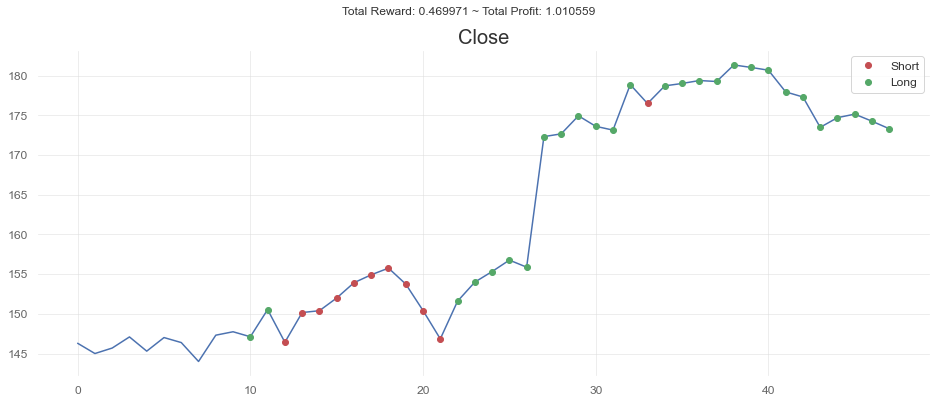

In [16]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


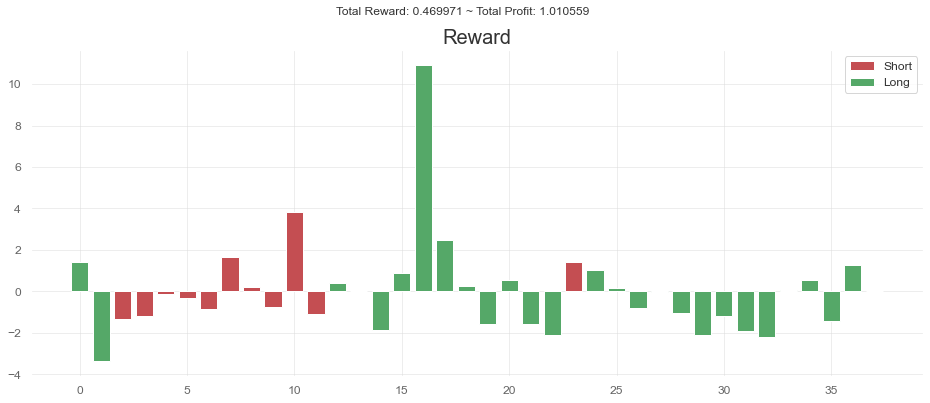

In [17]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


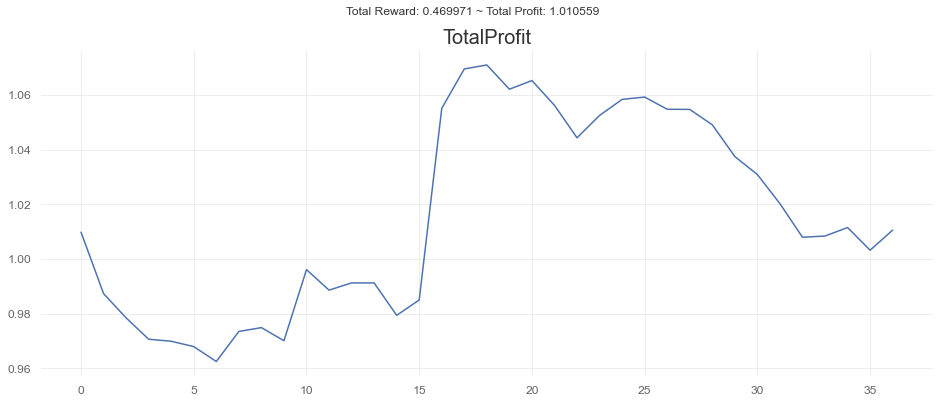

In [18]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [16]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)

目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數
注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]


第一個數字：大括號
第二個數字：有四個打橫
第三個數字：打橫入面有幾多個數字
(1, 4, 6)
[[[1 2 3 4 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]]] 

第一個數字：有幾多大組嘅數字
第二個數字：入面有幾多個小組
第三個數字：每個小組入面有幾多個數字
(4, 3, 2)
[[[1 2]
  [3 4]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]]
